In [1]:
# add path to sispeuede to sys.path in python
import sys
import pathlib
import warnings
warnings.filterwarnings("ignore")


path_git = pathlib.Path("/Users/usuario/git")
for subdir in [
    "sisepuede", 
    "sisepuede_data_pipeline",
    # "sisepuede_juypyter"
]:
    path_cur = path_git.joinpath(subdir)
    if str(path_cur) not in sys.path:
        sys.path.append(str(path_cur))
    
path_pipeline = path_git.joinpath("sisepuede_data_pipeline")


import _mexico_util as chu
import _iea_util as ieau
import importlib
import matplotlib.pyplot as plt
import numpy as np
import os, os.path
import pandas as pd
import re
import sisepuede.calibration._lib as scl
import sisepuede.core.attribute_table as at
import sisepuede.core.information_table_properties as sitp
import sisepuede.core.model_attributes as ma
import sisepuede.core.support_classes as sc
import sisepuede.legacy.data_api as api
import sisepuede.manager.sisepuede_examples as sxl
import sisepuede.manager.sisepuede_file_structure as sfs
import sisepuede.manager.sisepuede_models as sm
import sisepuede.pipeline.projection_utilities as putil
import sisepuede.utilities._plotting as spu
import sisepuede.utilities._toolbox as sf
import sisepuede.visualization.plots as svp
import time
from typing import *


import lib.process_utilities as pu
import lib.sisepuede_data_constructs as dc
import lib._util as lutil




In [5]:
### SETUP DIRECTORIES

path_cur = pathlib.Path(os.getcwd())
path_data = path_cur.joinpath("data")
path_transformations = path_cur.joinpath("transformations")


##  SETUP FILES

path_data_built = pathlib.Path(
    os.path.abspath("../generic_regions/data/output/sisepuede_raw_inputs_latest_MEX.csv")
)


# setup attribute
years = np.arange(2015, 2071)
field_year = "year"
field_time_period = "time_period"

_ATTRIBUTE_TABLE_TIME_PERIOD = pd.DataFrame(
    {
        field_time_period: range(years.shape[0]),
        field_year: years,
    }
)
_ATTRIBUTE_TABLE_TIME_PERIOD = at.AttributeTable(
    _ATTRIBUTE_TABLE_TIME_PERIOD,
    field_time_period,
    []
)


##  SETUP SOME SISEPUEDE STUFF


file_struct = sfs.SISEPUEDEFileStructure(
    attribute_time_period = _ATTRIBUTE_TABLE_TIME_PERIOD,
)

# assign some shortcuts
matt = file_struct.model_attributes
regions = sc.Regions(matt)
time_periods = sc.TimePeriods(matt)

models = sm.SISEPUEDEModels(
    matt,
    fp_julia = file_struct.dir_jl,
    fp_nemomod_reference_files = file_struct.dir_ref_nemo,
)


##  SOME GLOBALS

# attribute table
_ATTR_ENFU = matt.get_attribute_table(
    matt.subsec_name_enfu,
)

# regino info
_REGION_NAME = "mexico"
_REGION_ISO = regions.return_region_or_iso(_REGION_NAME, return_type = "iso", )


# setup region
df_input = pd.read_csv(path_data_built, )
df_input[regions.key] = _REGION_NAME

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


Precompiling NemoMod...
Info Given NemoMod was explicitly requested, output will be shown live 
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
   2148.2 ms  ? NemoMod
[ Info: Precompiling NemoMod [a3c327a0-d2f0-11e8-37fd-d12fd35c3c72] 
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
┌ Info: Skipping precompilation due to precompilable error. Importing NemoMod [a3c327a0-d2f0-11e8-37fd-d12fd35c3c72].
└   exception = Error when precompiling module, potentially caused by a __precompile__(false) declaration in the module.


In [8]:
um_energy = matt.get_unit("energy")
um_energy.convert("mwh", "pj")

3.6e-06

In [23]:
import sisepuede.models.afolu as mafl
model_afolu = mafl.AFOLU(matt, )
df_out_afolu = model_afolu(df_input, )

# Add some bespoke data
- Overwrite MSP with data from IEA
- Check [China NBS](https://data.stats.gov.cn/english/tablequery.htm?code=AC0L#:~:text=3.%20Since%202008%2C%20data%20on%20total%20passenger,statistically.%20The%20same%20applies%20to%20tables%20following.) for information on transportation demand

##  Latest MSP

In [24]:
importlib.reload(chu)

# read in data
path_iea_elec_gen = path_data.joinpath("iea", "International Energy Agency - electricity generation sources in Mexico.csv")
path_iea_cats = pathlib.Path("/Users/usuario/git/sisepuede/sisepuede/ref/data_crosswalks/fuel_categories_to_dataset.csv")

# model variables
_MODVAR_MSP = matt.get_variable("NemoMod MinShareProduction")



#
df_input = chu.overwrite_msp_from_iea(
    df_input,
    path_iea_elec_gen,
    path_iea_cats,
    _MODVAR_MSP,
    time_periods,
    models,
)

In [25]:
?models.project

Signature:
models.project(
    df_input_data: pandas.core.frame.DataFrame,
    check_results: bool = True,
    dict_optimizer_attributes: Optional[Dict[str, Any]] = None,
    fields_check: Union[List[str], str, NoneType] = 'emissions_output_subsector_aggregate',
    include_electricity_in_energy: bool = True,
    models_run: Optional[List[str]] = None,
    regions: Union[List[str], str, NoneType] = None,
    run_integrated: bool = True,
    time_periods_base: Optional[List[int]] = None,
    time_periods_run: Optional[List[int]] = None,
    verbose: bool = False,
    **kwargs,
) -> pandas.core.frame.DataFrame
Docstring:
Execute the SISEPUEDE DAG.

Function Arguments
------------------
df_input_data: DataFrame containing SISEPUEDE inputs

Optional Arguments
------------------
models_run : pd.DataFrame
    List of sector models to run as defined in 
    SISEPUEDEModels.model_attributes. Can include the following values:

    * AFOLU (or af)
    * Circular Economy (or ce)
    * IPPU (or ip

In [26]:
tp_base = list(range(12))

df_out = models(
    df_input, 
    include_electricity_in_energy = True, 
    time_periods_base = tp_base,
    time_periods_run = tp_base,
)



2026-22-Jan 18:49:03.942 Opened SQLite database at /Users/usuario/git/sisepuede_region_nbs/mexico/tmpminbwery.sqlite.
2026-22-Jan 18:49:04.075 Added NEMO structure to SQLite database at /Users/usuario/git/sisepuede_region_nbs/mexico/tmpminbwery.sqlite.
2026-22-Jan 18:49:18.705 Started modeling scenario. NEMO version = 2.2.0, solver = HiGHS.
2026-22-Jan 18:49:19.206 Started optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].
2026-22-Jan 18:49:34.782 Finished optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].
set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


In [27]:
fields = [
    x for x in df_out.columns if
    (
        True
        and ("energy_demand_enfu_subsector_total_pj_" in x)
        and ("fuel_electricity" in x)
    )
]
df_out[fields].sum(axis = 1)

0     1521.003794
1     1507.109926
2     1338.900592
3     1465.108200
4     1517.216390
5     1542.833566
6     1591.770207
7     1627.397869
8     1671.664431
9     1690.618337
10    1706.510223
11    1728.184293
dtype: float64

In [28]:
fields = [
    x for x in df_out.columns if
    (
        True
        and ("energy_demand_enfu_subsector_total_pj_" in x)
        and ("fuel_crude" in x)
    )
]
df_out[fields].sum(axis = 1)

0     3913.420333
1     2103.413976
2      748.637486
3     2122.430170
4     2126.540700
5     2595.219566
6     2652.242710
7     2704.950764
8     2789.446339
9     2820.548655
10    2851.439189
11    2891.837763
dtype: float64

# Run under some baseline assumptions
- Run with no changes
- Run once with no commercial SCOE demand (so that we can calibrate residential to IEA--this is done further below)
- Run once with no residential SCOE demand (so that we can calibrate commercial to IEA--this is done further below)

In [29]:
_MODVAR_EC_SCOE = matt.get_variable("Energy Consumption from SCOE")
_MODVAR_SEC_COMM_APP = matt.get_variable("SCOE Initial Per GDP Electric Appliances Energy Consumption")
_MODVAR_SEC_COMM_HEAT = matt.get_variable("SCOE Initial Per GDP Heat Energy Consumption")
_MODVAR_SEC_RES_APP = matt.get_variable("SCOE Initial Per Household Electric Appliances Energy Consumption")
_MODVAR_SEC_RES_HEAT = matt.get_variable("SCOE Initial Per Household Heat Energy Consumption")

(
    df_out_preliminary,
    df_out_preliminary_no_cm,
    df_out_preliminary_no_re,
) = ieau.get_enercons_calib_dfs(
    df_input, 
    models,
    run_enerprod = True,
);





2026-22-Jan 18:49:36.775 Started modeling scenario. NEMO version = 2.2.0, solver = HiGHS.
2026-22-Jan 18:49:36.841 Started optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010].
2026-22-Jan 18:49:47.059 Finished optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010].
set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


# Check and calibrate energy balances
- Start by reading in IEA data
- Realloate oil products since they're aggregated
- Set basic calibration settings

In [30]:
# time management
_YEAR_TARGET = 2022
_TIME_PERIOD_TARGET = time_periods.year_to_tp(_YEAR_TARGET, )
_IND_ROW_TARGET = np.where(df_input[time_periods.field_time_period] == _TIME_PERIOD_TARGET)[0][0]

# units managers
_UM_ENERGY = matt.get_unit("energy")

# map a grouping to a tuple, including:
#     0: energy consyumption from the table--see MEMD 2023 energy balance--in KTOE. Use ged_crude_pj_ktoe to convert to pj
#     1: time period target
#     2: fields tso scale on input 
#     3: sum fields to align on output
_DICT_TARGETS_SCALE_INPUTS = {}



##  SET ADDITIONAL MODEL VARIABLES

# ENFU ModelVariables
_MODVAR_ENFU_DEMAND_CCSQ = matt.get_variable("Energy Demand by Fuel in CCSQ")
_MODVAR_ENFU_DEMAND_INEN = matt.get_variable("Energy Demand by Fuel in Industrial Energy")
_MODVAR_ENFU_DEMAND_SCOE = matt.get_variable("Energy Demand by Fuel in SCOE")
_MODVAR_ENFU_DEMAND_TOTAL = matt.get_variable("Total Energy Demand by Fuel")
_MODVAR_ENFU_DEMAND_TRNS = matt.get_variable("Energy Demand by Fuel in Transportation")
_MODVAR_ENFU_EXPORTS = matt.get_variable("Fuel Exports")
_MODVAR_ENFU_EXPORTS_ADJ = matt.get_variable("Adjusted Fuel Exports")
_MODVAR_ENFU_IMPORT_FRAC = matt.get_variable("Fraction of Fuel Demand Imported")
_MODVAR_ENFU_IMPORTS = matt.get_variable("Fuel Imports")
_MODVAR_ENFU_PROD = matt.get_variable("Fuel Production")

# ENTC VARIABLES
_MODVAR_ENTC_AFSCALAR = matt.get_variable("NemoMod AvailabilityFactor Scalar")
_MODVAR_ENTC_GC = matt.get_variable("NemoMod Generation Capacity")
_MODVAR_ENTC_MSP = matt.get_variable("NemoMod MinShareProduction")
_MODVAR_ENTC_RC = matt.get_variable("NemoMod ResidualCapacity")

# INEN ModelVariables
_MODVAR_EC_INEN = matt.get_variable("Energy Consumption from Industrial Energy")
_MODVAR_IEC_AG = matt.get_variable("Initial Energy Consumption in Agriculture and Livestock")
_MODVAR_IEC_GDP = matt.get_variable("Initial Energy Consumption Intensity of GDP")
_MODVAR_IEC_PROD = matt.get_variable("Initial Energy Consumption Intensity of Production")

# IPPU ModelVariables
_MODVAR_IPPU_ELAST_PROD = matt.get_variable("Elasticity of Industrial Production to GDP")
_MODVAR_IPPU_ELAST_PU = matt.get_variable("Elasticity of Product Use Rate to GDP per Capita")

# SCOE ModelVariables
_MODVAR_EC_SCOE = matt.get_variable("Energy Consumption from SCOE")
_MODVAR_ELAST_SCOE_APP = matt.get_variable("SCOE Elasticity of Per Household Electrical Applicance Demand to GDP Per Capita")
_MODVAR_ELAST_SCOE_HEA = matt.get_variable("SCOE Elasticity of Per Household Heat Energy Demand to GDP Per Capita")
_MODVAR_SEC_COMM_APP = matt.get_variable("SCOE Initial Per GDP Electric Appliances Energy Consumption")
_MODVAR_SEC_COMM_HEAT = matt.get_variable("SCOE Initial Per GDP Heat Energy Consumption")
_MODVAR_SEC_RES_APP = matt.get_variable("SCOE Initial Per Household Electric Appliances Energy Consumption")
_MODVAR_SEC_RES_HEAT = matt.get_variable("SCOE Initial Per Household Heat Energy Consumption")

# TRNS ModelVariables
_MODVAR_EC_TRNS = matt.get_variable("Energy Consumption from Transportation")
_MODVAR_ELAST_TRDE_FRE = matt.get_variable("Elasticity of Megatonne-Kilometer Demand to GDP")
_MODVAR_ELAST_TRDE_PAS = matt.get_variable("Elasticity of Passenger-Kilometer Demand per Capita to GDP per Capita")
_MODVAR_TRDE_INIT_FREIGHT = matt.get_variable("Initial Megatonne-Kilometer Demand")
_MODVAR_TRDE_INIT_PASS = matt.get_variable("Initial per Capita Passenger-Kilometer Demand")


# units managers
_UM_AREA = matt.get_unit("area")
_UM_ENERGY = matt.get_unit("energy")
_UM_MASS = matt.get_unit("mass")
_UM_POWER = matt.get_unit("power")

# initialize the calibrated data frame
_DF_CALIB = df_input.copy()



# Prepare the calibration dataframe
- copy from input
- make any initial adjustments here

In [31]:
# elasticities need to be fixed; use this for now
_DF_CALIB[_MODVAR_IPPU_ELAST_PROD.fields] = 0.25
_DF_CALIB[_MODVAR_ELAST_TRDE_PAS.fields] = 1.0
_DF_CALIB[_MODVAR_ELAST_TRDE_FRE.fields] = 0.5


###  Get IEA data and allocate oil products

In [32]:
importlib.reload(ieau)



# check total consumptio
_DICT_DFS_IEA = {}
_DICT_DICTS_IEA = {}
_DICT_PATHS_IEA = {}

_FIELD_IEA_FUEL_IND = "industry total final consumption by source in Mexico"
_PART_REPL = "International Energy Agency"

# check paths
path_iter = path_data.joinpath("iea")

for path in path_iter.iterdir():
    match = chu._REGEX_IEA_FN_CONSUMPTON.match(path.parts[-1])
    if match is None: continue

    metric, region = match.groups()
    
    field = (
        path
        .parts[-1]
        .split(" - ")[1]
        .replace(".csv", "")
    )
    

    df_cons = pd.read_csv(path, )

    dict_year_to_cons = sf.build_dict(
        df_cons[[chu._FIELD_IEA_YEAR, chu._FIELD_IEA_VALUE]]
        .groupby([chu._FIELD_IEA_YEAR])
        .sum()
        .reset_index()
    )
    
    # get units and convert
    units_iea = df_cons[chu._FIELD_IEA_UNITS].unique()
    if len(units_iea) > 1:
        raise RuntimeError(f"Multiple units found in metric {metric}")
        
    units_iea = str(units_iea[0]).strip().lower()
    

    # set tuple
    tup = (
        units_iea,
        dict_year_to_cons,
        field,
    )
    """path_iea_ind_cons = path_data.joinpath("iea", "International Energy Agency - industry total final consumption by source in China.csv")
    df_cons_ind = pd.read_csv(path_iea_ind_cons, )
    
    

    
    """

    _DICT_DFS_IEA.update({metric: df_cons, })
    _DICT_DICTS_IEA.update({metric: tup, })
    _DICT_PATHS_IEA.update({metric: path, })

## attr_enfu = matt.get_attribute_table(matt.subsec_name_enfu, )


# setup variable storing dataframes with allocation
_DICT_DFS_IEA_W_ALLOC_NORMALIZED = {}
_DICT_DFS_IEA_W_ALLOC_TOTAL = {}


itp = sitp.InformationTableProperties()
df_varinfo = sitp.build_variable_information_table(matt, None, )


#  BUILD DICTIONARY OF ALLOCATION INFO
#    Maps to tuple with following ordered elements:
#     - SSP output dataframe to use for calibration scaling
#     - SSP ModelVariable
#     - any category restrictions

_DICT_ALLOCATION_INFO = ieau.build_allocation_dict(
    df_input,
    models,
    df_out_preliminary = df_out_preliminary,
    df_out_preliminary_no_cm = df_out_preliminary_no_cm,
    df_out_preliminary_no_re = df_out_preliminary_no_re,
)


for k, v in _DICT_ALLOCATION_INFO.items():

    print(f"Starting group {k}")


    df_iea_alloc_total, df_iea_alloc_norm = ieau.get_and_allocate_fuels_from_ssp(
        _DICT_PATHS_IEA.get(k),
        path_iea_cats,
        v[0],
        v[1],
        models,
        time_periods,
        df_varinfo = df_varinfo,
        groups_allocate = ["Oil products", "Oil Products", "Oil and oil products"],
    )

    # update
    _DICT_DFS_IEA_W_ALLOC_NORMALIZED.update({k: df_iea_alloc_norm, })
    _DICT_DFS_IEA_W_ALLOC_TOTAL.update({k: df_iea_alloc_total, })

Starting group commercial and public services
Starting group industry
Starting group residential
Starting group transport


# 1. Shift fuels to try and match consumption fractions
- Do this first because efficiencies can have a big impact on total demand

In [33]:
importlib.reload(scl)

# dict that maps each subsector to its associated fuel/variable dictionary
_DICT_SUBSEC_TO_DICT_FUEL_TO_MODVAR = {
    matt.subsec_name_inen: models.model_enercons.dict_inen_fuel_categories_to_fuel_variables,
    matt.subsec_name_scoe: models.model_enercons.get_scoe_dict_fuel_categories_to_fuel_variables()[0],
    matt.subsec_name_trns: models.model_enercons.dict_trns_fuel_categories_to_fuel_variables,
}



_DICT_FUEL_SCALARS_BY_IEA_SUBSEC = {}
_DICT_FUEL_SCALARS_ITER_ORDER = {}
_DICT_FUEL_TARGETS_BY_IEA_SUBSEC = {}


def get_dict_row_current(
    df: pd.DataFrame,
    modvar: 'ModelVariable',
    row_targets: Union[dict, pd.Series, None] = None,
    time_period_target: int = _TIME_PERIOD_TARGET,
    time_periods: 'TimePeriods' = time_periods,
) -> Dict[str, float]:
    """Get the current values of the target
    """
    
    row_current = (
        modvar
        .get_from_dataframe(
            df[
                df[time_periods.field_time_period].isin([time_period_target])
            ]
        )
        .copy()
        .iloc[0]
    )

    # force 0s to ensure rebalancing?
    if isinstance(row_targets, (pd.Series, dict)):
        for k in row_targets.keys():
            if k not in row_current.keys(): continue
                
            v = row_targets.get(k, )
            if v == 0:
                row_current[k] = v

    row_current = row_current/row_current.sum().sum()
    dict_row_current = row_current.to_dict()

    return dict_row_current



def get_dict_scalars(
    dict_targets: Dict[str, float],
    dict_row_current: pd.DataFrame,
    modvar: 'ModelVariable',
    model_attributes: 'ModelAttributes' = matt,
) -> Dict[str, float]:
    """Retrieve the dictionary of scalars

    Function Arguments
    ------------------
    dict_targets : Dict[str, float]
        Dictionary of targets by fuel
    dict_row_current : Dict[str, float]
        Dictionary of current values
    modvar : ModelVariable
        ModelVariable for field manipulation

    Keyword Arguments
    -----------------
    model_attributes : ModelAttributes
        ModelAttributes object for categories
    """
    # initialize scalars
    dict_scalars = dict(
        (fuel, 0) for fuel in model_attributes.get_variable_categories(modvar)#v[1])
    )

    # iterate over targets
    for fuel, targ in dict_targets.items():
        
        # try to get current value
        field = v[1].build_fields(category_restrictions = fuel, )
        val_cur = dict_row_current.get(field, 0)

        # update
        val_update = 0 if (val_cur == 0) else (targ/val_cur)
        dict_scalars.update({fuel: val_update, })

    # return 
    return dict_scalars


    
for k, v in _DICT_ALLOCATION_INFO.items():

    _DICT_FUEL_SCALARS_BY_IEA_SUBSEC.update({k: {}, })
    _DICT_FUEL_TARGETS_BY_IEA_SUBSEC.update({k: {}, })
    
    # get target total consumption of fuels
    df_targ = _DICT_DFS_IEA_W_ALLOC_NORMALIZED.get(k)
    row_target = (
        df_targ[
            df_targ[time_periods.field_time_period].isin([_TIME_PERIOD_TARGET])
        ]
        .copy()
        .iloc[0]
    )

    # get current values
    dict_row_current = get_dict_row_current(v[0], v[1], )

    # get totals from output
    dict_targets = dict((x, 0) for x in _ATTR_ENFU.key_values)
    dict_targets.update(
        dict(
            (fuel, targ) for fuel, targ in row_target.to_dict().items()
            if True
                #and (targ > 0)
                and (fuel in _ATTR_ENFU.key_values)
        )
    )

    # get scalars
    dict_scalars = get_dict_scalars(
        dict_targets,
        dict_row_current,
        v[1],
    )
    
    # get ordering to evaluate over
    fuel_pairs_iter = [tuple(x) for x in dict_scalars.items()]
    fuel_pairs_iter = sorted(
        [
            (x[1], x[0]) for x in fuel_pairs_iter 
            if x[0] in dict_targets.keys()
            and x[1] != 0
        ], 
        reverse = False,
    )
    fuels_iter = [x[1] for x in fuel_pairs_iter]
    fuels_iter = sorted([x for x in dict_targets.keys() if x not in fuels_iter]) + fuels_iter
    # prepend 0s
    
    # 
    _DICT_FUEL_SCALARS_BY_IEA_SUBSEC[k].update(dict_scalars, )
    _DICT_FUEL_SCALARS_ITER_ORDER.update({k: fuels_iter, })
    _DICT_FUEL_TARGETS_BY_IEA_SUBSEC[k].update(dict_targets, )



In [34]:
fuel_pairs_iter

[(0.9995382924912762, 'fuel_gasoline'),
 (0.9995382924912765, 'fuel_diesel'),
 (0.9995382924912766, 'fuel_kerosene'),
 (1.0440435083613728, 'fuel_electricity'),
 (51.39107239090766, 'fuel_natural_gas')]

In [1528]:
#_DICT_FUEL_SCALARS_ITER_ORDER
#_DICT_FUEL_SCALARS_BY_IEA_SUBSEC.get("transport")

In [35]:

importlib.reload(scl, )
    
df_candidate = _DF_CALIB.copy()


importlib.reload(ieau)
ii = 0
for key, v in _DICT_ALLOCATION_INFO.items():     # in ["industry"]:#v = _DICT_ALLOCATION_INFO.get(key, )
    
    print(f"starting {key}...")
        
    df_ssp_out, modvar, cats_restriction = v

    # get scalars and ordering
    dict_scalars_cur = _DICT_FUEL_SCALARS_BY_IEA_SUBSEC.get(key, )
    dict_targets = _DICT_FUEL_TARGETS_BY_IEA_SUBSEC.get(key, )
    fuels_iter = _DICT_FUEL_SCALARS_ITER_ORDER.get(key, )
    fuels_shift = _ATTR_ENFU.key_values.copy()

    # get subsector
    
    subsec = ma.clean_schema(modvar.get_property("abbreviation_subsector"), )
    subsec = matt.get_subsector_attribute(subsec, "subsector")

    dicts = [
        dict_scalars_cur
    ]
    # iterate over all fuels
    for fuel in fuels_iter:

        #check = dict_scalars_cur.get(fuel, )
        #if check > 0:
        #    raise RuntimeError(f"here!")
        # remove the fuel that was just adjusted
        fuels_shift = [x for x in fuels_shift if (x != fuel)]
        df_candidate = scl.shift_fuels_based_on_single_point(
            df_candidate,
            subsec,
            fuel,
            fuels_shift,
            _IND_ROW_TARGET,
            dict_scalars_cur.get(fuel, ),
            _DICT_SUBSEC_TO_DICT_FUEL_TO_MODVAR,
            matt,
            cats_iter = cats_restriction,
        )

        
        ##  UPDATE THE SCALARS
        
        # recalculate an allocation dictionary, which will provide necessary projections for new scalars
        dict_allocation_cur = ieau.build_allocation_dict(
            df_candidate,
            models,
            run_enerprod = False,
        )

        # get appropriate output
        df_cur, _, _ = dict_allocation_cur.get(key, )

        # update scalars
        dict_row_current = get_dict_row_current(df_cur, modvar, )
        dict_scalars_cur = get_dict_scalars(
            dict_targets,
            dict_row_current,
            modvar,
        )

        dicts.append(dict_scalars_cur)

    print(f"{key} done.\n")
    ii += 1

df_projected_tmp = models.project(
    df_candidate,
    include_electricity_in_energy = False,
)


if True:
    _DF_CALIB = df_candidate.copy()

starting commercial and public services...
commercial and public services done.

starting industry...
industry done.

starting residential...
residential done.

starting transport...
transport done.



In [36]:
df_projected = models.project(
    _DF_CALIB,
    include_electricity_in_energy = True,
    time_periods_base = tp_base,
    time_periods_run = tp_base,
)

2026-22-Jan 18:52:05.368 Started modeling scenario. NEMO version = 2.2.0, solver = HiGHS.
2026-22-Jan 18:52:05.434 Started optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].
2026-22-Jan 18:52:21.579 Finished optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].
set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


###  Check fuel demand fraction of consumption in transport

####  Look at the revised transport fractions, they're closer

In [37]:

# set the series
series = _MODVAR_ENFU_DEMAND_TRNS.get_from_dataframe(df_try_trns, ).iloc[8]
series_trns_candidate = series/series.sum()
#
print("Current share of fuels in df_candidate:\n")
for k, v in series_trns_candidate.items():
    if v > 0:
        v_disp = str(np.round(v, decimals = 5)).ljust(7, "0")
        k_disp = str(k).rjust(70, " ")
        print(f"{k_disp}:\t\t{v_disp}")



NameError: name 'df_try_trns' is not defined

##  Manual shifts

In [38]:
# increase electrification in light duty, heavy duty

cats_elec = [
    "road_light",
    "road_heavy_freight",
    "road_heavy_passenger",
]
df_candidate = scl.shift_fuels_based_on_single_point(
    df_candidate,
    subsec,
    fuel,
    fuels_shift,
    _IND_ROW_TARGET,
    dict_scalars_cur.get(fuel, ),
    _DICT_SUBSEC_TO_DICT_FUEL_TO_MODVAR,
    matt,
    cats_iter = cats_restriction,
)

dict_shifts = {
    "paddock_pasture_range": 0.55,#0.9,
    #"dry_lot": 0.5,
    #"solid_storage": 0.5,
}

for k, v in dict_shifts.items():
    for cat in _ATTR_LVST.key_values:
        field_source = f"frac_lvst_mm_{cat}_{k}"
        field_target = f"frac_lvst_mm_{cat}_daily_spread"
        
        vec_source = df_uganda_candidate[field_source].to_numpy().copy()
        vec_new = df_uganda_candidate[field_target].to_numpy().copy()
        
        vec_shift = vec_source*v
        vec_source = vec_source - vec_shift
        vec_new = vec_new + vec_shift
        
        df_uganda_candidate[field_source] = vec_source
        df_uganda_candidate[field_target] = vec_new

NameError: name '_ATTR_LVST' is not defined

# 2. Compare to demands in initial run of SISEPUEDE and scale



In [39]:



##  ADD IN INEN

# get key
key_inen = "industry"

# add industrial energy w/o ag
fields_in_inen = _MODVAR_IEC_GDP.fields + _MODVAR_IEC_PROD.fields + _MODVAR_IEC_AG.fields
fields_out_inen =  _MODVAR_EC_INEN.fields

# get conversion info
units_iea_ind, dict_years_to_cons_ind, field = _DICT_DICTS_IEA.get(key_inen)
scalar_energy_inen = _UM_ENERGY.convert(
    units_iea_ind,
    matt.configuration.get("energy_units")
)

# update all ind w/0 ag
if True:
    _DICT_TARGETS_SCALE_INPUTS.update(
        {
            "inen": (
                dict_years_to_cons_ind.get(_YEAR_TARGET)*scalar_energy_inen,
                _TIME_PERIOD_TARGET,
                fields_in_inen,
                fields_out_inen,
            ),
        }
    )




##  ADD IN SCOE -- Commerical/Municipal

key_scoe_cm = "commercial and public services"

# update commercial/municipal target
fields_in_comm = _MODVAR_SEC_COMM_APP.fields + _MODVAR_SEC_COMM_HEAT.fields
fields_out_comm = _MODVAR_EC_SCOE.build_fields(
    category_restrictions = [
        "commercial_municipal",
        "other_se"
    ]
)

# get conversion info
units_iea_scoe_cm, dict_years_to_cons_scoe_cm, field = _DICT_DICTS_IEA.get(key_scoe_cm)
scalar_energy_scoe_cm = _UM_ENERGY.convert(
    units_iea_scoe_cm,
    matt.configuration.get("energy_units")
)


if True:
    _DICT_TARGETS_SCALE_INPUTS.update(
        {
            "scoe_comm": (
                dict_years_to_cons_scoe_cm.get(_YEAR_TARGET)*scalar_energy_scoe_cm,
                _TIME_PERIOD_TARGET,
                fields_in_comm,
                fields_out_comm,
            ),
        }
    )



##  ADD IN SCOE -- Residential

key_scoe_re = "residential"

# update commercial/municipal target
fields_in_res = _MODVAR_SEC_RES_APP.fields + _MODVAR_SEC_RES_HEAT.fields
fields_out_res = _MODVAR_EC_SCOE.build_fields(
    category_restrictions = [
        "residential"
    ]
)

# get conversion info
units_iea_scoe_re, dict_years_to_cons_scoe_re, field = _DICT_DICTS_IEA.get(key_scoe_re)
scalar_energy_scoe_re = _UM_ENERGY.convert(
    units_iea_scoe_re,
    matt.configuration.get("energy_units")
)


if True:
    _DICT_TARGETS_SCALE_INPUTS.update(
        {
            "scoe_res": (
                dict_years_to_cons_scoe_re.get(_YEAR_TARGET)*scalar_energy_scoe_re,
                _TIME_PERIOD_TARGET,
                fields_in_res,
                fields_out_res,
            ),
        }
    )



##  ADD IN TRANSPORTATION

key_trns = "transport"

# update commercial/municipal target
fields_in_trns = _MODVAR_TRDE_INIT_FREIGHT.fields + _MODVAR_TRDE_INIT_PASS.fields
fields_out_trns = _MODVAR_EC_TRNS.fields

# get conversion info
units_iea_trns, dict_years_to_cons_trns, field = _DICT_DICTS_IEA.get(key_trns)
scalar_energy_trns = _UM_ENERGY.convert(
    units_iea_trns,
    matt.configuration.get("energy_units")
)


if True:
    _DICT_TARGETS_SCALE_INPUTS.update(
        {
            "trns": (
                dict_years_to_cons_trns.get(_YEAR_TARGET)*scalar_energy_trns,
                _TIME_PERIOD_TARGET,
                fields_in_trns,
                fields_out_trns,
            ),
        }
    )




##  CREATE A CANDIDATE INPUT SET

df_candidate = _DF_CALIB.copy()

for k, v in _DICT_TARGETS_SCALE_INPUTS.items():
    print(f"Starting scale group '{k}'")
    
    (
        target,
        time_period_target,
        fields_input,
        fields_output
    ) = v
    
    df_candidate, df_projected = scl.scale_inputs_single_value(
        df_candidate,
        fields_input,
        fields_output,
        {time_period_target: target},
        models,
        return_projected = True,
        threshold = 0.05,
    )

    print(f"Group '{k}' complete.\n\n")


if True:
    _DF_CALIB = df_candidate


    


####  COMPARE

def compare_total_energy_demand_outputs_from_calib(
    dict_cons: Dict[int, float],
    df_projected: pd.DataFrame,
    modvar: 'ModelVariable',
    fields: Union[List[str], None] = None,
    subsec: Union[str, None] = None,
) -> Tuple[float]:
    """Compare the calibrated and target numbers for total energy
    """

    # target total
    targ = dict_cons.get(_YEAR_TARGET, )/1000

    # get projected total
    df_proj = (
        modvar.get_from_dataframe(df_projected)
        if modvar is not None
        else df_projected[fields]
    )
        
    proj = float(
        df_proj
        .sum(axis = 1)
        .iloc[_IND_ROW_TARGET], 
    )

    # print
    nm = modvar.name if (modvar is not None) else subsec
    out_msg = f"{nm}:\n\tTarg:\t{targ}\n\tProj:\t{proj}\n"
    print(out_msg)

    # return
    out = (targ, proj, )
    
    return out


# print comparisons here--industry
tup_compare_ind = compare_total_energy_demand_outputs_from_calib(
    dict_years_to_cons_ind,
    df_projected,
    _MODVAR_EC_INEN,
)

# commercial and municipal buildings
tup_compare_scoe_cm = compare_total_energy_demand_outputs_from_calib(
    dict_years_to_cons_scoe_cm,
    df_projected,
    None,
    fields = fields_out_comm,
    subsec = "SCOE Commercial/Municipal",
)

# residential
tup_compare_scoe_re = compare_total_energy_demand_outputs_from_calib(
    dict_years_to_cons_scoe_re,
    df_projected,
    None,
    fields = fields_out_res,
    subsec = "SCOE Residential",
)

# transportation
tup_compare_trns = compare_total_energy_demand_outputs_from_calib(
    dict_years_to_cons_trns,
    df_projected,
    None,
    fields = fields_out_trns,
    subsec = "Transportation",
)

Starting scale group 'inen'
Group 'inen' complete.


Starting scale group 'scoe_comm'
Group 'scoe_comm' complete.


Starting scale group 'scoe_res'
Group 'scoe_res' complete.


Starting scale group 'trns'
Group 'trns' complete.


Energy Consumption from Industrial Energy:
	Targ:	1339.481
	Proj:	1339.4810000000004

SCOE Commercial/Municipal:
	Targ:	149.276
	Proj:	149.27600000000007

SCOE Residential:
	Targ:	809.846
	Proj:	809.846

Transportation:
	Targ:	1862.003
	Proj:	1862.0029999999997



## Do some manual updating of exports/imports

In [100]:
df_candidate = _DF_CALIB.copy()


# exports of crude oil
field_exports_crude = _MODVAR_ENFU_EXPORTS.build_fields(category_restrictions = "fuel_crude", )

# https://www.iea.org/countries/mexico/oil
df_exp_crude = pd.DataFrame(
    {
        time_periods.field_year: list(range(2015, 2025)),
        field_exports_crude: [2607.581, 2751.813, 2723.967, 2768.303, 2585.565, 2589.612, 2351.791, 2180.192, 2338.782, 1831.859]
    }
)
df_exp_crude = (
    time_periods
    .years_to_tps(
        df_exp_crude
    )
    .drop(columns = time_periods.field_year)
)


i = 0
while df_exp_crude.shape[0] < df_candidate.shape[0]:
    tp_max = df_exp_crude[time_periods.field_time_period].max()
    
    df_tmp = putil.repeat_value(
        df_exp_crude,
        df_candidate[time_periods.field_time_period].to_numpy(),
        10,
        "linear_regression",
        time_periods.field_time_period,
        [field_exports_crude]
    )

    df_exp_crude = (
        df_tmp[df_tmp[time_periods.field_time_period] <= tp_max + 1]
        if i < 3
        else df_tmp
    )

    i += 1





"""sf.match_df_to_target_df(
    df_peru,
    df_afolu[["time_period"] + [x for x in df_afolu.columns if ("lvst" in x) or ("lsmm" in x)]],
    ["time_period"],
    overwrite_only = True,
)"""
# https://www.iea.org/countries/mexico/oil
# 2015 total consumption of oil products
# transport + industry + non-energy + ag + commercial/public
total_cons_2015 = 2195.408 + 262.018 + 197.789 + 131.071 + 66.970
total_imp_2015 = 1451.490
total_exp_2015 = 407.303

# import fraction of oil products in 2023
frac_imp_2015 = total_imp_2015/(total_cons_2015 - total_exp_2015)


# 2023 total consumption of oil products
# transport + industry + non-energy + ag + commercial/public
total_cons_2023 = 2146.299 + 220.775 + 154.701 + 127.834 + 59.731
total_imp_2023 = 2006.293
total_exp_2023 = 433.788

# import fraction of oil products in 2023
frac_imp_2023 = total_imp_2023/(total_cons_2023 - total_exp_2023)

fuels_op = [
    "fuel_diesel",
    "fuel_gasoline",
    "fuel_hydrocarbon_gas_liquids",
    "fuel_kerosene",
    "fuel_oil"
]

fields_if_op = _MODVAR_ENFU_IMPORT_FRAC.build_fields(category_restrictions = fuels_op, )
field_if_elec = _MODVAR_ENFU_IMPORT_FRAC.build_fields(category_restrictions = "fuel_electricity", )

# import fractions to use; tune with the if_factor
if_factor = 0.92
dict_df_append = {
    time_periods.field_time_period: [
        time_periods.year_to_tp(2015),
        time_periods.year_to_tp(2023)
    ]
}
dict_df_append.update(
    dict(
        (x, [frac_imp_2015*if_factor, frac_imp_2023*if_factor]) 
        for x in fields_if_op
    )
)



# grab 
df_if_new = pd.concat(
    [
        df_candidate[
            df_candidate[time_periods.field_time_period].isin([2])
        ].get(
            [time_periods.field_time_period] + fields_if_op
        ),

        pd.DataFrame(dict_df_append)
    ]
)

df_if_new = (
    pd.merge(
        df_candidate[[time_periods.field_time_period]],
        df_if_new,
        how = "left",
    )
    .interpolate()
    .bfill()
    .ffill()
)

df_if_new[fields_if_op[4]] = df_if_new[fields_if_op[3]]


##  new fields to add in 
df_new = pd.merge(
    df_exp_crude,
    df_if_new,
)

df_candidate = sf.match_df_to_target_df(
    df_candidate,
    df_new,
    [time_periods.field_time_period],
    overwrite_only = True,
)



##  SOME QUICK ADJUSTMENTS

# for some quick adjustment, multiply natural gas import fraction by 50%
df_candidate[_MODVAR_ENFU_IMPORT_FRAC.build_fields(category_restrictions = "fuel_natural_gas")] = 0.62# *= 1.4
df_candidate[field_if_elec].iloc[2] = 0.008129


# update input activity ratio of crude and natural gas; these seem way too high
_MODVAR_ENTC_IAR_ELEC = matt.get_variable("Fuel Production NemoMod InputActivityRatio Electricity")
fields_scale = _MODVAR_ENTC_IAR_ELEC.build_fields(
    category_restrictions = [
        "me_crude",
        "me_natural_gas"
        
    ]
)

df_candidate[fields_scale] /= 10

# adjust fuel prod
df_candidate["exports_enfu_pj_fuel_ammonia"] = 0

field_msp_hydrogen = _MODVAR_ENTC_MSP.build_fields(category_restrictions = "fp_hydrogen_reformation")
df_candidate[field_msp_hydrogen] = 1.0

#df_candidate[_MODVAR_ENFU_IMPORT_FRAC.build_fields(category_restrictions = "fuel_natural_gas")].iloc[0] = 0.6
#df_candidate[_MODVAR_ENFU_IMPORT_FRAC.build_fields(category_restrictions = "fuel_natural_gas")].iloc[2] = 0.62


# try reducing elasticities
#df_candidate[_MODVAR_IPPU_ELAST_PROD.fields] = 0.
#df_candidate[_MODVAR_ELAST_TRDE_PAS.fields] = 0.1
#df_candidate[_MODVAR_ELAST_TRDE_FRE.fields] = 0.1


# modify wind power activity ratio and costs

# offshore is virtually unlimited (up to 1609.7 GW, or about 50789 PJ if measured in GWy)
# https://www.sciencedirect.com/science/article/abs/pii/S0973082624001911
# outlook is 2040 and beyond
# https://www.pincc.unam.mx/outlook-for-offshore-wind-energy-development-in-mexico-from-wrf-simulations-and-cmip6-projections/
# 

# assume 
# https://solartechonline.com/blog/wind-turbine-cost-guide-2025/#:~:text=Offshore%20Wind%20Turbines%20(12%2D20MW)&text=Turbine%20Cost:%20$12%2D$20,%2D$4%2C000%20per%20kW%20installed
cost_on_shore = 1125 
cost_off_shore = 2800 

_MODVAR_ENTC_AFS = matt.get_variable("NemoMod AvailabilityFactor Scalar")
_MODVAR_ENTC_CC = matt.get_variable("NemoMod CapitalCost")

field_afs = _MODVAR_ENTC_AFS.build_fields(category_restrictions = "pp_wind")
field_cc = _MODVAR_ENTC_CC.build_fields(category_restrictions = "pp_wind")


# 
vec = df_candidate[field_cc].to_numpy()
traj_prpoportional = vec/vec.max()

traj_on_shore = cost_on_shore*traj_prpoportional
traj_off_shore = cost_off_shore*traj_prpoportional

vec_ramp = sf.ramp_vector(
    traj_prpoportional.shape[0],
    r_0 = 25,
    r_1 = 50
)

traj_targ = (traj_on_shore + traj_off_shore)/2
traj_mix = traj_on_shore*(1 - vec_ramp) + traj_targ*vec_ramp

# update capital cost and availability factor
df_candidate[field_afs] = (1 - vec_ramp) + 1.5*vec_ramp
df_candidate[field_cc] = traj_mix





In [97]:
"""# figure ES-3: https://docs.nrel.gov/docs/fy12osti/53510.pdf
# looks like roughly 80% (2020) to 70% (2030) over 10 years
r = 0.875**(1/10)
n = df_candidate.shape[0]
n_0 = 11

vec_traj = list(np.ones(n_0))

for i in range(n - n_0):
    factor = (
        r 
        if vec_traj[-1] == 1
        else (1 + vec_traj[-1])/2
    )
    print(vec_traj)
    vec_traj.append(factor, )
    
[r**(i + 1) ]
plt.plot(vec_traj)""";

In [91]:
[]

[np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0)]

In [43]:
1609.07*0.0036

5.7926519999999995

In [73]:
[x for x in matt.all_variables if "Capital" in x]

['NemoMod CapitalCost',
 'NemoMod CapitalCostStorage',
 'NemoMod Discounted Capital Investment',
 'NemoMod Discounted Capital Investment Storage']

<Axes: >

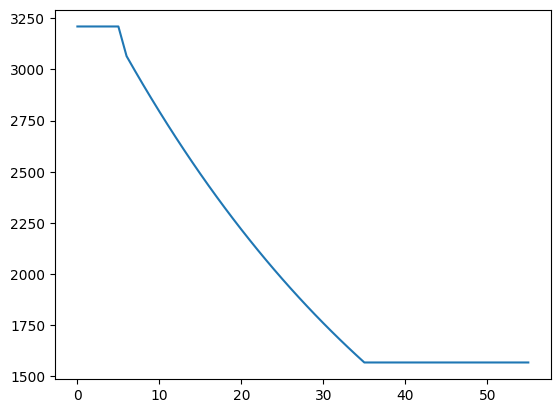

In [80]:
_MODVAR_ENTC_CC = matt.get_variable("NemoMod CapitalCost")
field = _MODVAR_ENTC_CC.build_fields(category_restrictions = "pp_wind")
df_candidate[field].plot()


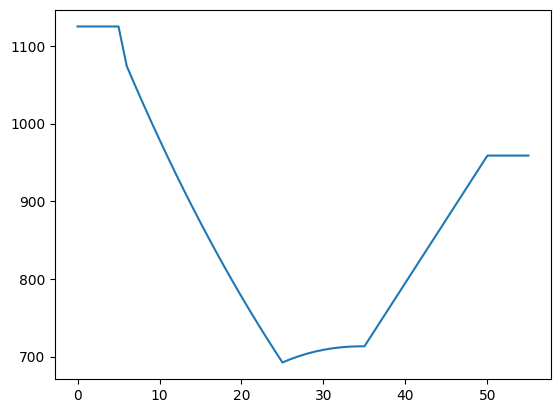

In [66]:
 plt.plot(traj_mix)



In [768]:
sf._write_csv(
    df_candidate,
    path_data.joinpath("sisepuede_adj_inputs_MEX_20250119.csv")
)

True

In [1101]:
# get attribute
import sisepuede.core.attribute_table as at
import sisepuede.transformers.transformers as trfs
import sisepuede.transformers.transformations as trma
import sisepuede.transformers.strategies as trs
importlib.reload(trma.trs.tbe)
importlib.reload(trma.trs)
importlib.reload(trma)
importlib.reload(trs)



# based on ssp_uganda_ndc, copied over here
path_transformations = pathlib.Path("/Users/usuario/git/sisepuede_region_nbs/mexico/transformations_mexico_with_entc_examples")
df_mexico["region"] = "mexico"


# NOTE: need to pass the| attribute time period to run with a non-default set of time periods
# pass attr_time_period and df_input so that config baseline is called
transformations = trma.Transformations(
    path_transformations,
    attr_time_period = _ATTRIBUTE_TABLE_TIME_PERIOD,
    df_input = df_mexico,
)

transformers = transformations.transformers

"""
strategies = trs.Strategies(
    transformations,
    export_path = "transformations",
    prebuild = True,
)

strats = [0] + list(range(6003, 6012))
strategies.build_strategies_to_templates(
    include_simplex_group_as_trajgroup = False,
    strategies = strats,
)
""";


In [1102]:
transformation = transformations.get_transformation("TX:ENFU:ADJ_EXPORTS_STRATEGY_3")
df = transformation()
df[[x for x in df.columns if ("export" in x) and ("enfu" in x)]]


,exports_enfu_pj_fuel_coal,exports_enfu_pj_fuel_crude,exports_enfu_pj_fuel_diesel,exports_enfu_pj_fuel_electricity,exports_enfu_pj_fuel_gasoline,exports_enfu_pj_fuel_hydrocarbon_gas_liquids,exports_enfu_pj_fuel_kerosene,exports_enfu_pj_fuel_natural_gas,exports_enfu_pj_fuel_oil,exports_enfu_pj_fuel_ammonia,exports_enfu_pj_fuel_hydrogen,exports_enfu_pj_fuel_natural_gas_liquid
0,0.076,2607.581000,131.966172,8.352,213.019469,17.921332,38.286482,1.0260,39.113715,0,0.0,0.0
1,0.053,2751.813000,126.613692,7.085,204.379509,17.194452,36.733602,0.9150,41.277210,0,0.0,0.0
2,2.892,2723.967000,108.226368,6.494,174.698736,14.697408,31.399008,0.7780,40.858860,0,0.0,0.0
3,0.053,2768.303000,126.613692,7.085,204.379509,17.194452,36.733602,0.9150,41.277210,0,0.0,0.0
4,0.053,2585.565000,126.613692,7.085,204.379509,17.194452,36.733602,0.9150,41.277210,0,0.0,0.0
5,0.053,2589.612000,126.613692,7.085,204.379509,17.194452,36.733602,0.9150,41.277210,0,0.0,0.0
6,0.053,2351.791000,126.613692,7.085,204.379509,17.194452,36.733602,0.9150,41.277210,0,0.0,0.0
7,0.053,2180.192000,126.613692,7.085,204.379509,17.194452,36.733602,0.9150,41.277210,0,0.0,0.0
8,0.053,2338.782000,126.613692,7.085,204.379509,17.194452,36.733602,0.9150,41.277210,0,0.0,0.0
9,0.053,1831.859000,126.613692,7.085,204.379509,17.194452,36.733602,0.9150,41.277210,0,0.0,0.0


In [1090]:
transformer = transformers.get_transformer("TFR:ENFU:ADJ_EXPORTS")
df = transformer(magnitude = {"fuel_crude": 2})
df[[x for x in df.columns if ("export" in x) and ("enfu" in x)]]

,exports_enfu_pj_fuel_coal,exports_enfu_pj_fuel_crude,exports_enfu_pj_fuel_diesel,exports_enfu_pj_fuel_electricity,exports_enfu_pj_fuel_gasoline,exports_enfu_pj_fuel_hydrocarbon_gas_liquids,exports_enfu_pj_fuel_kerosene,exports_enfu_pj_fuel_natural_gas,exports_enfu_pj_fuel_oil,exports_enfu_pj_fuel_ammonia,exports_enfu_pj_fuel_hydrogen,exports_enfu_pj_fuel_natural_gas_liquid
0,0.076,2607.581000,131.966172,8.352,213.019469,17.921332,38.286482,1.026,39.113715,0,0.0,0.0
1,0.053,2751.813000,126.613692,7.085,204.379509,17.194452,36.733602,0.915,41.277210,0,0.0,0.0
2,2.892,2723.967000,108.226368,6.494,174.698736,14.697408,31.399008,0.778,40.858860,0,0.0,0.0
3,0.053,2768.303000,126.613692,7.085,204.379509,17.194452,36.733602,0.915,41.277210,0,0.0,0.0
4,0.053,2585.565000,126.613692,7.085,204.379509,17.194452,36.733602,0.915,41.277210,0,0.0,0.0
5,0.053,2589.612000,126.613692,7.085,204.379509,17.194452,36.733602,0.915,41.277210,0,0.0,0.0
6,0.053,2351.791000,126.613692,7.085,204.379509,17.194452,36.733602,0.915,41.277210,0,0.0,0.0
7,0.053,2180.192000,126.613692,7.085,204.379509,17.194452,36.733602,0.915,41.277210,0,0.0,0.0
8,0.053,2338.782000,126.613692,7.085,204.379509,17.194452,36.733602,0.915,41.277210,0,0.0,0.0
9,0.053,1831.859000,126.613692,7.085,204.379509,17.194452,36.733602,0.915,41.277210,0,0.0,0.0


In [1087]:
strat = strategies.get_strategy(6010)
df = strat()

df[[x for x in df.columns if ("export" in x) and ("enfu" in x)]]

,exports_enfu_pj_fuel_coal,exports_enfu_pj_fuel_crude,exports_enfu_pj_fuel_diesel,exports_enfu_pj_fuel_electricity,exports_enfu_pj_fuel_gasoline,exports_enfu_pj_fuel_hydrocarbon_gas_liquids,exports_enfu_pj_fuel_kerosene,exports_enfu_pj_fuel_natural_gas,exports_enfu_pj_fuel_oil,exports_enfu_pj_fuel_ammonia,exports_enfu_pj_fuel_hydrogen,exports_enfu_pj_fuel_natural_gas_liquid
0,0.076,2607.581000,131.966172,8.352,213.019469,17.921332,38.286482,1.026,39.113715,0,0.0,0.0
1,0.053,2751.813000,126.613692,7.085,204.379509,17.194452,36.733602,0.915,41.277210,0,0.0,0.0
2,2.892,2723.967000,108.226368,6.494,174.698736,14.697408,31.399008,0.778,40.858860,0,0.0,0.0
3,0.053,2768.303000,126.613692,7.085,204.379509,17.194452,36.733602,0.915,41.277210,0,0.0,0.0
4,0.053,2585.565000,126.613692,7.085,204.379509,17.194452,36.733602,0.915,41.277210,0,0.0,0.0
5,0.053,2589.612000,126.613692,7.085,204.379509,17.194452,36.733602,0.915,41.277210,0,0.0,0.0
6,0.053,2351.791000,126.613692,7.085,204.379509,17.194452,36.733602,0.915,41.277210,0,0.0,0.0
7,0.053,2180.192000,126.613692,7.085,204.379509,17.194452,36.733602,0.915,41.277210,0,0.0,0.0
8,0.053,2338.782000,126.613692,7.085,204.379509,17.194452,36.733602,0.915,41.277210,0,0.0,0.0
9,0.053,1831.859000,126.613692,7.085,204.379509,17.194452,36.733602,0.915,41.277210,0,0.0,0.0


In [877]:
df = transformations.get_transformation("TX:ENTC:TARGET_RENEWABLE_ELEC_STRATEGY_4")()
df[[x for x in df.columns if "nemomod_entc_renewable_energy_tag" in x]].iloc[0]

df = strategies.get_strategy(6011)
df()

,strategy_id,year,ef_ippu_tonne_nf3_per_tonne_production_chemicals,ef_ippu_tonne_nf3_per_tonne_production_electronics,ef_ippu_tonne_sf6_per_mmm_gdp_other_product_manufacturing,ef_ippu_tonne_sf6_per_tonne_production_chemicals,ef_ippu_tonne_sf6_per_tonne_production_electronics,ef_ippu_tonne_sf6_per_tonne_production_metals,frac_agrc_bevs_and_spices_cl2_dry,frac_agrc_cereals_cl2_dry,...,nemomod_entc_scalar_availability_factor_pp_geothermal,nemomod_entc_scalar_availability_factor_pp_hydropower,nemomod_entc_scalar_availability_factor_pp_nuclear,nemomod_entc_scalar_availability_factor_pp_ocean,nemomod_entc_scalar_availability_factor_pp_oil,nemomod_entc_scalar_availability_factor_pp_solar,nemomod_entc_scalar_availability_factor_pp_waste_incineration,nemomod_entc_scalar_availability_factor_pp_wind,iso_alpha_3,region
0,6011,2015,0.0,0.0,0.000264,0.0,3.663322e-08,1.403871e-07,0.729069,0.729069,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,MEX,mexico
1,6011,2016,0.0,0.0,0.000265,0.0,3.982696e-08,1.572880e-07,0.729069,0.729069,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,MEX,mexico
2,6011,2017,0.0,0.0,0.000266,0.0,3.638876e-08,1.617559e-07,0.729069,0.729069,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,MEX,mexico
3,6011,2018,0.0,0.0,0.000265,0.0,3.606106e-08,1.608518e-07,0.729069,0.729069,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,MEX,mexico
4,6011,2019,0.0,0.0,0.000265,0.0,3.455479e-08,1.636647e-07,0.729069,0.729069,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,MEX,mexico
5,6011,2020,0.0,0.0,0.000263,0.0,3.888212e-08,1.862774e-07,0.729069,0.729069,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,MEX,mexico
6,6011,2021,0.0,0.0,0.000267,0.0,3.687091e-08,1.655789e-07,0.729069,0.729069,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,MEX,mexico
7,6011,2022,0.0,0.0,0.000267,0.0,3.687091e-08,1.655789e-07,0.729069,0.729069,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,MEX,mexico
8,6011,2023,0.0,0.0,0.000267,0.0,3.687091e-08,1.655789e-07,0.729069,0.729069,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,MEX,mexico
9,6011,2024,0.0,0.0,0.000267,0.0,3.687091e-08,1.655789e-07,0.729069,0.729069,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,MEX,mexico


In [878]:
import sisepuede as si
importlib.reload(si)
ssp = si.SISEPUEDE(
    "calibrated",
    attribute_time_period = _ATTRIBUTE_TABLE_TIME_PERIOD,
    db_type = "csv", 
    #id_str = "sisepuede_run_2025-10-29T19:49:25.722413",
    logger = logger,
    regions = [_REGION_NAME],
    strategies = strategies,
    #try_exogenous_xl_types_in_variable_specification = True,
)

logger = ssp.logger




2026-01-20 21:26:16,178 - INFO - Successfully initialized SISEPUEDEFileStructure.
2026-01-20 21:26:16,179 - WARNING - Missing key dict_dimensional_keys: key time_series not found. Tables that rely on the time_series will not have index checking.
2026-01-20 21:26:16,180 - INFO - 	Setting export engine to 'csv'.
2026-01-20 21:26:16,180 - WARNING - No index fields defined. Index field values will not be checked when writing to tables.
2026-01-20 21:26:16,180 - INFO - Successfully instantiated table ANALYSIS_METADATA
2026-01-20 21:26:16,181 - WARNING - No index fields found in ATTRIBUTE_DESIGN. Initializing index fields.
2026-01-20 21:26:16,181 - INFO - Successfully instantiated table ATTRIBUTE_DESIGN
2026-01-20 21:26:16,181 - WARNING - No index fields found in ATTRIBUTE_LHC_SAMPLES_EXOGENOUS_UNCERTAINTIES. Initializing index fields.
2026-01-20 21:26:16,181 - INFO - Successfully instantiated table ATTRIBUTE_LHC_SAMPLES_EXOGENOUS_UNCERTAINTIES
2026-01-20 21:26:16,182 - WARNING - No index fi

In [933]:
# run
strats_run = [0, 6003, 6008, 6009, 6010, 6011]#, 6004, 6008, 6009]
dict_run = {
    ssp.key_future: [0],
    ssp.key_design: [0],
    ssp.key_strategy: [6010],#strats_run,#list(range(6006)),
}

# we'll save inputs since we're doing a small set of runs
dict_successes = ssp(dict_run, save_inputs = True, )

2026-01-20 22:23:00,159 - INFO - 
***	STARTING REGION mexico	***

2026-01-20 22:23:01,615 - INFO - Trying run primary_id = 79079 in region mexico
2026-01-20 22:23:01,616 - INFO - Running AFOLU model
2026-01-20 22:23:01,971 - INFO - AFOLU model run successfully completed
2026-01-20 22:23:01,972 - INFO - Running CircularEconomy model
2026-01-20 22:23:01,999 - INFO - CircularEconomy model run successfully completed
2026-01-20 22:23:01,999 - INFO - Running IPPU model
2026-01-20 22:23:02,048 - INFO - IPPU model run successfully completed
2026-01-20 22:23:02,049 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2026-01-20 22:23:02,060 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2026-01-20 22:23:02,118 - INFO - EnergyConsumption without Fugitive Emissions model run successfully completed
2026-01-20 22:23:02,118 - INFO - Running Energy model (Electricity and Fuel Production: tryi

set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


2026-01-20 22:36:01,069 - INFO - Table MODEL_OUTPUT successfully appended to /Users/usuario/git/sisepuede/sisepuede/out/sisepuede_run_2026-01-20T21;26;15.811754/sisepuede_run_2026-01-20T21;26;15.811754_output_database/MODEL_OUTPUT.csv.
2026-01-20 22:36:01,071 - WARNING - Warning: index tuples (np.int64(79079),) found in table ATTRIBUTE_PRIMARY.
2026-01-20 22:36:01,071 - WARNING - Running conflict resolution 'write_skip' for table ATTRIBUTE_PRIMARY.
2026-01-20 22:36:01,072 - WARNING - Stash failed
2026-01-20 22:36:01,073 - INFO - Table ATTRIBUTE_PRIMARY successfully appended to /Users/usuario/git/sisepuede/sisepuede/out/sisepuede_run_2026-01-20T21;26;15.811754/sisepuede_run_2026-01-20T21;26;15.811754_output_database/ATTRIBUTE_PRIMARY.csv.


In [940]:
ssp.generate_summary_files(None, export = True, );


# write tableau table too
import sisepuede.visualization.tables as svt
importlib.reload(svt)
tableau_levers_table = svt.LeversImplementationTable(strategies, )
tableau_levers_table_csv = tableau_levers_table.build_table_for_strategies(
    [x for x in strats_run if x != 0], 
)


from sisepuede.manager.sisepuede import _DEFAULT_PREFIX_SUMMARY_RUNS
path_tableau_file = (
    pathlib.Path(ssp.file_struct.dir_out)
    .joinpath( 
        f"{_DEFAULT_PREFIX_SUMMARY_RUNS}_{ssp.id_fs_safe}",
        "tableau_levers_table.csv"
    )
)

tableau_levers_table_csv.to_csv(
    path_tableau_file,
    encoding = "UTF-8",
    index = None,
)



In [892]:
path = "/Users/usuario/git/sisepuede/sisepuede/out/sisepuede_run_2026-01-20T21;26;15.811754/sisepuede_run_2026-01-20T21;26;15.811754_output_database/MODEL_OUTPUT.csv"
df = pd.read_csv(path, )
df = df[~df["primary_id"].isin([79079])].reset_index(drop = True, )
#sf._write_csv(df, path, )




In [979]:
transformer(magnitude = {"fuel_crude": 0.8, "fuel_natural_gas": 1.4}, return_magnitude = True, )

{'fuel_crude': 0.8, 'fuel_natural_gas': 1.4}

In [982]:
dir(transformer)

['__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_format_docstr_with_code',
 '_initialize_code',
 '_initialize_fields',
 '_initialize_function',
 '_initialize_uuid',
 '_uuid',
 'baseline',
 'citations',
 'code',
 'code_baseline',
 'description',
 'description_units',
 'field_citations',
 'field_description',
 'field_description_units',
 'field_transformer_id',
 'field_transformer_name',
 'function',
 'function_list',
 'id',
 'is_transformer',
 'name']

In [937]:
df_out = ssp.read_output(None)



In [973]:
import sisepuede.core.attribute_table as at
import sisepuede.transformers.transformers as trfs
import sisepuede.transformers.transformations as trma
import sisepuede.transformers.strategies as trs
importlib.reload(trma.trs.tbe)
importlib.reload(trma.trs)
importlib.reload(trma)
importlib.reload(trs)



# based on ssp_uganda_ndc, copied over here
path_transformations = pathlib.Path("/Users/usuario/git/sisepuede_region_nbs/mexico/transformations_mexico_with_entc_examples")
#path_transformations = pathlib.Path(os.getcwd()).joinpath("data_processing", "transformations")

df_mexico = df_candidate.copy()
df_mexico[regions.key] = "mexico"



#importlib.reload(trma.tbe)
# NOTE: need to pass the| attribute time period to run with a non-default set of time periods
# pass attr_time_period and df_input so that config baseline is called
transformations = trma.Transformations(
    path_transformations,
    attr_time_period = _ATTRIBUTE_TABLE_TIME_PERIOD,
    df_input = df_mexico,
)

transformers = transformations.transformers




transformer = transformers.get_transformer("TFR:ENFU:ADJ_EXPORTS")

df = transformer(
    magnitude = {"fuel_crude": 0.6, "fuel_natural_gas": 200},
    #vec_implementation_ramp = [0 for x in range(12)] + list(np.arange(15)/15) + list(np.ones(29))

)

df[[x for x in df.columns if ("export" in x) and ("enfu" in x)]]

,exports_enfu_pj_fuel_coal,exports_enfu_pj_fuel_crude,exports_enfu_pj_fuel_diesel,exports_enfu_pj_fuel_electricity,exports_enfu_pj_fuel_gasoline,exports_enfu_pj_fuel_hydrocarbon_gas_liquids,exports_enfu_pj_fuel_kerosene,exports_enfu_pj_fuel_natural_gas,exports_enfu_pj_fuel_oil,exports_enfu_pj_fuel_ammonia,exports_enfu_pj_fuel_hydrogen,exports_enfu_pj_fuel_natural_gas_liquid
0,0.076,2607.581000,131.966172,8.352,213.019469,17.921332,38.286482,1.026000,39.113715,0,0.0,0.0
1,0.053,2751.813000,126.613692,7.085,204.379509,17.194452,36.733602,0.915000,41.277210,0,0.0,0.0
2,2.892,2723.967000,108.226368,6.494,174.698736,14.697408,31.399008,0.778000,40.858860,0,0.0,0.0
3,0.053,2768.303000,126.613692,7.085,204.379509,17.194452,36.733602,0.915000,41.277210,0,0.0,0.0
4,0.053,2585.565000,126.613692,7.085,204.379509,17.194452,36.733602,0.915000,41.277210,0,0.0,0.0
5,0.053,2589.612000,126.613692,7.085,204.379509,17.194452,36.733602,0.915000,41.277210,0,0.0,0.0
6,0.053,2351.791000,126.613692,7.085,204.379509,17.194452,36.733602,0.915000,41.277210,0,0.0,0.0
7,0.053,2180.192000,126.613692,7.085,204.379509,17.194452,36.733602,0.915000,41.277210,0,0.0,0.0
8,0.053,2338.782000,126.613692,7.085,204.379509,17.194452,36.733602,0.915000,41.277210,0,0.0,0.0
9,0.053,1831.859000,126.613692,7.085,204.379509,17.194452,36.733602,0.915000,41.277210,0,0.0,0.0


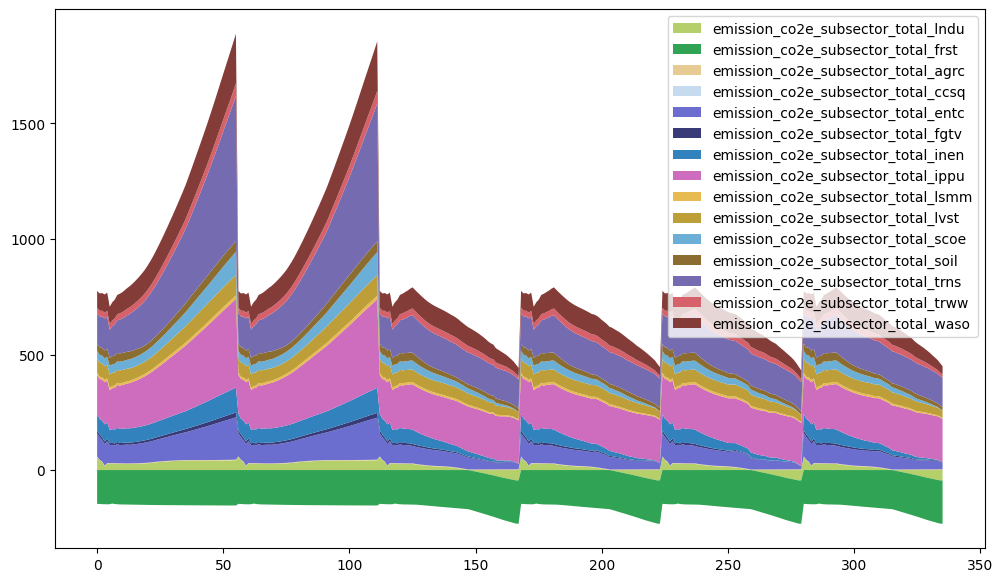

In [939]:
fig, ax = plt.subplots(figsize = (12, 7))
svp.plot_emissions_stack(
    df_out,#[df_out["primary_id"].isin([79079])],
    matt,
    figtuple = (fig, ax)
)

ax.legend()

In [ ]:
# df_out.iloc[224:224][[x for x in df_out.columns if "prod" in x and "gas_ccs" in x]]

In [806]:
df_mexico["frac_entc_ccs_achievement_pp_gas_ccs"]

0     1.0
1     1.0
2     1.0
3     1.0
4     1.0
5     1.0
6     1.0
7     1.0
8     1.0
9     1.0
10    1.0
11    1.0
12    1.0
13    1.0
14    1.0
15    1.0
16    1.0
17    1.0
18    1.0
19    1.0
20    1.0
21    1.0
22    1.0
23    1.0
24    1.0
25    1.0
26    1.0
27    1.0
28    1.0
29    1.0
30    1.0
31    1.0
32    1.0
33    1.0
34    1.0
35    1.0
36    1.0
37    1.0
38    1.0
39    1.0
40    1.0
41    1.0
42    1.0
43    1.0
44    1.0
45    1.0
46    1.0
47    1.0
48    1.0
49    1.0
50    1.0
51    1.0
52    1.0
53    1.0
54    1.0
55    1.0
Name: frac_entc_ccs_achievement_pp_gas_ccs, dtype: float64

In [845]:
[x for x in df_mexico.columns if "ccs" in x and "gas" in x]

df_mexico["nemomod_entc_emissions_activity_ratio_scalar_pp_gas_ccs_co2"]

0     0.1
1     0.1
2     0.1
3     0.1
4     0.1
5     0.1
6     0.1
7     0.1
8     0.1
9     0.1
10    0.1
11    0.1
12    0.1
13    0.1
14    0.1
15    0.1
16    0.1
17    0.1
18    0.1
19    0.1
20    0.1
21    0.1
22    0.1
23    0.1
24    0.1
25    0.1
26    0.1
27    0.1
28    0.1
29    0.1
30    0.1
31    0.1
32    0.1
33    0.1
34    0.1
35    0.1
36    0.1
37    0.1
38    0.1
39    0.1
40    0.1
41    0.1
42    0.1
43    0.1
44    0.1
45    0.1
46    0.1
47    0.1
48    0.1
49    0.1
50    0.1
51    0.1
52    0.1
53    0.1
54    0.1
55    0.1
Name: nemomod_entc_emissions_activity_ratio_scalar_pp_gas_ccs_co2, dtype: float64

In [763]:
strat = strategies.get_strategy(6002)
df_6002 = strat()

df_projected_6002 = models.project(
    df_6002,
    include_electricity_in_energy = True,
    time_periods_base = tp_base,
    #time_periods_run = tp_base,
)



2026-19-Jan 17:49:54.689 Started modeling scenario. NEMO version = 2.2.0, solver = HiGHS.
2026-19-Jan 17:49:54.778 Started optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].
2026-19-Jan 17:50:12.527 Finished optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].
2026-19-Jan 17:50:12.563 Started optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035, 1036, 1037, 1038, 1039, 1040, 1041, 1042, 1043, 1044, 1045, 1046, 1047, 1048, 1049, 1050, 1051, 1052, 1053, 1054, 1055].
2026-19-Jan 17:52:34.741 Finished optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035, 1036, 1037, 1038, 1039, 1040, 1041, 1042, 1043, 1044, 1045, 1046, 1047, 1048, 1049, 1050, 1051, 1052, 105

In [628]:
df_projected_candidate = models.project(
    df_candidate,
    include_electricity_in_energy = True,
    time_periods_base = tp_base,
    time_periods_run = tp_base,
)



2026-19-Jan 10:23:44.596 Started modeling scenario. NEMO version = 2.2.0, solver = HiGHS.
2026-19-Jan 10:23:44.666 Started optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].
2026-19-Jan 10:23:59.479 Finished optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].
set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


In [629]:

_MODVAR_ENFU_PROD.get_from_dataframe(df_projected_candidate)


,prod_enfu_fuel_ammonia_pj,prod_enfu_fuel_coal_pj,prod_enfu_fuel_crude_pj,prod_enfu_fuel_diesel_pj,prod_enfu_fuel_electricity_pj,prod_enfu_fuel_gasoline_pj,prod_enfu_fuel_hydrocarbon_gas_liquids_pj,prod_enfu_fuel_hydrogen_pj,prod_enfu_fuel_kerosene_pj,prod_enfu_fuel_natural_gas_pj,prod_enfu_fuel_natural_gas_liquid_pj,prod_enfu_fuel_oil_pj
0,1.2,343.448900,4308.295372,464.546775,1392.382868,749.627349,91.448571,0.2112,134.482301,992.402183,0.0,21.983436
1,1.2,274.688436,4027.676636,348.499648,1421.841317,562.365044,76.578915,0.2112,100.887655,1018.700839,0.0,16.491816
2,1.2,243.325029,3516.506221,216.480551,1413.832262,349.329174,58.260844,0.2112,62.669260,1000.417712,0.0,10.244364
3,1.2,255.500767,3656.435521,242.591670,1404.490947,391.464025,61.864383,0.2112,70.228205,1003.364618,0.0,11.480003
4,1.2,267.956066,3496.084167,248.706535,1447.377327,401.331427,62.339616,0.2112,71.998406,991.378499,0.0,11.769373
5,1.2,133.405616,3476.000613,242.115322,1195.979437,390.695355,56.173149,0.2112,70.090306,809.883555,0.0,11.457461
6,1.2,121.413000,3286.571724,255.333526,1225.476683,412.025236,59.287299,0.2112,73.916863,855.728524,0.0,12.082978
7,1.2,170.292806,3155.307715,266.350945,1250.405528,429.803765,60.471116,0.2112,77.106311,845.395773,0.0,12.604348
8,1.2,165.007181,3358.551141,278.547942,1274.348119,449.485750,65.000731,0.2112,80.637237,944.640837,0.0,13.181538
9,1.2,116.747461,2868.863967,283.255865,1287.357603,457.082805,64.530993,0.2112,82.000140,906.680317,0.0,13.404328


In [622]:
df_projected_candidate[[x for x in df_projected_candidate.columns if ("prod" in x) and ("enfu" in x)]]


,prod_enfu_fuel_ammonia_pj,prod_enfu_fuel_coal_pj,prod_enfu_fuel_crude_pj,prod_enfu_fuel_diesel_pj,prod_enfu_fuel_electricity_pj,prod_enfu_fuel_gasoline_pj,prod_enfu_fuel_hydrocarbon_gas_liquids_pj,prod_enfu_fuel_hydrogen_pj,prod_enfu_fuel_kerosene_pj,prod_enfu_fuel_natural_gas_liquid_pj,prod_enfu_fuel_natural_gas_pj,prod_enfu_fuel_oil_pj
0,1.2,343.365849,4181.131894,429.812325,1391.852741,693.577248,86.760141,0.2112,124.426977,0.0,992.099125,20.339721
1,1.2,274.649125,3963.256925,330.903533,1421.573279,533.970639,74.203812,0.2112,95.793731,0.0,1018.547587,15.659126
2,1.2,243.325029,3516.506221,216.480551,1413.832262,349.329174,58.260844,0.2112,62.669260,0.0,1000.417712,10.244364
3,1.2,255.486109,3623.500939,233.595655,1404.353990,376.947384,60.650170,0.2112,67.623936,0.0,1003.288268,11.054291
4,1.2,267.926990,3430.063349,230.673080,1447.102806,372.231299,59.905638,0.2112,66.777876,0.0,991.226803,10.915988
5,1.2,133.378258,3386.715473,217.727265,1195.608379,351.340965,52.881676,0.2112,63.030173,0.0,809.684825,10.303362
6,1.2,121.380765,3159.590172,220.648769,1224.948854,356.055323,54.605845,0.2112,63.875924,0.0,855.435129,10.441614
7,1.2,170.225196,2990.148250,221.237968,1249.719013,357.006098,54.382577,0.2112,64.046492,0.0,845.028865,10.469496
8,1.2,164.927903,3151.772418,222.066748,1273.487759,358.343479,57.376244,0.2112,64.286416,0.0,944.124021,10.508716
9,1.2,116.699944,2655.475908,224.969343,1286.470549,363.027323,56.663758,0.2112,65.126693,0.0,906.179857,10.646074


In [447]:
df_projected_candidate_noener = models.project(
    df_candidate,
    include_electricity_in_energy = False,
    time_periods_base = tp_base,
    time_periods_run = tp_base,
)

2026-19-Jan 08:27:15.839 Opened SQLite database at /Users/usuario/git/sisepuede_region_nbs/mexico/tmpd53poobq.sqlite.
2026-19-Jan 08:27:15.848 Added NEMO structure to SQLite database at /Users/usuario/git/sisepuede_region_nbs/mexico/tmpd53poobq.sqlite.
2026-19-Jan 08:27:16.417 Started modeling scenario. NEMO version = 2.2.0, solver = HiGHS.
2026-19-Jan 08:27:16.554 Started optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].
2026-19-Jan 08:27:25.649 Finished optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].
set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


In [600]:
df_candidate[[x for x in df_candidate.columns if ("import" in x) and ("enfu" in x)]].head()
df_projected_candidate[[x for x in df_projected_candidate.columns if ("export" in x) and ("enfu" in x)]]
df_projected_candidate[#HEREHEREHEREHERE
    [
        x for x in df_projected_candidate.columns 
        if ("energy_demand_enfu_subsector_total_pj_" in x) 
        and ("fuel_electricity" in x) 
        and ("entc" not in x)
    ]
].sum(axis = 1)#/(0.85**2)


#retrieve_nemomod_tables_fuel_production_demand_and_trade


0     1155.485030
1     1185.420532
2     1181.414007
3     1172.159370
4     1209.680929
5      996.951656
6     1022.466958
7     1044.151162
8     1062.734654
9     1076.520569
10    1084.811105
11    1096.163822
dtype: float64

In [601]:
df_projected_candidate[[x for x in df_projected_candidate.columns if ("prod" in x) and ("enfu" in x)]]
#df_projected_candidate[[x for x in df_projected_candidate.columns if ("emission_co2e_co2" in x) and ("entc" in x)]]




,prod_enfu_fuel_ammonia_pj,prod_enfu_fuel_coal_pj,prod_enfu_fuel_crude_pj,prod_enfu_fuel_diesel_pj,prod_enfu_fuel_electricity_pj,prod_enfu_fuel_gasoline_pj,prod_enfu_fuel_hydrocarbon_gas_liquids_pj,prod_enfu_fuel_hydrogen_pj,prod_enfu_fuel_kerosene_pj,prod_enfu_fuel_natural_gas_liquid_pj,prod_enfu_fuel_natural_gas_pj,prod_enfu_fuel_oil_pj
0,1.2,343.365849,4181.131894,429.812325,1391.852741,693.577248,86.760141,0.2112,124.426977,0.0,992.099125,20.339721
1,1.2,274.649125,3963.256925,330.903533,1421.573279,533.970639,74.203812,0.2112,95.793731,0.0,1018.547587,15.659126
2,1.2,243.325029,3516.506221,216.480551,1413.832262,349.329174,58.260844,0.2112,62.669260,0.0,1000.417712,10.244364
3,1.2,255.486109,3623.500939,233.595655,1404.353990,376.947384,60.650170,0.2112,67.623936,0.0,1003.288268,11.054291
4,1.2,267.926990,3430.063349,230.673080,1447.102806,372.231299,59.905638,0.2112,66.777876,0.0,991.226803,10.915988
5,1.2,133.378258,3386.715473,217.727265,1195.608379,351.340965,52.881676,0.2112,63.030173,0.0,809.684825,10.303362
6,1.2,121.380765,3159.590172,220.648769,1224.948854,356.055323,54.605845,0.2112,63.875924,0.0,855.435129,10.441614
7,1.2,170.225196,2990.148250,221.237968,1249.719013,357.006098,54.382577,0.2112,64.046492,0.0,845.028865,10.469496
8,1.2,164.927903,3151.772418,222.066748,1273.487759,358.343479,57.376244,0.2112,64.286416,0.0,944.124021,10.508716
9,1.2,116.699944,2655.475908,224.969343,1286.470549,363.027323,56.663758,0.2112,65.126693,0.0,906.179857,10.646074


In [ ]:
nemomod_entc_frac_min_share_production_fp_hydrogen_reformation

In [742]:
df_6005[[x for x in df_6005.columns if "min_share" in x and "hydrogen" in x]]#.sum(axis = 1)

,nemomod_entc_frac_min_share_production_fp_hydrogen_reformation_ccs,nemomod_entc_frac_min_share_production_fp_hydrogen_electrolysis,nemomod_entc_frac_min_share_production_fp_hydrogen_gasification,nemomod_entc_frac_min_share_production_fp_hydrogen_reformation
0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0


In [580]:
#/Users/usuario/git/sisepuede_region_nbs/mexico/tmpgs_owsj6.sqlite


In [729]:
import sisepuede.utilities._sql as squ
import sqlalchemy

engine = sqlalchemy.create_engine(f"sqlite:///{models.fp_nemomod_temp_sqlite_db}")




In [738]:
df_production_by_technology = squ.sql_table_to_df(engine, "vproductionbytechnologyannual")
df_production_by_technology[
    df_production_by_technology["f"].isin(["fuel_hydrogen"]) &
    df_production_by_technology["t"].isin(["fp_hydrogen_gasification"])
    #& df_production_by_technology["y"].isin(["1000"])
].sort_values(by = ["t", "y"])





,r,t,f,y,val,solvedtm
414,costa_rica,fp_hydrogen_gasification,fuel_hydrogen,1011,0.351688,2026-01-19 17:29:58.292
1982,costa_rica,fp_hydrogen_gasification,fuel_hydrogen,1012,0.714155,2026-01-19 17:31:40.992
1973,costa_rica,fp_hydrogen_gasification,fuel_hydrogen,1013,1.309734,2026-01-19 17:31:40.992
1983,costa_rica,fp_hydrogen_gasification,fuel_hydrogen,1014,1.915815,2026-01-19 17:31:40.992
1979,costa_rica,fp_hydrogen_gasification,fuel_hydrogen,1015,2.534616,2026-01-19 17:31:40.992
1991,costa_rica,fp_hydrogen_gasification,fuel_hydrogen,1016,3.167292,2026-01-19 17:31:40.992
1985,costa_rica,fp_hydrogen_gasification,fuel_hydrogen,1017,3.815173,2026-01-19 17:31:40.992
1987,costa_rica,fp_hydrogen_gasification,fuel_hydrogen,1018,4.479724,2026-01-19 17:31:40.992
1975,costa_rica,fp_hydrogen_gasification,fuel_hydrogen,1019,5.162498,2026-01-19 17:31:40.992
1992,costa_rica,fp_hydrogen_gasification,fuel_hydrogen,1020,5.865150,2026-01-19 17:31:40.992


In [582]:
matt.get_variable(mod.modvar_enfu_production_fuel).get_from_dataframe(
    df_projected_candidate
)

,prod_enfu_fuel_ammonia_pj,prod_enfu_fuel_coal_pj,prod_enfu_fuel_crude_pj,prod_enfu_fuel_diesel_pj,prod_enfu_fuel_electricity_pj,prod_enfu_fuel_gasoline_pj,prod_enfu_fuel_hydrocarbon_gas_liquids_pj,prod_enfu_fuel_hydrogen_pj,prod_enfu_fuel_kerosene_pj,prod_enfu_fuel_natural_gas_pj,prod_enfu_fuel_natural_gas_liquid_pj,prod_enfu_fuel_oil_pj
0,1.2,375.342691,4181.480752,429.907615,1595.964254,693.731015,90.166546,0.2112,124.454562,1108.783703,0.0,20.344230
1,1.2,303.467736,3963.513189,330.973531,1618.068146,534.083593,77.480657,0.2112,95.813995,1130.894553,0.0,15.662439
2,1.2,262.776888,3516.654459,216.521042,1592.194289,349.394514,61.167860,0.2112,62.680982,1100.185147,0.0,10.246280
3,1.2,275.025096,3623.658464,233.638683,1586.920434,377.016817,63.615914,0.2112,67.636392,1105.063256,0.0,11.056327
4,1.2,286.416801,3430.210498,230.713274,1621.675938,372.296159,62.716608,0.2112,66.789511,1087.693169,0.0,10.917890
5,1.2,145.529103,3386.852951,217.764817,1360.410645,351.401562,55.453736,0.2112,63.041044,897.948702,0.0,10.305139
6,1.2,131.046426,3159.720996,220.684504,1383.218681,356.112987,57.169250,0.2112,63.886268,943.409847,0.0,10.443305
7,1.2,185.113903,2990.266259,221.270202,1400.900574,357.058113,56.736820,0.2112,64.055823,925.827958,0.0,10.471022
8,1.2,179.883581,3151.909468,222.104183,1435.793311,358.403886,60.216805,0.2112,64.297253,1041.620646,0.0,10.510488
9,1.2,124.264860,2655.585189,224.999193,1427.691579,363.075491,58.984969,0.2112,65.135334,985.854249,0.0,10.647486


In [402]:
mod.get_enfu_fuel_production_from_total_production(
    df_production_by_technology,
    np.arange(12),
    #attribute_fuel = attribute_fuel,
    #attribute_technology = attribute_technology,
    #dict_tech_info = dict_tech_info,
    #modvar_enfu_production = self.modvar_enfu_production_fuel
)

,prod_enfu_fuel_ammonia_pj,prod_enfu_fuel_coal_pj,prod_enfu_fuel_crude_pj,prod_enfu_fuel_diesel_pj,prod_enfu_fuel_electricity_pj,prod_enfu_fuel_gasoline_pj,prod_enfu_fuel_hydrocarbon_gas_liquids_pj,prod_enfu_fuel_hydrogen_pj,prod_enfu_fuel_kerosene_pj,prod_enfu_fuel_natural_gas_pj,prod_enfu_fuel_natural_gas_liquid_pj,prod_enfu_fuel_oil_pj
0,1.2,465.284831,4967.244282,644.537352,1887.814731,1040.073578,127.467760,0.2112,186.588028,1397.098036,0.0,30.501010
1,1.2,372.943448,4708.824599,534.553852,1916.568817,862.595994,113.574696,0.2112,154.748749,1428.886704,0.0,25.296334
2,1.2,338.158122,4106.739837,377.701683,1883.068719,609.487626,91.386160,0.2112,109.341393,1392.558235,0.0,17.873724
3,1.2,347.084925,4251.464795,405.122726,1877.856147,653.736269,95.402745,0.2112,117.279550,1403.639230,0.0,19.171352
4,1.2,362.571369,4053.495572,400.962345,1919.434662,647.022767,93.885498,0.2112,116.075155,1370.742716,0.0,18.974473
5,1.2,181.381714,3968.709514,376.697773,1608.900312,607.867642,83.783323,0.2112,109.050770,1135.792361,0.0,17.826217
6,1.2,164.688620,3758.399863,384.212439,1638.424484,619.993868,86.466702,0.2112,111.226201,1193.246825,0.0,18.181828
7,1.2,229.011727,3597.125875,387.032692,1661.006559,624.544839,86.299004,0.2112,112.042640,1174.416129,0.0,18.315289
8,1.2,222.808378,3767.372519,390.216684,1701.398391,629.682766,90.729351,0.2112,112.964379,1311.999864,0.0,18.465963
9,1.2,157.175772,3282.411168,396.215456,1696.148109,639.362832,89.702627,0.2112,114.700971,1248.908181,0.0,18.749839


In [376]:
df = squ.sql_table_to_df(engine, "vusebytechnologyannual")
df[
    df["f"].isin(["fuel_electricity"])
    & df["y"].isin(["1008"])
]


,r,t,f,y,val,solvedtm
22,costa_rica,fp_natural_gas,fuel_electricity,1008,14.386158,2026-01-18 20:07:58.697
70,costa_rica,me_coal,fuel_electricity,1008,1.919403,2026-01-18 20:07:58.697
154,costa_rica,me_natural_gas,fuel_electricity,1008,61.836614,2026-01-18 20:07:58.697
214,costa_rica,fp_ammonia_production,fuel_electricity,1008,0.457175,2026-01-18 20:07:58.697
462,costa_rica,me_crude,fuel_electricity,1008,156.427193,2026-01-18 20:07:58.697


In [372]:
matt.get_variable(mod.modvar_enfu_production_fuel).get_from_dataframe(
    df_projected_candidate
)

,prod_enfu_fuel_ammonia_pj,prod_enfu_fuel_coal_pj,prod_enfu_fuel_crude_pj,prod_enfu_fuel_diesel_pj,prod_enfu_fuel_electricity_pj,prod_enfu_fuel_gasoline_pj,prod_enfu_fuel_hydrocarbon_gas_liquids_pj,prod_enfu_fuel_hydrogen_pj,prod_enfu_fuel_kerosene_pj,prod_enfu_fuel_natural_gas_pj,prod_enfu_fuel_natural_gas_liquid_pj,prod_enfu_fuel_oil_pj
0,1.2,465.284831,4967.244282,644.537352,1887.814731,1040.073578,127.467760,0.2112,186.588028,1397.098036,0.0,30.501010
1,1.2,372.943448,4708.824599,534.553852,1916.568817,862.595994,113.574696,0.2112,154.748749,1428.886704,0.0,25.296334
2,1.2,338.158122,4106.739837,377.701683,1883.068719,609.487626,91.386160,0.2112,109.341393,1392.558235,0.0,17.873724
3,1.2,347.084925,4251.464795,405.122726,1877.856147,653.736269,95.402745,0.2112,117.279550,1403.639230,0.0,19.171352
4,1.2,362.571369,4053.495572,400.962345,1919.434662,647.022767,93.885498,0.2112,116.075155,1370.742716,0.0,18.974473
5,1.2,181.381714,3968.709514,376.697773,1608.900312,607.867642,83.783323,0.2112,109.050770,1135.792361,0.0,17.826217
6,1.2,164.688620,3758.399863,384.212439,1638.424484,619.993868,86.466702,0.2112,111.226201,1193.246825,0.0,18.181828
7,1.2,229.011727,3597.125875,387.032692,1661.006559,624.544839,86.299004,0.2112,112.042640,1174.416129,0.0,18.315289
8,1.2,222.808378,3767.372519,390.216684,1701.398391,629.682766,90.729351,0.2112,112.964379,1311.999864,0.0,18.465963
9,1.2,157.175772,3282.411168,396.215456,1696.148109,639.362832,89.702627,0.2112,114.700971,1248.908181,0.0,18.749839


In [ ]:
1887.814731

In [353]:
df_elec_trajectories2 = pd.merge(
    df_projected_candidate, 
    df_candidate
)
(
    arr_enfu_demands_no_entc, 
    _,#arr_enfu_demands_distribution_no_entc, 
    _,#arr_enfu_export_no_entc, 
    _,#arr_enfu_imports_no_entc, 
    _,#arr_enfu_production_no_entc
) = mod.model_enercons.project_enfu_production_and_demands(
    df_elec_trajectories2, 
    target_energy_units = mod.model_attributes.configuration.get("energy_units_nemomod"),
)

arr_enfu_demands_no_entc[:, ind_elec]

array([1404.47771009, 1426.15668113, 1398.76786156, 1395.25425042,
       1424.24706537, 1195.53889161, 1216.32967848, 1231.84090179,
       1263.22773173, 1256.22685438, 1268.96584989, 1274.18445974])

In [354]:
df_enfu_demands_entc, df_enfu_imports = mod.retrieve_nemomod_fuel_sectoral_demands_and_imports(
    engine,
    df_elec_trajectories2["time_period"].to_numpy(),

)

AttributeError: 'NoneType' object has no attribute 'shape'

In [350]:
matt.get_variable(
    #mod.modvar_enfu_production_fuel
    mod.modvar_enfu_energy_demand_by_fuel_entc
).get_from_dataframe(
    df_projected_candidate
)

,energy_demand_enfu_subsector_total_pj_entc_fuel_ammonia,energy_demand_enfu_subsector_total_pj_entc_fuel_biofuels,energy_demand_enfu_subsector_total_pj_entc_fuel_biogas,energy_demand_enfu_subsector_total_pj_entc_fuel_biomass,energy_demand_enfu_subsector_total_pj_entc_fuel_coal,energy_demand_enfu_subsector_total_pj_entc_fuel_coke,energy_demand_enfu_subsector_total_pj_entc_fuel_crude,energy_demand_enfu_subsector_total_pj_entc_fuel_diesel,energy_demand_enfu_subsector_total_pj_entc_fuel_electricity,energy_demand_enfu_subsector_total_pj_entc_fuel_furnace_gas,...,energy_demand_enfu_subsector_total_pj_entc_fuel_natural_gas,energy_demand_enfu_subsector_total_pj_entc_fuel_natural_gas_liquid,energy_demand_enfu_subsector_total_pj_entc_fuel_nuclear,energy_demand_enfu_subsector_total_pj_entc_fuel_ocean,energy_demand_enfu_subsector_total_pj_entc_fuel_oil,energy_demand_enfu_subsector_total_pj_entc_fuel_other,energy_demand_enfu_subsector_total_pj_entc_fuel_solar,energy_demand_enfu_subsector_total_pj_entc_fuel_waste,energy_demand_enfu_subsector_total_pj_entc_fuel_water,energy_demand_enfu_subsector_total_pj_entc_fuel_wind
0,0.0,0.0,0.000000,1.930174,457.993905,0.0,2359.663449,250.255238,248.992680,0.0,...,2831.669660,0.0,26054.068315,0.0,479.682809,0.0,8.828574,0.000000,187.236863,53.137742
1,0.0,0.0,0.000000,0.000000,460.957114,0.0,1957.011775,241.166741,240.736149,0.0,...,2876.214191,0.0,23404.419730,0.0,507.203920,0.0,11.269072,0.000000,183.571759,62.055710
2,0.0,0.0,0.020832,0.000000,402.375533,0.0,1382.773012,216.684105,217.353855,0.0,...,2766.406051,0.0,23456.996341,0.0,560.100180,0.0,19.101774,6.084003,186.114228,60.767480
3,0.0,0.0,0.042199,0.000000,329.919180,0.0,1483.161972,222.673816,223.094881,0.0,...,2748.496480,0.0,27436.361200,0.0,639.022446,0.0,21.524566,12.370262,176.195008,69.755368
4,0.0,0.0,0.063792,0.000000,333.754938,0.0,1467.930738,213.938968,214.566136,0.0,...,2783.712663,0.0,23873.009541,0.0,662.600820,0.0,40.650039,18.597596,136.609937,97.232912
5,0.0,0.0,0.084234,0.000000,194.796875,0.0,1379.097680,199.296449,198.587236,0.0,...,2260.311227,0.0,20964.650402,0.0,578.937648,0.0,45.813402,23.550237,134.786395,99.025303
6,0.0,0.0,0.105395,0.000000,164.406100,0.0,1406.609013,193.705638,193.862720,0.0,...,2389.171810,0.0,18938.966079,0.0,555.580201,0.0,55.797120,30.332947,148.121840,96.291654
7,0.0,0.0,0.106917,0.000000,268.419574,0.0,1416.934014,187.333997,187.689740,0.0,...,2328.965587,0.0,20085.116557,0.0,308.210279,0.0,102.671784,31.165528,179.188303,103.106622
8,0.0,0.0,0.108330,0.000000,257.280701,0.0,1428.590668,199.570162,200.493078,0.0,...,2681.355950,0.0,22639.540620,0.0,288.706236,0.0,102.671784,31.898064,96.571002,103.023279
9,0.0,0.0,0.109560,0.000000,149.346007,0.0,1450.552285,178.111234,179.706285,0.0,...,2510.665011,0.0,21493.369782,0.0,424.542185,0.0,112.286006,32.474944,112.283212,128.158122


In [347]:
squ.get_table_names(engine)
df = squ.sql_table_to_df(engine, "SpecifiedAnnualDemand")

df[
    df["f"].isin(["fuel_electricity"])
]

,id,r,f,y,val
48,49,costa_rica,fuel_electricity,1000,1607.839262
49,50,costa_rica,fuel_electricity,1001,1649.980948
50,51,costa_rica,fuel_electricity,1002,1643.625118
51,52,costa_rica,fuel_electricity,1003,1631.631716
52,53,costa_rica,fuel_electricity,1004,1683.549624
53,54,costa_rica,fuel_electricity,1005,1389.199953
54,55,costa_rica,fuel_electricity,1006,1424.505018
55,56,costa_rica,fuel_electricity,1007,1454.509060
56,57,costa_rica,fuel_electricity,1008,1480.222704
57,58,costa_rica,fuel_electricity,1009,1499.298027


In [283]:
flds = [x for x in df_projected_candidate.columns if ("energy_demand" in x) and ("subsector_total" in x) and ("fuel_electr" in x)]
df_projected_candidate[flds].sum(axis = 1)



0     1404.477710
1     1426.156681
2     1379.240800
3     1395.254250
4     1424.247065
5     1195.538892
6     1216.329678
7     1231.840902
8     1263.227732
9     1256.226854
10    1268.965850
11    1274.184460
dtype: float64

In [251]:
df_candidate["frac_enfu_transmission_loss_fuel_electricity"]

field_elec = matt.get_variable("Total Energy Demand by Fuel").build_fields(category_restrictions = "fuel_electricity")
df_projected_candidate[field_elec] + df_projected_candidate["exportsadj_enfu_fuel_electricity"]

0     1906.570793
1     1939.150905
2     2626.953338
3     1899.981060
4     1942.052402
5     1627.842399
6     1657.716545
7     1680.566473
8     1721.435608
9     1716.124679
10    1732.871001
11    1741.419610
dtype: float64

In [254]:
[x for x in df_candidate.columns if ("export" in x) and ("enfu" in x)]
df_candidate["exports_enfu_pj_fuel_electricity"]


0     8.352
1     7.085
2     6.494
3     7.085
4     7.085
5     7.085
6     7.085
7     7.085
8     7.085
9     7.085
10    7.085
11    7.085
12    7.085
13    7.085
14    7.085
15    7.085
16    7.085
17    7.085
18    7.085
19    7.085
20    7.085
21    7.085
22    7.085
23    7.085
24    7.085
25    7.085
26    7.085
27    7.085
28    7.085
29    7.085
30    7.085
31    7.085
32    7.085
33    7.085
34    7.085
35    7.085
36    7.085
37    7.085
38    7.085
39    7.085
40    7.085
41    7.085
42    7.085
43    7.085
44    7.085
45    7.085
46    7.085
47    7.085
48    7.085
49    7.085
50    7.085
51    7.085
52    7.085
53    7.085
54    7.085
55    7.085
Name: exports_enfu_pj_fuel_electricity, dtype: float64

In [243]:
df_projected_candidate[
    [
        x for x in df_projected_candidate.columns if 
        ("energy_demand_enfu_subsector_total_pj_" in x) 
        and ("fuel_electricity" in x)
    ]
].iloc[8]


energy_demand_enfu_subsector_total_pj_ccsq_fuel_electricity      0.000000
energy_demand_enfu_subsector_total_pj_entc_fuel_electricity    200.493078
energy_demand_enfu_subsector_total_pj_inen_fuel_electricity    490.375383
energy_demand_enfu_subsector_total_pj_scoe_fuel_electricity    566.383419
energy_demand_enfu_subsector_total_pj_trns_fuel_electricity      5.975852
Name: 8, dtype: float64

In [224]:
df_projected_candidate[[x for x in df_projected_candidate.columns if ("prod" in x) and ("enfu" in x)]].iloc[8]
df_projected_candidate["prod_enfu_fuel_electricity_pj"]



0     1887.814731
1     1914.081405
2     1198.650290
3     1870.347509
4     1912.733322
5     1616.346273
6     1636.773844
7     1653.706633
8     1689.386231
9     1680.775720
10    1695.397558
11    1701.062645
Name: prod_enfu_fuel_electricity_pj, dtype: float64

In [112]:
_DF_CALIB[
    _DF_CALIB[time_periods.field_time_period].isin([_TIME_PERIOD_TARGET])
][fields_if_op]

,frac_enfu_fuel_demand_imported_pj_fuel_diesel,frac_enfu_fuel_demand_imported_pj_fuel_gasoline,frac_enfu_fuel_demand_imported_pj_fuel_hydrocarbon_gas_liquids,frac_enfu_fuel_demand_imported_pj_fuel_kerosene,frac_enfu_fuel_demand_imported_pj_fuel_oil
7,0.336056,0.336056,0.336056,0.336056,0.002677


In [93]:
_MODVAR_ENFU_IMPORT_FRAC.get_from_dataframe(_DF_CALIB)

,frac_enfu_fuel_demand_imported_pj_fuel_ammonia,frac_enfu_fuel_demand_imported_pj_fuel_coal,frac_enfu_fuel_demand_imported_pj_fuel_crude,frac_enfu_fuel_demand_imported_pj_fuel_diesel,frac_enfu_fuel_demand_imported_pj_fuel_electricity,frac_enfu_fuel_demand_imported_pj_fuel_gasoline,frac_enfu_fuel_demand_imported_pj_fuel_hydrocarbon_gas_liquids,frac_enfu_fuel_demand_imported_pj_fuel_hydrogen,frac_enfu_fuel_demand_imported_pj_fuel_kerosene,frac_enfu_fuel_demand_imported_pj_fuel_natural_gas,frac_enfu_fuel_demand_imported_pj_fuel_natural_gas_liquid,frac_enfu_fuel_demand_imported_pj_fuel_oil
0,0.0,0.353773,0.002069,0.296034,0.006312,0.296034,0.296034,0.0,0.296034,0.384384,0.0,0.002069
1,0.0,0.390111,0.002677,0.336056,0.008129,0.336056,0.336056,0.0,0.336056,0.442948,0.0,0.002677
2,0.0,0.498072,0.003961,0.857224,0.543897,0.857224,0.857224,0.0,0.857224,0.615376,0.0,0.003961
3,0.0,0.390111,0.002677,0.336056,0.008129,0.336056,0.336056,0.0,0.336056,0.442948,0.0,0.002677
4,0.0,0.390111,0.002677,0.336056,0.008129,0.336056,0.336056,0.0,0.336056,0.442948,0.0,0.002677
5,0.0,0.390111,0.002677,0.336056,0.008129,0.336056,0.336056,0.0,0.336056,0.442948,0.0,0.002677
6,0.0,0.390111,0.002677,0.336056,0.008129,0.336056,0.336056,0.0,0.336056,0.442948,0.0,0.002677
7,0.0,0.390111,0.002677,0.336056,0.008129,0.336056,0.336056,0.0,0.336056,0.442948,0.0,0.002677
8,0.0,0.390111,0.002677,0.336056,0.008129,0.336056,0.336056,0.0,0.336056,0.442948,0.0,0.002677
9,0.0,0.390111,0.002677,0.336056,0.008129,0.336056,0.336056,0.0,0.336056,0.442948,0.0,0.002677


(<Figure size 1800x1200 with 1 Axes>, <Axes: >)

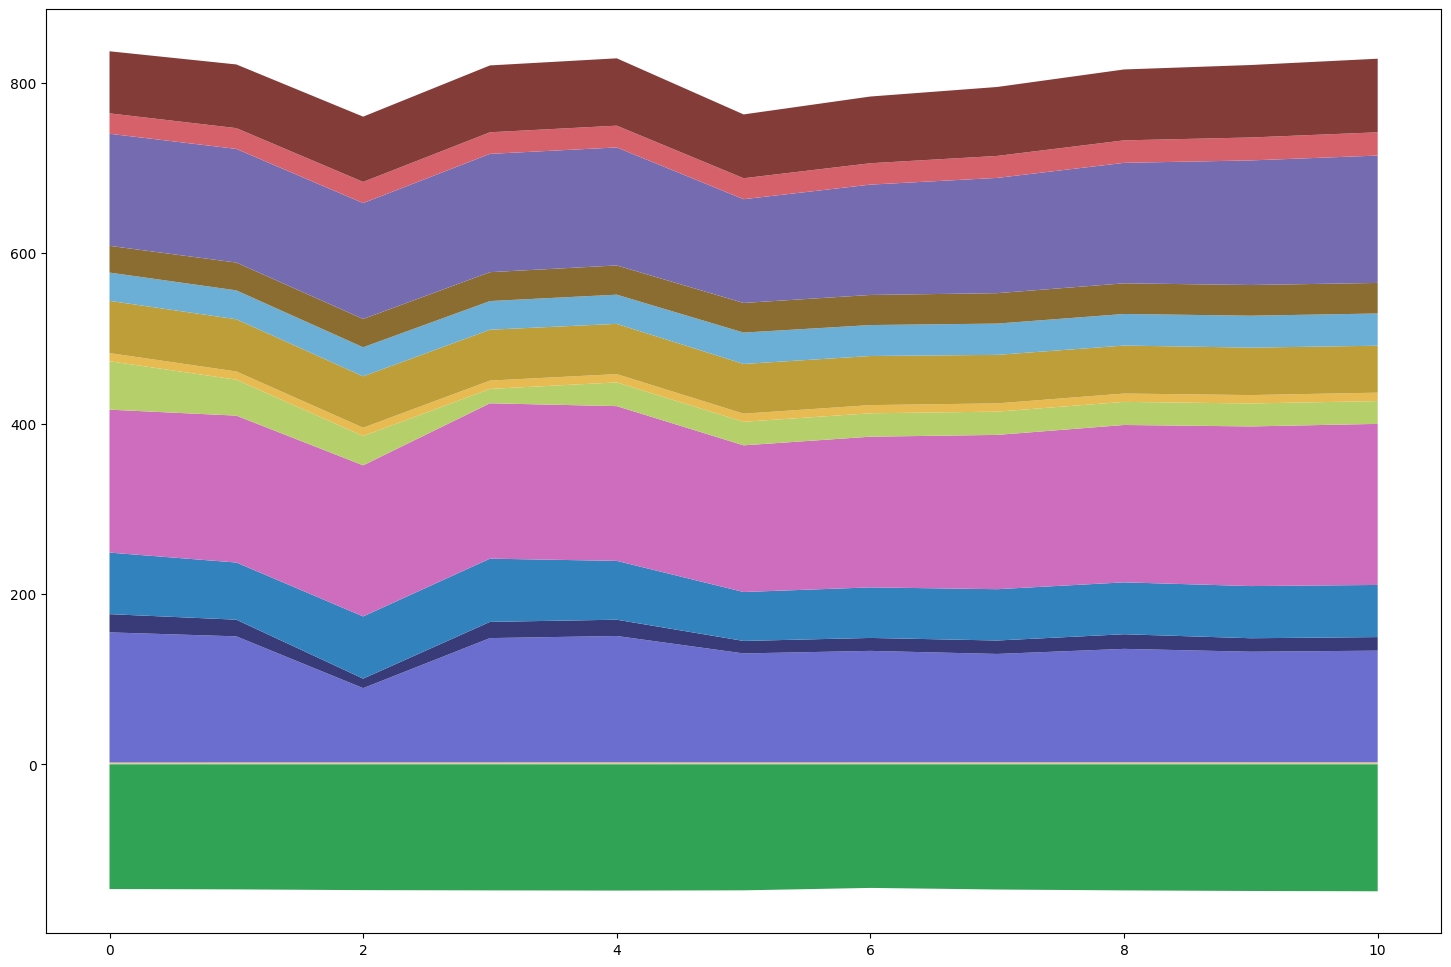

In [74]:
svp.plot_emissions_stack(df_try, matt)

In [90]:
df_try[[x for x in df_try.columns if ("prod" in x) and ("enfu" in x)]].iloc[9]

prod_enfu_fuel_ammonia_pj                       1.200000
prod_enfu_fuel_coal_pj                        164.842787
prod_enfu_fuel_crude_pj                      5955.216780
prod_enfu_fuel_diesel_pj                      875.003111
prod_enfu_fuel_electricity_pj                1844.017858
prod_enfu_fuel_gasoline_pj                   1411.970328
prod_enfu_fuel_hydrocarbon_gas_liquids_pj     173.244659
prod_enfu_fuel_hydrogen_pj                      0.211200
prod_enfu_fuel_kerosene_pj                    253.305885
prod_enfu_fuel_natural_gas_liquid_pj            0.000000
prod_enfu_fuel_natural_gas_pj                1903.481874
prod_enfu_fuel_oil_pj                          41.407187
Name: 9, dtype: float64

In [91]:
_DF_CALIB["exports_enfu_pj_fuel_crude"]

0     2607.581
1     2751.814
2     2723.924
3     2751.814
4     2751.814
5     2751.814
6     2751.814
7     2751.814
8     2751.814
9     2751.814
10    2751.814
11    2751.814
12    2751.814
13    2751.814
14    2751.814
15    2751.814
16    2751.814
17    2751.814
18    2751.814
19    2751.814
20    2751.814
21    2751.814
22    2751.814
23    2751.814
24    2751.814
25    2751.814
26    2751.814
27    2751.814
28    2751.814
29    2751.814
30    2751.814
31    2751.814
32    2751.814
33    2751.814
34    2751.814
35    2751.814
36    2751.814
37    2751.814
38    2751.814
39    2751.814
40    2751.814
41    2751.814
42    2751.814
43    2751.814
44    2751.814
45    2751.814
46    2751.814
47    2751.814
48    2751.814
49    2751.814
50    2751.814
51    2751.814
52    2751.814
53    2751.814
54    2751.814
55    2751.814
Name: exports_enfu_pj_fuel_crude, dtype: float64

In [87]:
_DF_CALIB[[x for x in _DF_CALIB.columns if ("export" in x) and ("enfu" in x)]].iloc[9]

exports_enfu_pj_fuel_coal                          0.053000
exports_enfu_pj_fuel_crude                      2751.814000
exports_enfu_pj_fuel_diesel                      126.613692
exports_enfu_pj_fuel_electricity                   7.085000
exports_enfu_pj_fuel_gasoline                    204.379509
exports_enfu_pj_fuel_hydrocarbon_gas_liquids      17.194452
exports_enfu_pj_fuel_kerosene                     36.733602
exports_enfu_pj_fuel_natural_gas                   0.915000
exports_enfu_pj_fuel_oil                          41.277210
exports_enfu_pj_fuel_ammonia                       1.200000
exports_enfu_pj_fuel_hydrogen                      0.000000
exports_enfu_pj_fuel_natural_gas_liquid            0.000000
Name: 9, dtype: float64

In [86]:
_DF_CALIB[[x for x in _DF_CALIB.columns if ("import" in x) and ("enfu" in x)]].iloc[9]

frac_enfu_fuel_demand_imported_pj_fuel_coal                       0.390111
frac_enfu_fuel_demand_imported_pj_fuel_crude                      0.002677
frac_enfu_fuel_demand_imported_pj_fuel_diesel                     0.336056
frac_enfu_fuel_demand_imported_pj_fuel_electricity                0.008129
frac_enfu_fuel_demand_imported_pj_fuel_gasoline                   0.336056
frac_enfu_fuel_demand_imported_pj_fuel_hydrocarbon_gas_liquids    0.336056
frac_enfu_fuel_demand_imported_pj_fuel_kerosene                   0.336056
frac_enfu_fuel_demand_imported_pj_fuel_natural_gas                0.442948
frac_enfu_fuel_demand_imported_pj_fuel_oil                        0.002677
frac_enfu_fuel_demand_imported_pj_fuel_ammonia                    0.000000
frac_enfu_fuel_demand_imported_pj_fuel_hydrogen                   0.000000
frac_enfu_fuel_demand_imported_pj_fuel_natural_gas_liquid         0.000000
Name: 9, dtype: float64

In [80]:
df_try[[x for x in df_try.columns if "emission_co2e_co2" in x and "entc" in x]].iloc[-1]

emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification         0.000000
emission_co2e_co2_entc_generation_for_ccsq                                              0.000000
emission_co2e_co2_entc_generation_for_entc                                             16.276237
emission_co2e_co2_entc_generation_for_export                                           10.841226
emission_co2e_co2_entc_generation_for_inen                                             26.169972
emission_co2e_co2_entc_generation_for_scoe                                             30.536321
emission_co2e_co2_entc_generation_for_trns                                              0.325609
emission_co2e_co2_entc_generation_pp_biogas                                             0.002023
emission_co2e_co2_entc_generation_pp_biomass                                            0.000000
emission_co2e_co2_entc_generation_pp_coal                                               7.106892
emission_co2e_co2_entc_generat

In [72]:
df_try[[x for x in fields if "entc" in x]].sum(axis = 1)



0     333.508055
1     308.426083
2     198.393050
3     309.903730
4     308.507008
5     296.159989
6     303.270776
7     305.326945
8     308.374050
9     306.875891
10    309.592392
dtype: float64

# Check generation capacity


In [61]:
# run normally
df_try = models.project(
    _DF_CALIB,
    time_periods_base = range(0, 11),
    time_periods_run = range(0, 11),
    verbose = False, 
)

2026-18-Jan 12:31:12.184 Started modeling scenario. NEMO version = 2.2.0, solver = HiGHS.
2026-18-Jan 12:31:12.230 Started optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010].
2026-18-Jan 12:31:22.601 Finished optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010].
set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


In [62]:
df_tmp = pd.read_csv("/Users/usuario/Downloads/globalpowerplantdatabasev130/global_power_plant_database.csv")
df_tmp_old = pd.read_csv("/Users/usuario/SISEPUEDE_DATA_REPOSITORY/global_power_plant_database_v_1_3/global_power_plant_database.csv")
(df_tmp["country"] == df_tmp_old["country"])


0        True
1        True
2        True
3        True
4        True
         ... 
34931    True
34932    True
34933    True
34934    True
34935    True
Name: country, Length: 34936, dtype: bool

In [63]:
df = _MODVAR_ENTC_RC.get_from_dataframe(_DF_CALIB).copy()
cols = [x for x in df.columns if df[x].max() > 0]

df[cols] = sf.check_row_sums(df[cols], thresh_correction = None, )
df[cols]

,nemomod_entc_residual_capacity_pp_biomass_gw,nemomod_entc_residual_capacity_pp_coal_gw,nemomod_entc_residual_capacity_pp_gas_gw,nemomod_entc_residual_capacity_pp_geothermal_gw,nemomod_entc_residual_capacity_pp_hydropower_gw,nemomod_entc_residual_capacity_pp_nuclear_gw,nemomod_entc_residual_capacity_pp_oil_gw,nemomod_entc_residual_capacity_pp_solar_gw,nemomod_entc_residual_capacity_pp_wind_gw
0,0.011598,0.119497,0.260505,0.020076,0.274951,0.033549,0.226769,0.020589,0.032467
1,0.011527,0.120452,0.251635,0.020237,0.277498,0.033817,0.228582,0.023526,0.032726
2,0.011284,0.116619,0.251818,0.019593,0.268668,0.032741,0.221308,0.046252,0.031718
3,0.011532,0.119189,0.251650,0.020024,0.274589,0.033463,0.208679,0.048457,0.032417
4,0.010305,0.121115,0.230412,0.020348,0.279026,0.034003,0.212050,0.059531,0.033211
5,0.009653,0.114960,0.253228,0.019314,0.265721,0.032275,0.216231,0.057095,0.031523
6,0.008467,0.117284,0.258349,0.019704,0.271095,0.032928,0.205339,0.058250,0.028584
7,0.007812,0.121021,0.235645,0.020332,0.279732,0.033977,0.211881,0.060105,0.029495
8,0.007657,0.121054,0.235708,0.020338,0.279807,0.033986,0.211938,0.060122,0.029390
9,0.007395,0.123066,0.225453,0.020676,0.284458,0.034551,0.215461,0.061121,0.027819


In [1839]:
dict_kwargs = {"category_restrictions": ["fuel_electricity"]}
fields_check_elec = _MODVAR_ENFU_DEMAND_INEN.build_fields(**dict_kwargs, ) 
fields_check_elec += _MODVAR_ENFU_DEMAND_SCOE.build_fields(**dict_kwargs, )
fields_check_elec += _MODVAR_ENFU_DEMAND_TRNS.build_fields(**dict_kwargs, )

#fields_ext = _MODVAR_ENFU_DEMAND_TOTAL.build_fields(**dict_kwargs, )
df_projected[fields_check_elec]

,energy_demand_enfu_subsector_total_pj_inen_fuel_electricity,energy_demand_enfu_subsector_total_pj_scoe_fuel_electricity,energy_demand_enfu_subsector_total_pj_trns_fuel_electricity
0,11002.728660,11433.625543,414.084809
1,11518.238073,12254.150297,456.503780
2,12045.904664,11772.094780,510.504545
3,12675.507006,10459.126774,569.189750
4,13398.617498,10619.499277,609.247225
5,13671.051087,10606.268939,613.029513
6,14440.726141,10698.608319,695.161917
7,14621.715615,10811.148738,733.362901
8,15067.289883,11023.160390,798.341370
9,15424.303791,11232.537613,862.267148


##  Check total electricity demand (ignoring ENTC)
- electricity is still probably high
- Total electricity production in 2023 was [9,547,540 GWh](https://www.iea.org/countries/china/electricity)
- Imports were 5023 GWh
- Exports were 22104 GWh

In [1841]:
# run normally
df_try = models.project(
    _DF_CALIB,
    time_periods_base = range(0, 11),
    time_periods_run = range(0, 11),
    verbose = False, 
)

2025-08-Dec 03:29:18.103 Started modeling scenario. NEMO version = 2.2.0, solver = HiGHS.
2025-08-Dec 03:29:18.169 Started optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010].
2025-08-Dec 03:29:32.689 Finished optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010].
set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


In [1842]:
[x for x in _DF_CALIB.columns if "init" in x and "ippu" in x]

['prodinit_ippu_cement_tonne',
 'prodinit_ippu_chemicals_tonne',
 'prodinit_ippu_electronics_tonne',
 'prodinit_ippu_glass_tonne',
 'prodinit_ippu_lime_and_carbonite_tonne',
 'prodinit_ippu_metals_tonne',
 'prodinit_ippu_mining_tonne',
 'prodinit_ippu_paper_tonne',
 'prodinit_ippu_plastic_tonne',
 'prodinit_ippu_rubber_and_leather_tonne',
 'prodinit_ippu_textiles_tonne',
 'emitinit_ippu_product_use_other_kt_co2',
 'useinit_ippu_product_use_lubricants_kt',
 'useinit_ippu_product_use_paraffin_wax_kt',
 'prodinit_ippu_recycled_glass_tonne',
 'prodinit_ippu_recycled_metals_tonne',
 'prodinit_ippu_recycled_paper_tonne',
 'prodinit_ippu_recycled_plastic_tonne',
 'prodinit_ippu_recycled_rubber_and_leather_tonne',
 'prodinit_ippu_recycled_textiles_tonne',
 'prodinit_ippu_wood_tonne']

In [1453]:
scalar_elec_gwh_to_config = _UM_ENERGY.convert(
    "gwh",
    matt.configuration.get("energy_units")
)

total_elec_exp_targ = 22104*scalar_elec_gwh_to_config
total_elec_imp_targ = 5023*scalar_elec_gwh_to_config
total_elec_prod_targ = 9_547_540*scalar_elec_gwh_to_config

est_dem = total_elec_prod_targ - total_elec_exp_targ + total_elec_imp_targ
frac_imp = total_elec_imp_targ/est_dem

# adjust up or down the variables of interest

###  Compare industrial fuel consumption from original data (first) to revised (second)

In [64]:
series = _MODVAR_ENFU_DEMAND_INEN.get_from_dataframe(df_out_preliminary).iloc[8]
series/series.sum()

energy_demand_enfu_subsector_total_pj_inen_fuel_biofuels                   0.000000
energy_demand_enfu_subsector_total_pj_inen_fuel_biogas                     0.000000
energy_demand_enfu_subsector_total_pj_inen_fuel_biomass                    0.061025
energy_demand_enfu_subsector_total_pj_inen_fuel_coal                       0.032057
energy_demand_enfu_subsector_total_pj_inen_fuel_coke                       0.003562
energy_demand_enfu_subsector_total_pj_inen_fuel_crude                      0.000000
energy_demand_enfu_subsector_total_pj_inen_fuel_diesel                     0.055285
energy_demand_enfu_subsector_total_pj_inen_fuel_electricity                0.180673
energy_demand_enfu_subsector_total_pj_inen_fuel_furnace_gas                0.000000
energy_demand_enfu_subsector_total_pj_inen_fuel_gasoline                   0.055285
energy_demand_enfu_subsector_total_pj_inen_fuel_geothermal                 0.000000
energy_demand_enfu_subsector_total_pj_inen_fuel_hydrocarbon_gas_liquids    0

In [65]:
series = _MODVAR_ENFU_DEMAND_INEN.get_from_dataframe(df_try).iloc[8]
series/series.sum()

energy_demand_enfu_subsector_total_pj_inen_fuel_biofuels                   0.000000
energy_demand_enfu_subsector_total_pj_inen_fuel_biogas                     0.000000
energy_demand_enfu_subsector_total_pj_inen_fuel_biomass                    0.052887
energy_demand_enfu_subsector_total_pj_inen_fuel_coal                       0.056955
energy_demand_enfu_subsector_total_pj_inen_fuel_coke                       0.000000
energy_demand_enfu_subsector_total_pj_inen_fuel_crude                      0.000000
energy_demand_enfu_subsector_total_pj_inen_fuel_diesel                     0.000000
energy_demand_enfu_subsector_total_pj_inen_fuel_electricity                0.361142
energy_demand_enfu_subsector_total_pj_inen_fuel_furnace_gas                0.000000
energy_demand_enfu_subsector_total_pj_inen_fuel_gasoline                   0.000000
energy_demand_enfu_subsector_total_pj_inen_fuel_geothermal                 0.000000
energy_demand_enfu_subsector_total_pj_inen_fuel_hydrocarbon_gas_liquids    0

<Axes: >

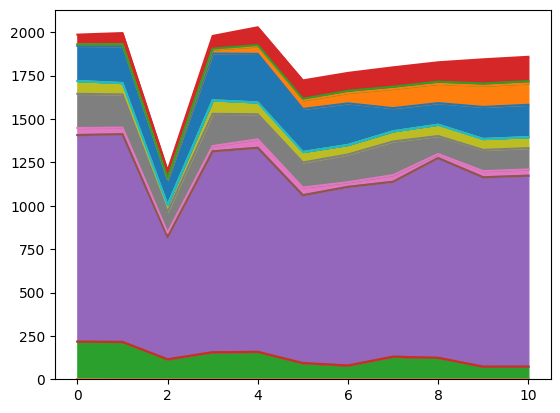

In [66]:
df_try[[x for x in df_try.columns if "nemomod_entc_annual_production_by_technology_pp" in x]].plot.area(legend = False)

                                                                                                        
                                                                                                        

<Axes: >

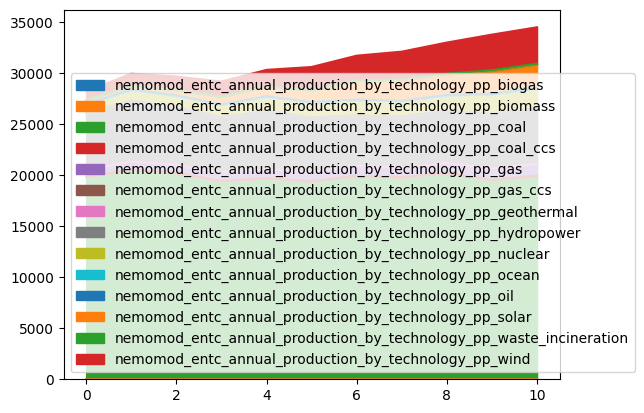

In [1881]:
df_try[[x for x in df_try.columns if "nemomod_entc_annual_production_by_technology_pp" in x]].plot.area(legend = True)

In [1880]:
_UM_ENERGY.convert("gwy", "pj")
[x for x in _DF_CALIB.columns if "transmission" in x]
_DF_CALIB["frac_enfu_transmission_loss_fuel_electricity"]

0     0.057835
1     0.057835
2     0.057835
3     0.057835
4     0.057835
5     0.057835
6     0.057835
7     0.057835
8     0.057835
9     0.057835
10    0.057835
11    0.057835
12    0.057835
13    0.057835
14    0.057835
15    0.057835
16    0.057835
17    0.057835
18    0.057835
19    0.057835
20    0.057835
21    0.057835
22    0.057835
23    0.057835
24    0.057835
25    0.057835
26    0.057835
27    0.057835
28    0.057835
29    0.057835
30    0.057835
31    0.057835
32    0.057835
33    0.057835
34    0.057835
35    0.057835
36    0.057835
37    0.057835
38    0.057835
39    0.057835
40    0.057835
41    0.057835
42    0.057835
43    0.057835
44    0.057835
45    0.057835
46    0.057835
47    0.057835
48    0.057835
49    0.057835
50    0.057835
51    0.057835
52    0.057835
53    0.057835
54    0.057835
55    0.057835
Name: frac_enfu_transmission_loss_fuel_electricity, dtype: float64

In [1886]:
fields = [x for x in df_try if ("nemomod_entc_total_annual_generation_capacity_pp" in x)]
df_try[fields].iloc[8].sum()


np.float64(3021.190064133309)

In [1874]:
fields = [x for x in _DF_CALIB if ("emission" in x) and ("_pp_" in x)]
_DF_CALIB[fields].iloc[8]

nemomod_entc_emissions_activity_ratio_scalar_pp_biogas_ch4                1.0
nemomod_entc_emissions_activity_ratio_scalar_pp_biogas_co2                1.0
nemomod_entc_emissions_activity_ratio_scalar_pp_biogas_n2o                1.0
nemomod_entc_emissions_activity_ratio_scalar_pp_biomass_ch4               1.0
nemomod_entc_emissions_activity_ratio_scalar_pp_biomass_co2               1.0
nemomod_entc_emissions_activity_ratio_scalar_pp_biomass_n2o               1.0
nemomod_entc_emissions_activity_ratio_scalar_pp_coal_ccs_ch4              1.0
nemomod_entc_emissions_activity_ratio_scalar_pp_coal_ccs_co2              0.1
nemomod_entc_emissions_activity_ratio_scalar_pp_coal_ccs_n2o              1.0
nemomod_entc_emissions_activity_ratio_scalar_pp_coal_ch4                  1.0
nemomod_entc_emissions_activity_ratio_scalar_pp_coal_co2                  1.0
nemomod_entc_emissions_activity_ratio_scalar_pp_coal_n2o                  1.0
nemomod_entc_emissions_activity_ratio_scalar_pp_gas_ccs_ch4     

In [1867]:
fields = [x for x in _DF_CALIB if x.startswith("efficfactor_entc_technology_fuel_use_pp")]
_DF_CALIB[fields]



,efficfactor_entc_technology_fuel_use_pp_biogas,efficfactor_entc_technology_fuel_use_pp_biomass,efficfactor_entc_technology_fuel_use_pp_coal,efficfactor_entc_technology_fuel_use_pp_coal_ccs,efficfactor_entc_technology_fuel_use_pp_gas,efficfactor_entc_technology_fuel_use_pp_gas_ccs,efficfactor_entc_technology_fuel_use_pp_geothermal,efficfactor_entc_technology_fuel_use_pp_hydropower,efficfactor_entc_technology_fuel_use_pp_nuclear,efficfactor_entc_technology_fuel_use_pp_ocean,efficfactor_entc_technology_fuel_use_pp_oil,efficfactor_entc_technology_fuel_use_pp_solar,efficfactor_entc_technology_fuel_use_pp_waste_incineration,efficfactor_entc_technology_fuel_use_pp_wind
0,0.335,0.4,0.45,0.45,0.4,0.4,1.0,1.0,0.0027,1.0,0.4,1.0,0.4,1.0
1,0.335,0.4,0.45,0.45,0.4,0.4,1.0,1.0,0.0027,1.0,0.4,1.0,0.4,1.0
2,0.335,0.4,0.45,0.45,0.4,0.4,1.0,1.0,0.0027,1.0,0.4,1.0,0.4,1.0
3,0.335,0.4,0.45,0.45,0.4,0.4,1.0,1.0,0.0027,1.0,0.4,1.0,0.4,1.0
4,0.335,0.4,0.45,0.45,0.4,0.4,1.0,1.0,0.0027,1.0,0.4,1.0,0.4,1.0
5,0.335,0.4,0.45,0.45,0.4,0.4,1.0,1.0,0.0027,1.0,0.4,1.0,0.4,1.0
6,0.335,0.4,0.45,0.45,0.4,0.4,1.0,1.0,0.0027,1.0,0.4,1.0,0.4,1.0
7,0.335,0.4,0.45,0.45,0.4,0.4,1.0,1.0,0.0027,1.0,0.4,1.0,0.4,1.0
8,0.335,0.4,0.45,0.45,0.4,0.4,1.0,1.0,0.0027,1.0,0.4,1.0,0.4,1.0
9,0.335,0.4,0.45,0.45,0.4,0.4,1.0,1.0,0.0027,1.0,0.4,1.0,0.4,1.0


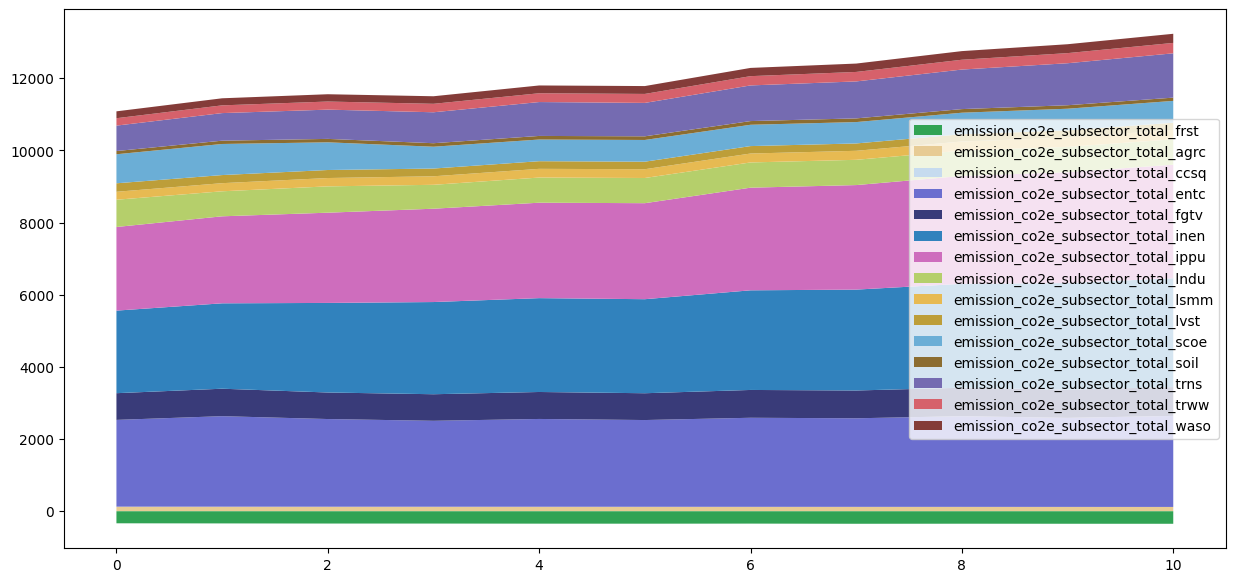

In [1863]:
fig, ax = plt.subplots(figsize = (15, 7))
svp.plot_emissions_stack(df_try, matt, figtuple = (fig, ax), )
ax.legend()


# entc needs to increase by 2.5x (these numbers don't make a lot of sense)



In [1852]:
_DF_CALIB[[x for x in _DF_CALIB.columns if "residual" in x]].sum(axis = 1)



0     1619.480000
1     1749.872000
2     1824.130000
3     1952.048000
4     2064.680000
5     2258.250000
6     2422.310000
7     2418.687175
8     2406.332752
9     2400.892789
10    2394.983524
11    2379.861555
12    2375.233712
13    2363.483181
14    2349.116342
15    2327.034638
16    2311.869861
17    2301.239473
18    2294.911112
19    2284.492298
20    2279.631917
21    2260.522991
22    2244.513064
23    2233.249100
24    2218.675356
25    2203.282516
26    2100.846645
27    2087.031817
28    2085.111623
29    2069.861054
30    2051.589262
31    2031.532923
32    2017.069810
33    1974.954140
34    1953.021648
35    1909.577698
36    1862.492425
37    1776.703791
38    1725.668908
39    1642.838077
40    1584.268634
41    1584.268634
42    1584.268634
43    1584.268634
44    1584.268634
45    1584.268634
46    1584.268634
47    1584.268634
48    1584.268634
49    1584.268634
50    1584.268634
51    1584.268634
52    1584.268634
53    1584.268634
54    1584.268634
55    1584

In [1681]:
#_MODVAR_MSP.get_from_dataframe(_DF_CALIB)
_MODVAR_ENTC_EFF_FU = matt.get_variable("Technology Efficiency of Fuel Use")
_MODVAR_ENTC_EFF_FU.get_from_dataframe(_DF_CALIB)


,efficfactor_entc_technology_fuel_use_pp_biogas,efficfactor_entc_technology_fuel_use_pp_biomass,efficfactor_entc_technology_fuel_use_pp_coal,efficfactor_entc_technology_fuel_use_pp_coal_ccs,efficfactor_entc_technology_fuel_use_pp_gas,efficfactor_entc_technology_fuel_use_pp_gas_ccs,efficfactor_entc_technology_fuel_use_pp_geothermal,efficfactor_entc_technology_fuel_use_pp_hydropower,efficfactor_entc_technology_fuel_use_pp_nuclear,efficfactor_entc_technology_fuel_use_pp_ocean,efficfactor_entc_technology_fuel_use_pp_oil,efficfactor_entc_technology_fuel_use_pp_solar,efficfactor_entc_technology_fuel_use_pp_waste_incineration,efficfactor_entc_technology_fuel_use_pp_wind,efficfactor_entc_technology_fuel_use_st_batteries,efficfactor_entc_technology_fuel_use_st_compressed_air,efficfactor_entc_technology_fuel_use_st_flywheels,efficfactor_entc_technology_fuel_use_st_pumped_hydro
0,0.335,0.4,0.45,0.45,0.4,0.4,1.0,1.0,0.0027,1.0,0.4,1.0,0.4,1.0,0.8,0.75,0.85,0.75
1,0.335,0.4,0.45,0.45,0.4,0.4,1.0,1.0,0.0027,1.0,0.4,1.0,0.4,1.0,0.8,0.75,0.85,0.75
2,0.335,0.4,0.45,0.45,0.4,0.4,1.0,1.0,0.0027,1.0,0.4,1.0,0.4,1.0,0.8,0.75,0.85,0.75
3,0.335,0.4,0.45,0.45,0.4,0.4,1.0,1.0,0.0027,1.0,0.4,1.0,0.4,1.0,0.8,0.75,0.85,0.75
4,0.335,0.4,0.45,0.45,0.4,0.4,1.0,1.0,0.0027,1.0,0.4,1.0,0.4,1.0,0.8,0.75,0.85,0.75
5,0.335,0.4,0.45,0.45,0.4,0.4,1.0,1.0,0.0027,1.0,0.4,1.0,0.4,1.0,0.8,0.75,0.85,0.75
6,0.335,0.4,0.45,0.45,0.4,0.4,1.0,1.0,0.0027,1.0,0.4,1.0,0.4,1.0,0.8,0.75,0.85,0.75
7,0.335,0.4,0.45,0.45,0.4,0.4,1.0,1.0,0.0027,1.0,0.4,1.0,0.4,1.0,0.8,0.75,0.85,0.75
8,0.335,0.4,0.45,0.45,0.4,0.4,1.0,1.0,0.0027,1.0,0.4,1.0,0.4,1.0,0.8,0.75,0.85,0.75
9,0.335,0.4,0.45,0.45,0.4,0.4,1.0,1.0,0.0027,1.0,0.4,1.0,0.4,1.0,0.8,0.75,0.85,0.75


In [1682]:
dict_kwargs = {"category_restrictions": ["fuel_electricity"]}
fields_check_elec = _MODVAR_ENFU_DEMAND_INEN.build_fields(**dict_kwargs, ) 
fields_check_elec += _MODVAR_ENFU_DEMAND_SCOE.build_fields(**dict_kwargs, )
fields_check_elec += _MODVAR_ENFU_DEMAND_TRNS.build_fields(**dict_kwargs, )

fields_ext = _MODVAR_ENFU_DEMAND_TOTAL.build_fields(**dict_kwargs, )


In [1685]:
df_try[fields_ext]

,energy_demand_enfu_total_fuel_electricity
0,16915.904882
1,17915.805421
2,17273.056619
3,16291.487223
4,16767.770653
5,16717.146142
6,17091.954026
7,17286.228036
8,17698.700638
9,18079.057729


<Axes: >

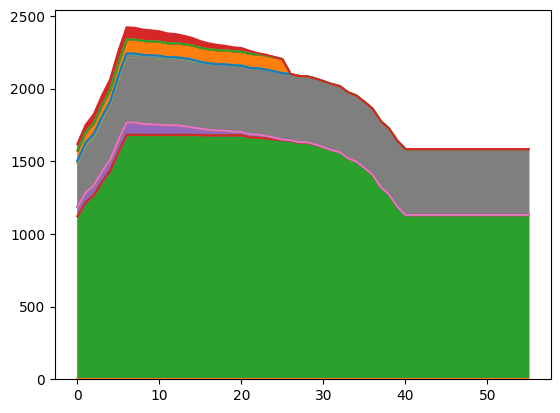

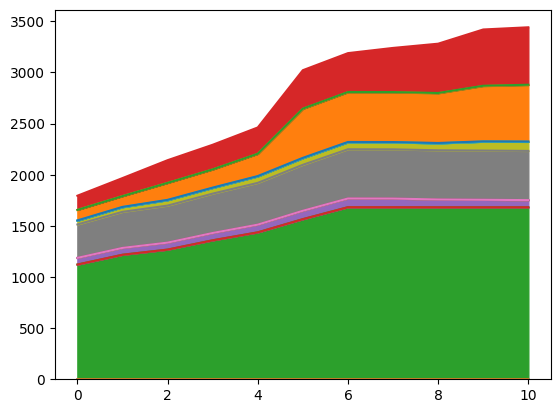

In [1101]:



_MODVAR_ENTC_RC.get_from_dataframe(_DF_CALIB).plot.area(legend = False)

fields = [x for x in _MODVAR_ENTC_GC.fields if "_pp_" in x]
df_try.get(fields).plot.area(legend = False)




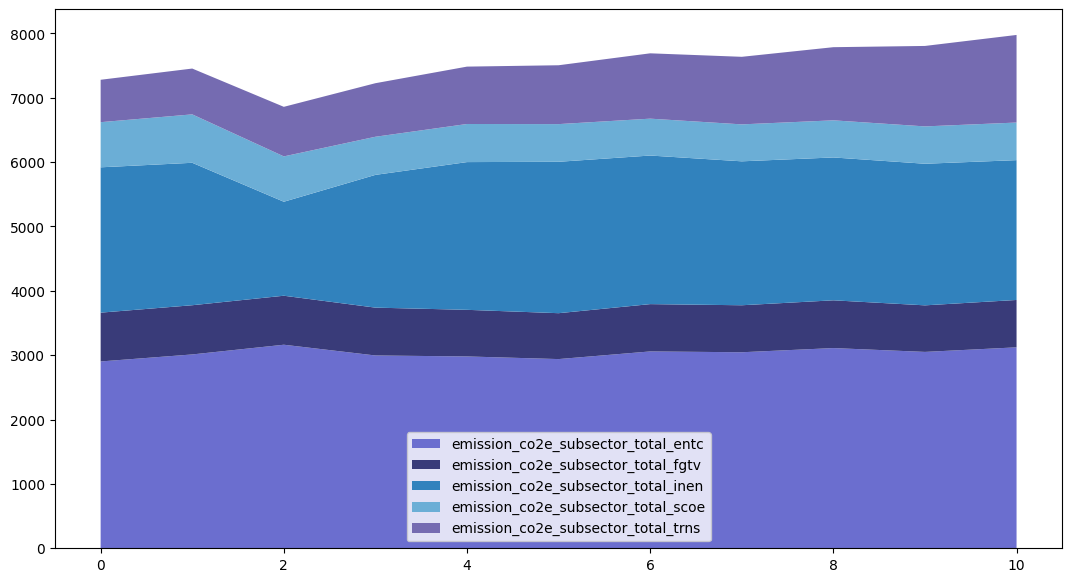

In [1111]:
fig, ax = plt.subplots(figsize = (13, 7))
svp.plot_emissions_stack(
    df_try.get(
        [
            "emission_co2e_subsector_total_entc",
            "emission_co2e_subsector_total_fgtv",
            "emission_co2e_subsector_total_scoe",
            "emission_co2e_subsector_total_trns",
            "emission_co2e_subsector_total_inen"
            
        ]
    ),
    matt,
    figtuple = (fig, ax),
)

ax.legend()

In [1133]:
#_MODVAR_ENTC_AFSCALAR.fields


In [1088]:
[
    x for x in df_try.columns if True
    and ("emission_co2e" in x)
    and ("coal" in x) 
    and (("entc" in x) or ("inen" in x))
]

['emission_co2e_ch4_entc_fuel_mining_and_extraction_me_coal',
 'emission_co2e_ch4_entc_generation_pp_coal',
 'emission_co2e_ch4_entc_generation_pp_coal_ccs',
 'emission_co2e_co2_entc_generation_pp_coal',
 'emission_co2e_co2_entc_generation_pp_coal_ccs',
 'emission_co2e_co2_entc_mining_and_extraction_me_coal',
 'emission_co2e_n2o_entc_fuel_mining_and_extraction_me_coal',
 'emission_co2e_n2o_entc_generation_pp_coal',
 'emission_co2e_n2o_entc_generation_pp_coal_ccs']

In [1074]:
_MODVAR_ENTC_GC.get_from_dataframe(df_try)#.plot.area(legend = False)

,nemomod_entc_total_annual_generation_capacity_pp_biogas,nemomod_entc_total_annual_generation_capacity_pp_biomass,nemomod_entc_total_annual_generation_capacity_pp_coal,nemomod_entc_total_annual_generation_capacity_pp_coal_ccs,nemomod_entc_total_annual_generation_capacity_pp_gas,nemomod_entc_total_annual_generation_capacity_pp_gas_ccs,nemomod_entc_total_annual_generation_capacity_pp_geothermal,nemomod_entc_total_annual_generation_capacity_pp_hydropower,nemomod_entc_total_annual_generation_capacity_pp_nuclear,nemomod_entc_total_annual_generation_capacity_pp_ocean,nemomod_entc_total_annual_generation_capacity_pp_oil,nemomod_entc_total_annual_generation_capacity_pp_solar,nemomod_entc_total_annual_generation_capacity_pp_waste_incineration,nemomod_entc_total_annual_generation_capacity_pp_wind,nemomod_entc_total_annual_generation_capacity_st_batteries,nemomod_entc_total_annual_generation_capacity_st_compressed_air,nemomod_entc_total_annual_generation_capacity_st_flywheels,nemomod_entc_total_annual_generation_capacity_st_pumped_hydro
0,0.000000,0.0,1121.789419,0.0,65.223976,0.0,0.036125,326.737551,37.048884,0.003873,2.442810,103.089232,0.000000,138.344892,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10
1,0.000000,0.0,1217.609748,0.0,66.821022,0.0,0.036346,352.624533,45.802136,0.005315,2.505515,105.606987,0.000000,176.224834,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10
2,0.007709,0.0,1267.994032,0.0,68.140639,0.0,0.036382,361.976954,53.477535,0.005315,2.552427,165.718053,0.447728,221.798668,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10
3,0.015766,0.0,1358.910747,0.0,71.366619,0.0,0.049741,384.918348,55.897553,0.005554,2.665959,177.674904,0.932398,240.564376,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10
4,0.024095,0.0,1436.607336,0.0,75.362926,0.0,0.049823,408.317957,63.618916,0.005753,2.773939,217.256326,1.448899,256.680950,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10
5,0.032366,0.0,1565.653331,0.0,81.988329,0.0,0.049957,449.448719,64.842104,0.005973,2.951914,479.447625,1.960336,375.683327,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10
6,0.040798,0.0,1682.491670,0.0,85.159551,0.0,0.050079,481.136641,68.197041,0.005973,3.114497,486.151811,2.554120,380.061543,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10
7,0.041135,0.0,1682.491670,0.0,84.449607,0.0,0.050079,481.136641,68.290712,0.006252,3.114497,486.151811,2.602064,431.544504,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10
8,0.041754,0.0,1681.883902,0.0,75.873915,0.0,0.048317,481.136641,68.325213,0.006252,3.114497,486.151811,2.689322,481.959485,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10
9,0.042304,0.0,1681.883902,0.0,73.088752,0.0,0.048359,481.136641,86.940559,0.007057,3.114497,541.026901,2.769989,550.114148,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10


# Shift around fuels

In [975]:
"""

# UNIQUE TO CHINA--ADD SOME NATURAL GAS IN TRANSPORT? 

cat = "road_heavy_freight"
fuel_in = "fuel_natural_gas"
fuel_out = "fuel_diesel"
key_fuel_fraction = "fuel_fraction"

modvar_in = matt.get_variable(
    _DICT_SUBSEC_TO_DICT_FUEL_TO_MODVAR.get(matt.subsec_name_trns)
    .get(fuel_in)
    .get(key_fuel_fraction)
)

modvar_out = matt.get_variable(
    _DICT_SUBSEC_TO_DICT_FUEL_TO_MODVAR.get(matt.subsec_name_trns)
    .get(fuel_out)
    .get(key_fuel_fraction)
)

field_in = modvar_in.build_fields(category_restrictions = cat, )
field_out = modvar_out.build_fields(category_restrictions = cat, )

#_DF_CALIB[[field_in, field_out]]
""";


In [942]:
df_test = models.project(
    df_candidate,
    include_electricity_in_energy = False,
)
modvar = _DICT_ALLOCATION_INFO.get(key)[1]
modvar.get_from_dataframe(df_test, ).iloc[8].sum()

np.float64(5068.604881643322)

In [939]:
modvar.get_from_dataframe(df_out_preliminary, ).iloc[8].sum()

np.float64(21740.817644043767)

In [941]:
df = _DICT_DFS_IEA.get("transport")
df[df["Year"].isin([2023])]["Value"].sum()/1000

np.float64(15725.536)

In [847]:
l = sorted(list(_DICT_ALLOCATION_INFO.keys()))
k = l[0]
print(k)

_, modvar, _ = _DICT_ALLOCATION_INFO.get(k)

matt.get_variable_subsector(modvar)


commercial and public services


'Energy Fuels'

In [836]:
df_input[fields].head()

,frac_scoe_heat_energy_commercial_municipal_coal,frac_scoe_heat_energy_commercial_municipal_diesel,frac_scoe_heat_energy_commercial_municipal_electricity,frac_scoe_heat_energy_commercial_municipal_gasoline,frac_scoe_heat_energy_commercial_municipal_hydrocarbon_gas_liquids,frac_scoe_heat_energy_commercial_municipal_hydrogen,frac_scoe_heat_energy_commercial_municipal_kerosene,frac_scoe_heat_energy_commercial_municipal_natural_gas,frac_scoe_heat_energy_commercial_municipal_solid_biomass
0,0.01319,0.183107,0.139854,0.022888,0.018486,0.0,0.022888,0.556753,0.042833
1,0.01319,0.183107,0.139854,0.022888,0.018486,0.0,0.022888,0.556753,0.042833
2,0.01319,0.183107,0.139854,0.022888,0.018486,0.0,0.022888,0.556753,0.042833
3,0.01319,0.183107,0.139854,0.022888,0.018486,0.0,0.022888,0.556753,0.042833
4,0.01319,0.183107,0.139854,0.022888,0.018486,0.0,0.022888,0.556753,0.042833


In [835]:
df_candidate[fields].head()

['frac_scoe_heat_energy_commercial_municipal_coal',
 'frac_scoe_heat_energy_commercial_municipal_diesel',
 'frac_scoe_heat_energy_commercial_municipal_electricity',
 'frac_scoe_heat_energy_commercial_municipal_gasoline',
 'frac_scoe_heat_energy_commercial_municipal_hydrocarbon_gas_liquids',
 'frac_scoe_heat_energy_commercial_municipal_hydrogen',
 'frac_scoe_heat_energy_commercial_municipal_kerosene',
 'frac_scoe_heat_energy_commercial_municipal_natural_gas',
 'frac_scoe_heat_energy_commercial_municipal_solid_biomass']

In [771]:
fields = [x for x in df_input.columns if "frac_scoe_heat_energy_commercial_municipal" in x]

In [781]:
_DICT_FUEL_SCALARS_BY_IEA_SUBSEC

{'commercial and public services': {'fuel_biofuels': 0,
  'fuel_biogas': 0,
  'fuel_biomass': 0,
  'fuel_coal': 29.145715127856572,
  'fuel_coke': 0,
  'fuel_crude': 0,
  'fuel_diesel': 4.001490670644376,
  'fuel_electricity': 0.7064763729060429,
  'fuel_furnace_gas': 0,
  'fuel_gasoline': 4.001490670644377,
  'fuel_geothermal': 0,
  'fuel_hydrocarbon_gas_liquids': 0,
  'fuel_hydrogen': 0,
  'fuel_kerosene': 4.001490670644377,
  'fuel_natural_gas': 1.6867924229104763,
  'fuel_nuclear': 0,
  'fuel_ocean': 0,
  'fuel_oil': 0,
  'fuel_other': 0,
  'fuel_solar': 0,
  'fuel_waste': 0,
  'fuel_water': 0,
  'fuel_wind': 0},
 'industry': {'fuel_biofuels': 0,
  'fuel_biogas': 0,
  'fuel_biomass': 0.023284161658524913,
  'fuel_coal': 5.90567632000762,
  'fuel_coke': 0,
  'fuel_crude': 0,
  'fuel_diesel': 0.3442506661151789,
  'fuel_electricity': 5.907424001102269,
  'fuel_furnace_gas': 0,
  'fuel_gasoline': 0.3442506661151789,
  'fuel_geothermal': 0,
  'fuel_hydrocarbon_gas_liquids': 0,
  'fuel_

In [244]:


df_tr = tmts.trs.tbg.transformation_general(
    df_peru,
    matt,
    {
        ssp.models.model_enercons.modvar_enfu_exports_fuel: {
            "bounds": (-1, np.inf),
            "categories": ["fuel_natural_gas"],
            "magnitude": 1.8,
            "magnitude_type": "baseline_scalar",
            "vec_ramp": transformers.vec_implementation_ramp
        },
    },
    field_region = "region",
    strategy_id = 18,s
)
df_tr["exports_enfu_pj_fuel_natural_gas"]


0     200.951000
1     241.012000
2     228.888000
3     241.012000
4     241.012000
5     241.012000
6     247.438987
7     253.865973
8     260.292960
9     266.719947
10    273.146933
11    279.573920
12    286.000907
13    292.427893
14    298.854880
15    305.281867
16    311.708853
17    318.135840
18    324.562827
19    330.989813
20    337.416800
21    343.843787
22    350.270773
23    356.697760
24    363.124747
25    369.551733
26    375.978720
27    382.405707
28    388.832693
29    395.259680
30    401.686667
31    408.113653
32    414.540640
33    420.967627
34    427.394613
35    433.821600
Name: exports_enfu_pj_fuel_natural_gas, dtype: float64

In [6]:
import sisepuede.transformers as trf
import sisepuede.transformers.transformations as tmts
importlib.reload(tmts.trs)

"""
transformers = trf.Transformers(
    {},
    df_input = df_peru,
)
"""
# initialize a transformations set
if not path_transformations.is_dir():
    trf.instantiate_default_strategy_directory(
        transformers,
        path_transformations,
    )

transformations = tmts.Transformations(
    path_transformations,
    df_input = df_peru,
)

transformers = transformations.transformers

strategies = trf.Strategies(
    transformations,
    export_path = "transformations",
    prebuild = True,
)




"""attribute_strategy_new = sf._concat_df(
    [
        strategies.attribute_table.table,
        strategies.build_whirlpool_strategies(6002, )
    ]
)

attribute_strategy_new.to_csv(
    strategies.path_strategy_definition,
    encoding = "UTF-8",
    index = None
)""";



##  WRITE SOME OBJECTS FOR USE WITH CLOUD


sf._write_csv(
    matt.get_dimensional_attribute_table(matt.dim_time_period).table,
    path_transformations.joinpath("attribute_dim_time_period.csv")
)

sf._write_csv(
    df_peru,
    path_transformations.joinpath("input_data_peru_base.csv")
)

In [35]:
strategies.get_strategy(6002).code

'PFLO:ALL'

In [47]:
nm = "lng"
path = f"/Users/usuario/git/julia_districting/julia/comms_{nm}_5.csv"
df_tmp = pd.read_csv(path)
df_tmp = df_tmp[[x for x in df_tmp.columns if len(df_tmp[x].unique()) != 1]]
sf._write_csv(df_tmp, path)

True

In [8]:
tab = strategies.attribute_table.table

# demonstrate A6
strats_run = ["BASE", "PFLO:ALL", "PFLO:NDC_2020"]
strats_run += [x for x in list(tab[strategies.field_strategy_code]) if x.startswith("AGRC:DEC_CH4_RICE")]
strats_run += [x for x in tab["strategy_code"].to_numpy() if x.startswith("PFLO:A6")]
strat_ids_a6 = sorted([strategies.get_strategy(x).id_num for x in strats_run])




In [ ]:
##  Phase 1 for transformations: run transformations one by one using defaults
- start by building all singletons to the templates to run

In [ ]:
df_in[[x for x in df_in.columns if "tag" in x]]
df_in[[x for x in df_in.columns if "min_share" in x]].head(8)


In [30]:

##  GET IN
strat_names = [
    x for x in strategies.attribute_table.table[strategies.field_strategy_name].to_numpy() 
    if x.startswith("Singleton")
]

# init
all_strategies_singleton = [strategies.baseline_id]

# add to list
for strat in strategies.all_strategies:
    nm = strategies.get_strategy(strat).name
    if nm in strat_names:
        all_strategies_singleton.append(strat)




# build templates--trajectory groups are not important right now
examples = sxl.SISEPUEDEExamples()
df_vargroups = examples("variable_trajectory_group_specification")
strategies.build_strategies_to_templates(
    #df_trajgroup = df_vargroups, 
    include_simplex_group_as_trajgroup = False,
    strategies = strat_ids_a6, # all_strategies_singleton,
)


0

In [ ]:
transformers.all_transformers

In [ ]:
##  20251020 - Build transformations for A6

In [ ]:
#### transformations.all_transformation_codes

"""Rice management
Renewable energy
Industrial EE
Electrify LDV
Mode shift freight
Stop deforestation
Increase reforestation
Reduce enteric fermentation
Improve fertilizer application
Reduce HFCs"""

transformations_build = [
    "TX:AGRC:DEC_CH4_RICE",
    "TX:ENTC:TARGET_RENEWABLE_ELEC",
    "TX:INEN:INC_EFFICIENCY_ENERGY",
    "TX:TRNS:SHIFT_FUEL_LIGHT_DUTY",
    "TX:TRNS:SHIFT_MODE_FREIGHT",
    "TX:LNDU:DEC_DEFORESTATION",
    "TX:LNDU:INC_REFORESTATION",
    "TX:LVST:DEC_ENTERIC_FERMENTATION",
    "TX:SOIL:DEC_N_APPLIED",
    "TX:IPPU:DEC_HFCS"
]

##  INITIALIZE KEY ELEMENTS

# some basic vars
delim = "|"
codes = []
descriptions = []
ids = []
names = []
specs = []

#
id_num = max(strategies.attribute_table.key_values) + 1


# reference strategy and associated specifications
dict_strat_builds = {
    "PFLO:ALL": (1, 0), 
    "PFLO:NDC_2020": (1, 1),
}
dict_strat_pack = {}


#
strats_to_build = ["PFLO:ALL", "PFLO:NDC_2020"]
for code in strats_to_build:
    # get transformaion information
    strat_ref = strategies.get_strategy(code, )
    all_transformations_ref = strat_ref.get_transformation_list(
        strat_ref.transformation_specification,
        transformations,
    )
    all_transformation_codes_ref = [x.code for x in all_transformations_ref]

    # add to dict
    tup = (strat_ref, all_transformations_ref, all_transformation_codes_ref, )
    dict_strat_pack.update({code: tup, })



# map transformer codes to all transformations
dict_transformer_code_to_transformations = transformations.get_transformation_codes_by_transformer_code()




##  ITERATE OVER TRANSFORMATIONS THAT NEED TO BE ADDED/REMOVED FROM BASE REF

for strat_build, strat_pack in dict_strat_pack.items():

    builds = dict_strat_builds.get(strat_build)
    (strat_ref, all_transformations_ref, all_transformation_codes_ref, ) = strat_pack

    
    for transformation_code in transformations_build:
    
        # check for transformations in NDC
        transformation = transformations.get_transformation(transformation_code)
        if transformation is None:
            raise RuntimeError(f"Transformation code {transformation_code} not found.")
    
    
        # get transformer and check for existing transformation in reference strategy with that code
        all_transformations_with_code = dict_transformer_code_to_transformations.get(
            transformation.transformer_code, 
        )
    
        tfmns_with_trfr_in_strat_ref = set(all_transformations_with_code) & set(all_transformation_codes_ref)
        if len(tfmns_with_trfr_in_strat_ref) == 0: continue
    
        # transformation to replace with current one (for 100%) and remove (for 0%)
        transformation_remove = list(tfmns_with_trfr_in_strat_ref)[0]
    
    
        ## build transformation WITH 100% implementation
        transformation_specification_0 = sorted([x for x in all_transformation_codes_ref if x != transformation_remove])
        transformation_specification_100 = sorted(transformation_specification_0 + [transformation_code])
        
        transformation_specification_0_str = delim.join(transformation_specification_0)
        transformation_specification_100_str = delim.join(transformation_specification_100)

        # build the 0?
        if builds[0] == 1:
            code = transformation_remove.replace(":", "")
            code = f"{strat_build}_NO_{code}"
            code = code.replace("PFLO:", "PFLO:A6_")
            name = f"A6 {strat_build} without {transformation_remove}"

            # append
            codes.append(code)
            descriptions.append(f"{name} for A6")
            ids.append(id_num)
            names.append(name)
            specs.append(transformation_specification_0_str)

            id_num += 1


        # build the 100?
        if builds[1] == 1:
            code = transformation_code.replace(":", "")
            code = f"{strat_build}_WITH_{code}"
            code = code.replace("PFLO:", "PFLO:A6_")
            name = f"A6 {strat_build} with {transformation_code}"

            # append
            codes.append(code)
            descriptions.append(f"{name} replacing {transformation_remove} for A6")
            ids.append(id_num)
            names.append(name)
            specs.append(transformation_specification_100_str)

            id_num += 1




df_additional_strategies = pd.DataFrame(
    {
        strategies.attribute_table.key: ids,
        strategies.field_baseline_strategy: np.zeros(len(specs)).astype(int),
        strategies.field_description: descriptions,
        strategies.field_strategy_code: codes,
        strategies.field_strategy_name: names,
        strategies.field_transformation_specification: specs,
    }
)




In [ ]:
attr_strat_out = strategies.attribute_table.table
attr_strat_out = sf._concat_df(
    [
        attr_strat_out,
        df_additional_strategies[attr_strat_out.columns]
    ]
)

In [ ]:
"""sf._write_csv(
    attr_strat_out,
    strategies.path_strategy_definition,
)"""

In [ ]:
# Next, build a SISEPUEDE object and load strategies

In [7]:
import sisepuede as si

ssp = si.SISEPUEDE(
    "calibrated",
    db_type = "csv",
    #id_str = "sisepuede_run_2025-10-23T16:31:38.101072",
    initialize_as_dummy = False,
    regions = [_REGION_NAME],
    strategies = strategies,
    #try_exogenous_xl_types_in_variable_specification = True,
)





2025-11-13 02:58:47,885 - INFO - Successfully initialized SISEPUEDEFileStructure.
2025-11-13 02:58:47,886 - WARNING - Missing key dict_dimensional_keys: key time_series not found. Tables that rely on the time_series will not have index checking.
2025-11-13 02:58:47,887 - INFO - 	Setting export engine to 'csv'.
2025-11-13 02:58:47,887 - WARNING - No index fields defined. Index field values will not be checked when writing to tables.
2025-11-13 02:58:47,887 - INFO - Successfully instantiated table ANALYSIS_METADATA
2025-11-13 02:58:47,888 - WARNING - No index fields found in ATTRIBUTE_DESIGN. Initializing index fields.
2025-11-13 02:58:47,888 - INFO - Successfully instantiated table ATTRIBUTE_DESIGN
2025-11-13 02:58:47,888 - WARNING - No index fields found in ATTRIBUTE_LHC_SAMPLES_EXOGENOUS_UNCERTAINTIES. Initializing index fields.
2025-11-13 02:58:47,889 - INFO - Successfully instantiated table ATTRIBUTE_LHC_SAMPLES_EXOGENOUS_UNCERTAINTIES
2025-11-13 02:58:47,889 - WARNING - No index fi

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


Precompiling NemoMod...
Info Given NemoMod was explicitly requested, output will be shown live 
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
   2032.8 ms  ? NemoMod
[ Info: Precompiling NemoMod [a3c327a0-d2f0-11e8-37fd-d12fd35c3c72] 
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
┌ Info: Skipping precompilation due to precompilable error. Importing NemoMod [a3c327a0-d2f0-11e8-37fd-d12fd35c3c72].
└   exception = Error when precompiling module, potentially caused by a __precompile__(false) declaration in the module.
2025-11-13 02:59:52,534 - INFO - Successfully initialized JuMP optimizer from solver module HiGHS.
2025-11-13 02:59:52,549 - INFO - Successfully initialized SISEPUEDEModels.
2025-11-13 02:59:52,555 - INFO - Table ANALYSIS_METADATA successfully written to /Users/usuario/git/sisepuede/sisepuede/out/sisepuede_ru

In [ ]:
tx_all = "TX:AGRC:DEC_CH4_RICE_NDC2020_EST|TX:AGRC:DEC_EXPORTS_NDC2020_EST|TX:AGRC:DEC_LOSSES_SUPPLY_CHAIN_NDC2020_EST|TX:AGRC:INC_CONSERVATION_AGRICULTURE_NDC2020_EST|TX:AGRC:INC_PRODUCTIVITY_NDC2020_EST|TX:CCSQ:INC_CAPTURE_NDC2020_EST|TX:ENTC:DEC_LOSSES_NDC2020_EST|TX:ENTC:TARGET_CLEAN_HYDROGEN_NDC2020_EST|TX:ENTC:TARGET_RENEWABLE_ELEC_NDC2020_EST|TX:FGTV:DEC_LEAKS_NDC2020_EST|TX:FGTV:INC_FLARE_NDC2020_EST|TX:INEN:INC_EFFICIENCY_ENERGY_NDC2020_EST|TX:INEN:INC_EFFICIENCY_PRODUCTION_NDC2020_EST|TX:INEN:SHIFT_FUEL_HEAT_NDC2020_EST|TX:IPPU:DEC_CLINKER_NDC2020_EST|TX:IPPU:DEC_DEMAND_NDC2020_EST|TX:IPPU:DEC_HFCS_NDC2020_EST|TX:IPPU:DEC_N2O_NDC2020_EST|TX:IPPU:DEC_OTHER_FCS_NDC2020_EST|TX:IPPU:DEC_PFCS_NDC2020_EST|TX:LNDU:DEC_DEFORESTATION_NDC2020_EST|TX:LNDU:DEC_SOC_LOSS_PASTURES_NDC2020_EST|TX:LNDU:INC_REFORESTATION_NDC2020_EST|TX:LNDU:INC_SILVOPASTURE_NDC2020_EST|TX:LNDU:PLUR_NDC2020_EST|TX:LSMM:INC_CAPTURE_BIOGAS_NDC2020_EST|TX:LVST:DEC_ENTERIC_FERMENTATION_NDC2020_EST|TX:LVST:DEC_EXPORTS_NDC2020_EST|TX:LVST:INC_PRODUCTIVITY_NDC2020_EST|TX:SCOE:DEC_DEMAND_HEAT_NDC2020_EST|TX:SCOE:INC_EFFICIENCY_APPLIANCE_NDC2020_EST|TX:SCOE:SHIFT_FUEL_HEAT_NDC2020_EST|TX:SOIL:DEC_LIME_APPLIED_NDC2020_EST|TX:SOIL:DEC_N_APPLIED_NDC2020_EST|TX:TRDE:DEC_DEMAND_NDC2020_EST|TX:TRNS:INC_EFFICIENCY_ELECTRIC_NDC2020_EST|TX:TRNS:INC_EFFICIENCY_NON_ELECTRIC_NDC2020_EST|TX:TRNS:INC_OCCUPANCY_LIGHT_DUTY_NDC2020_EST|TX:TRNS:SHIFT_FUEL_LIGHT_DUTY_NDC2020_EST|TX:TRNS:SHIFT_FUEL_MARITIME_NDC2020_EST|TX:TRNS:SHIFT_FUEL_MEDIUM_DUTY_NDC2020_EST|TX:TRNS:SHIFT_FUEL_RAIL_NDC2020_EST|TX:TRNS:SHIFT_MODE_FREIGHT_NDC2020_EST|TX:TRNS:SHIFT_MODE_PASSENGER_NDC2020_EST|TX:TRWW:INC_CAPTURE_BIOGAS_NDC2020_EST|TX:TRWW:INC_COMPLIANCE_SEPTIC_NDC2020_EST|TX:WALI:INC_TREATMENT_RURAL_NDC2020_EST|TX:WALI:INC_TREATMENT_URBAN_NDC2020_EST|TX:WASO:DEC_CONSUMER_FOOD_WASTE_NDC2020_EST|TX:WASO:INC_ANAEROBIC_AND_COMPOST_NDC2020_EST|TX:WASO:INC_CAPTURE_BIOGAS_NDC2020_EST|TX:WASO:INC_ENERGY_FROM_BIOGAS_NDC2020_EST|TX:WASO:INC_ENERGY_FROM_INCINERATION_NDC2020_EST|TX:WASO:INC_LANDFILLING_NDC2020_EST|TX:WASO:INC_RECYCLING_NDC2020_EST"
tx_a6 = "TX:AGRC:DEC_CH4_RICE_P10|TX:AGRC:DEC_EXPORTS_NDC2020_EST|TX:AGRC:DEC_LOSSES_SUPPLY_CHAIN_NDC2020_EST|TX:AGRC:INC_CONSERVATION_AGRICULTURE_NDC2020_EST|TX:AGRC:INC_PRODUCTIVITY_NDC2020_EST|TX:CCSQ:INC_CAPTURE_NDC2020_EST|TX:ENTC:DEC_LOSSES_NDC2020_EST|TX:ENTC:TARGET_CLEAN_HYDROGEN_NDC2020_EST|TX:ENTC:TARGET_RENEWABLE_ELEC_NDC2020_EST|TX:FGTV:DEC_LEAKS_NDC2020_EST|TX:FGTV:INC_FLARE_NDC2020_EST|TX:INEN:INC_EFFICIENCY_ENERGY_NDC2020_EST|TX:INEN:INC_EFFICIENCY_PRODUCTION_NDC2020_EST|TX:INEN:SHIFT_FUEL_HEAT_NDC2020_EST|TX:IPPU:DEC_CLINKER_NDC2020_EST|TX:IPPU:DEC_DEMAND_NDC2020_EST|TX:IPPU:DEC_HFCS_NDC2020_EST|TX:IPPU:DEC_N2O_NDC2020_EST|TX:IPPU:DEC_OTHER_FCS_NDC2020_EST|TX:IPPU:DEC_PFCS_NDC2020_EST|TX:LNDU:DEC_DEFORESTATION_NDC2020_EST|TX:LNDU:DEC_SOC_LOSS_PASTURES_NDC2020_EST|TX:LNDU:INC_REFORESTATION_NDC2020_EST|TX:LNDU:INC_SILVOPASTURE_NDC2020_EST|TX:LNDU:PLUR_NDC2020_EST|TX:LSMM:INC_CAPTURE_BIOGAS_NDC2020_EST|TX:LVST:DEC_ENTERIC_FERMENTATION_NDC2020_EST|TX:LVST:DEC_EXPORTS_NDC2020_EST|TX:LVST:INC_PRODUCTIVITY_NDC2020_EST|TX:SCOE:DEC_DEMAND_HEAT_NDC2020_EST|TX:SCOE:INC_EFFICIENCY_APPLIANCE_NDC2020_EST|TX:SCOE:SHIFT_FUEL_HEAT_NDC2020_EST|TX:SOIL:DEC_LIME_APPLIED_NDC2020_EST|TX:SOIL:DEC_N_APPLIED_NDC2020_EST|TX:TRDE:DEC_DEMAND_NDC2020_EST|TX:TRNS:INC_EFFICIENCY_ELECTRIC_NDC2020_EST|TX:TRNS:INC_EFFICIENCY_NON_ELECTRIC_NDC2020_EST|TX:TRNS:INC_OCCUPANCY_LIGHT_DUTY_NDC2020_EST|TX:TRNS:SHIFT_FUEL_LIGHT_DUTY_NDC2020_EST|TX:TRNS:SHIFT_FUEL_MARITIME_NDC2020_EST|TX:TRNS:SHIFT_FUEL_MEDIUM_DUTY_NDC2020_EST|TX:TRNS:SHIFT_FUEL_RAIL_NDC2020_EST|TX:TRNS:SHIFT_MODE_FREIGHT_NDC2020_EST|TX:TRNS:SHIFT_MODE_PASSENGER_NDC2020_EST|TX:TRWW:INC_CAPTURE_BIOGAS_NDC2020_EST|TX:TRWW:INC_COMPLIANCE_SEPTIC_NDC2020_EST|TX:WALI:INC_TREATMENT_RURAL_NDC2020_EST|TX:WALI:INC_TREATMENT_URBAN_NDC2020_EST|TX:WASO:DEC_CONSUMER_FOOD_WASTE_NDC2020_EST|TX:WASO:INC_ANAEROBIC_AND_COMPOST_NDC2020_EST|TX:WASO:INC_CAPTURE_BIOGAS_NDC2020_EST|TX:WASO:INC_ENERGY_FROM_BIOGAS_NDC2020_EST|TX:WASO:INC_ENERGY_FROM_INCINERATION_NDC2020_EST|TX:WASO:INC_LANDFILLING_NDC2020_EST|TX:WASO:INC_RECYCLING_NDC2020_EST"

l_all = tx_all.split("|")
l_a6 = tx_a6.split("|")

set(l_all) - set(l_a6)


In [ ]:
dict_strat_to_prim = sf.build_dict(
    ssp.odpt_primary.get_indexing_dataframe_from_primary_key(
        df_out[ssp.key_primary].unique()
    )
    .get(
        [
            ssp.key_strategy,
            ssp.key_primary,
        ]
    )
)

flds_all = [x for x in df_out.columns if "emission_co2e_subsector_total_" in x]
for i in range(1, 10):
    s0 = "PFLO:ALL"#"PFLO:NDC_2020"
    s1 = f"PFLO:A6_ALL_WITH_RICE_CH4_P{i}0"
    
    
    prim0 = dict_strat_to_prim.get(strategies.get_strategy(s0).id_num)
    prim1 = dict_strat_to_prim.get(strategies.get_strategy(s1).id_num)
    
    # base cases
    dfi0 = df_in[
       df_in[ssp.key_primary].isin([prim0]) 
    ]
    df0 = df_out[
       df_out[ssp.key_primary].isin([prim0]) 
    ]
    vec0 = df0[flds_all].iloc[-1].to_numpy()
    val0 = vec0.sum()

    # a6 cases
    dfi1 = df_in[
       df_in[ssp.key_primary].isin([prim1]) 
    ]
    df1 = df_out[
       df_out[ssp.key_primary].isin([prim1]) 
    ]
    vec1 = df1[flds_all].iloc[-1].to_numpy()
    val1 = vec1.sum()

    for i, val in enumerate(vec0):
        print(f"checking {i}...")
        val_compare = vec1[i]
        if val != val_compare:
            fld = flds_all[i]
            print(f"diff found in field {fld} at {i}")

    print(f"val NDC:\t\t{val0}\nval at percentile {i}:\t{val1}\n")




In [ ]:
flds_entc = [x for x in df0.columns if "emission_co2e" in x and "entc" in x]
flds_waso = [x for x in df0.columns if "emission_co2e" in x and "waso" in x]

"""
for f in df0.columns:
    if float(df0[f].iloc[-1]) != float(df1[f].iloc[-1]):
        print(f)
"""


for f in dfi0.columns:
    if f in ["region"]: continue
    if float(dfi0[f].iloc[-1]) != float(dfi1[f].iloc[-1]):
        print(f)

In [ ]:
df_

In [ ]:
strat_base = strategies.get_strategy(s0)
strat_a6 = strategies.get_strategy(s1)

set_base = strat_base.transformation_specification.split("|")
set_a6 = strat_a6.transformation_specification.split("|")

set(set_a6) - set(set_base)

In [ ]:
df_tmp0 = ssp.models(strat_base(), include_electricity_in_energy = True, )
df_tmp1 = ssp.models(strat_a6(), include_electricity_in_energy = True, )



In [ ]:
for f in df_tmp0.columns:
    if f in ["region"]: continue
    if float(df_tmp0[f].iloc[-1]) != float(df_tmp1[f].iloc[-1]):
        print(f)

In [ ]:
df_tmp0[flds_all].sum(axis = 1).iloc[-1]

In [ ]:
df_out[
   df_out[ssp.key_primary].isin([prim1]) 
][[x for x in df_out.columns if "emission_co2e_subsector_total" in x]].sum(axis = 1).tail()

In [ ]:
fields = [x for x in df_in.columns if ("ch4" in x) and ("agrc" in x) and ("rice" in x)]
df_in[
   df_in[ssp.key_primary].isin([prim1]) 
][fields]




In [ ]:
tab = ssp.database.db.dict_iterative_database_tables.get("MODEL_OUTPUT")
pathlib.Path(tab.fp_table).is_file()

In [ ]:
primary_keys = dict_run
check_results = True
chunk_size = 10
force_overwrite_existing_primary_keys = False
max_attempts = 2
regions = None
reinitialize_output_table_on_verification_failure = False
save_inputs = True
skip_nas_in_input = False
max_attempts = (
    int(min(max(max_attempts, 1), 5))
    if sf.isnumber(max_attempts)
    else 2
)
save_inputs = (
    ssp.get_config_parameter("save_inputs")
    if save_inputs is None
    else save_inputs
)

# get all scenarios and designs associated with them
primary_keys = ssp.get_primary_keys(primary_keys)
df_primary_keys = ssp.odpt_primary.get_indexing_dataframe(
    key_values = primary_keys
)
all_designs = sorted(list(set(df_primary_keys[ssp.key_design])))

# initializations
df_out = []
df_out_inputs = []
df_out_primary = []
dict_primary_keys_run = dict((x, [None for x in primary_keys]) for x in ssp.regions)
iterate_outer = 0

# available indices and resolution
idt = ssp.database.db.dict_iterative_database_tables.get(
    ssp.database.table_name_output
)
index_conflict_resolution = None
index_conflict_resolution = (
    "write_replace" 
    if (force_overwrite_existing_primary_keys or (idt.index_conflict_resolution == "write_replace")) 
    else None
)
set_available_ids = idt.available_indices

# check regions specification
regions = (
    [x for x in ssp.regions if x in regions]
    if sf.islistlike(regions)
    else None
)
regions = ssp.regions if (regions is None) else regions



region = regions[0]

iterate_inner = 0

# retrieve region specific future trajectories and lhs design
future_trajectories_cur = ssp.experimental_manager.dict_future_trajectories.get(region)
lhs_design_cur = ssp.experimental_manager.dict_lhs_design.get(region)
region_out = ssp.get_output_region(region)

#self._log(f"\n***\tSTARTING REGION {region}\t***\n", type_log = "info")



design = all_designs[0]

df_lhs_l, df_lhs_x = lhs_design_cur.retrieve_lhs_tables_by_design(
    design,
    return_type = pd.DataFrame
)

# get reduced set of primary keys
df_primary_keys_cur_design = df_primary_keys[
    df_primary_keys[ssp.key_design] == design
]
keep_futures = sorted(list(set(df_primary_keys_cur_design[ssp.key_future])))

# reduce lhs tables - LEs
df_lhs_l = (
    df_lhs_l[
        df_lhs_l[ssp.key_future].isin(keep_futures)
    ] 
    if (df_lhs_l is not None) 
    else df_lhs_l
)
# Xs
df_lhs_x = (
    df_lhs_x[
        df_lhs_x[ssp.key_future].isin(keep_futures)
    ] 
    if (df_lhs_x is not None) 
    else df_lhs_x
)



future = keep_futures[0]


# determine if baseline future and fetch lhs rows
base_future_q = (future == ssp.baseline_future)
lhs_l = (
    df_lhs_l[df_lhs_l[ssp.key_future] == future].iloc[0] 
    if ((df_lhs_l is not None) and not base_future_q) 
    else None
)
lhs_x = (
    df_lhs_x[df_lhs_x[ssp.key_future] == future].iloc[0] 
    if ((df_lhs_x is not None) and not base_future_q) 
    else None
)

# generate the futures and get available strategies
df_input = future_trajectories_cur.generate_future_from_lhs_vector(
    lhs_x,
    df_row_lhc_sample_l = lhs_l,
    future_id = future,
    baseline_future_q = base_future_q
)
all_strategies = sorted(list(
    set(df_input[ssp.key_strategy])
))




strategy = all_strategies[0]
# get primary id info
df_primary_keys_cur_design_fs = (
    df_primary_keys_cur_design[
        df_primary_keys_cur_design[ssp.key_future].isin([future]) &
        df_primary_keys_cur_design[ssp.key_strategy].isin([strategy])
    ]
    .reset_index(drop = True)
)

id_primary = df_primary_keys_cur_design_fs[ssp.key_primary]
id_primary = int(id_primary.iloc[0]) if (len(id_primary) > 0) else None
write_q = ((region_out, id_primary) not in set_available_ids) 
write_q |= (index_conflict_resolution == "write_replace")






In [ ]:
tab = ssp.database.db.dict_iterative_database_tables.get("MODEL_INPUT")

In [ ]:
tab = ssp.database.db.dict_iterative_database_tables.get("MODEL_OUTPUT")


In [ ]:
## then, run the strategies one by one

In [9]:



dict_run = {
    ssp.key_future: [0],
    ssp.key_design: [0],
    ssp.key_strategy: strat_ids_a6,#[0:1],
}

#primaries = [186186, 187187, 188188, 189189]
# we'll save inputs since we're doing a small set of runs 
dict_successful = ssp(
    dict_run, 
    force_overwrite_existing_primary_keys = True,
    save_inputs = True,
)

2025-11-13 02:59:59,492 - INFO - 
***	STARTING REGION peru	***

2025-11-13 03:00:01,164 - INFO - Trying run primary_id = 0 in region peru
2025-11-13 03:00:01,165 - INFO - Running AFOLU model
2025-11-13 03:00:01,406 - INFO - AFOLU model run successfully completed
2025-11-13 03:00:01,406 - INFO - Running CircularEconomy model
2025-11-13 03:00:01,432 - INFO - CircularEconomy model run successfully completed
2025-11-13 03:00:01,433 - INFO - Running IPPU model
2025-11-13 03:00:01,476 - INFO - IPPU model run successfully completed
2025-11-13 03:00:01,477 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-11-13 03:00:01,487 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2025-11-13 03:00:01,539 - INFO - EnergyConsumption without Fugitive Emissions model run successfully completed
2025-11-13 03:00:01,539 - INFO - Running Energy model (Electricity and Fuel Production: trying to ca

2025-13-Nov 03:00:01.830 Opened SQLite database at /Users/usuario/git/sisepuede/sisepuede/tmp/nemomod_intermediate_database.sqlite.
2025-13-Nov 03:00:01.975 Added NEMO structure to SQLite database at /Users/usuario/git/sisepuede/sisepuede/tmp/nemomod_intermediate_database.sqlite.
2025-13-Nov 03:00:17.358 Started modeling scenario. NEMO version = 2.2.0, solver = HiGHS.


2025-11-13 03:02:05,629 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2025-11-13 03:02:05,636 - INFO - EnergyProduction model run successfully completed
2025-11-13 03:02:05,637 - INFO - Running Energy (Fugitive Emissions)
2025-11-13 03:02:05,657 - INFO - Fugitive Emissions from Energy model run successfully completed
2025-11-13 03:02:05,658 - INFO - Appending Socioeconomic outputs
2025-11-13 03:02:05,662 - INFO - Socioeconomic outputs successfully appended.
2025-11-13 03:02:05,665 - INFO - Model run for primary_id = 0 successfully completed in 124.5 seconds (n_tries = 1).
2025-11-13 03:02:05,668 - INFO - Trying run primary_id = 1001 in region peru
2025-11-13 03:02:05,669 - INFO - Running AFOLU model


2025-13-Nov 03:00:17.831 Started optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].
2025-13-Nov 03:00:40.339 Finished optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].
2025-13-Nov 03:00:40.386 Started optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
2025-13-Nov 03:02:05.511 Finished optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


2025-11-13 03:02:05,902 - INFO - AFOLU model run successfully completed
2025-11-13 03:02:05,902 - INFO - Running CircularEconomy model
2025-11-13 03:02:05,926 - INFO - CircularEconomy model run successfully completed
2025-11-13 03:02:05,926 - INFO - Running IPPU model
2025-11-13 03:02:05,966 - INFO - IPPU model run successfully completed
2025-11-13 03:02:05,966 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-11-13 03:02:05,977 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2025-11-13 03:02:06,024 - INFO - EnergyConsumption without Fugitive Emissions model run successfully completed
2025-11-13 03:02:06,025 - INFO - Running Energy model (Electricity and Fuel Production: trying to call Julia)


2025-13-Nov 03:02:06.876 Started modeling scenario. NEMO version = 2.2.0, solver = HiGHS.
2025-13-Nov 03:02:06.932 Started optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].
2025-13-Nov 03:02:22.240 Finished optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].


2025-11-13 03:03:46,707 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2025-11-13 03:03:46,714 - INFO - EnergyProduction model run successfully completed
2025-11-13 03:03:46,715 - INFO - Running Energy (Fugitive Emissions)
2025-11-13 03:03:46,736 - INFO - Fugitive Emissions from Energy model run successfully completed
2025-11-13 03:03:46,737 - INFO - Appending Socioeconomic outputs
2025-11-13 03:03:46,741 - INFO - Socioeconomic outputs successfully appended.
2025-11-13 03:03:46,744 - INFO - Model run for primary_id = 1001 successfully completed in 101.08 seconds (n_tries = 1).
2025-11-13 03:03:46,746 - INFO - Trying run primary_id = 2002 in region peru
2025-11-13 03:03:46,750 - INFO - Running AFOLU model


2025-13-Nov 03:02:22.269 Started optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
2025-13-Nov 03:03:46.613 Finished optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


2025-11-13 03:03:46,982 - INFO - AFOLU model run successfully completed
2025-11-13 03:03:46,982 - INFO - Running CircularEconomy model
2025-11-13 03:03:47,006 - INFO - CircularEconomy model run successfully completed
2025-11-13 03:03:47,007 - INFO - Running IPPU model
2025-11-13 03:03:47,046 - INFO - IPPU model run successfully completed
2025-11-13 03:03:47,046 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-11-13 03:03:47,056 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2025-11-13 03:03:47,105 - INFO - EnergyConsumption without Fugitive Emissions model run successfully completed
2025-11-13 03:03:47,105 - INFO - Running Energy model (Electricity and Fuel Production: trying to call Julia)


2025-13-Nov 03:03:47.753 Started modeling scenario. NEMO version = 2.2.0, solver = HiGHS.
2025-13-Nov 03:03:47.801 Started optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].


2025-11-13 03:05:27,993 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2025-11-13 03:05:28,000 - INFO - EnergyProduction model run successfully completed
2025-11-13 03:05:28,001 - INFO - Running Energy (Fugitive Emissions)
2025-11-13 03:05:28,022 - INFO - Fugitive Emissions from Energy model run successfully completed
2025-11-13 03:05:28,022 - INFO - Appending Socioeconomic outputs
2025-11-13 03:05:28,027 - INFO - Socioeconomic outputs successfully appended.
2025-11-13 03:05:28,029 - INFO - Model run for primary_id = 2002 successfully completed in 101.28 seconds (n_tries = 1).
2025-11-13 03:05:28,031 - INFO - Trying run primary_id = 3003 in region peru
2025-11-13 03:05:28,032 - INFO - Running AFOLU model


2025-13-Nov 03:04:03.141 Finished optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].
2025-13-Nov 03:04:03.172 Started optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
2025-13-Nov 03:05:27.900 Finished optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


2025-11-13 03:05:28,265 - INFO - AFOLU model run successfully completed
2025-11-13 03:05:28,265 - INFO - Running CircularEconomy model
2025-11-13 03:05:28,289 - INFO - CircularEconomy model run successfully completed
2025-11-13 03:05:28,289 - INFO - Running IPPU model
2025-11-13 03:05:28,330 - INFO - IPPU model run successfully completed
2025-11-13 03:05:28,330 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-11-13 03:05:28,340 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2025-11-13 03:05:28,389 - INFO - EnergyConsumption without Fugitive Emissions model run successfully completed
2025-11-13 03:05:28,389 - INFO - Running Energy model (Electricity and Fuel Production: trying to call Julia)


2025-13-Nov 03:05:29.034 Started modeling scenario. NEMO version = 2.2.0, solver = HiGHS.
2025-13-Nov 03:05:29.082 Started optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].


2025-11-13 03:07:08,951 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2025-11-13 03:07:08,959 - INFO - EnergyProduction model run successfully completed
2025-11-13 03:07:08,959 - INFO - Running Energy (Fugitive Emissions)
2025-11-13 03:07:08,981 - INFO - Fugitive Emissions from Energy model run successfully completed
2025-11-13 03:07:08,981 - INFO - Appending Socioeconomic outputs
2025-11-13 03:07:08,987 - INFO - Socioeconomic outputs successfully appended.
2025-11-13 03:07:08,989 - INFO - Model run for primary_id = 3003 successfully completed in 100.96 seconds (n_tries = 1).
2025-11-13 03:07:08,992 - INFO - Trying run primary_id = 4004 in region peru
2025-11-13 03:07:08,992 - INFO - Running AFOLU model


2025-13-Nov 03:05:44.389 Finished optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].
2025-13-Nov 03:05:44.419 Started optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
2025-13-Nov 03:07:08.860 Finished optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


2025-11-13 03:07:09,225 - INFO - AFOLU model run successfully completed
2025-11-13 03:07:09,226 - INFO - Running CircularEconomy model
2025-11-13 03:07:09,249 - INFO - CircularEconomy model run successfully completed
2025-11-13 03:07:09,250 - INFO - Running IPPU model
2025-11-13 03:07:09,290 - INFO - IPPU model run successfully completed
2025-11-13 03:07:09,290 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-11-13 03:07:09,301 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2025-11-13 03:07:09,349 - INFO - EnergyConsumption without Fugitive Emissions model run successfully completed
2025-11-13 03:07:09,350 - INFO - Running Energy model (Electricity and Fuel Production: trying to call Julia)


2025-13-Nov 03:07:10.215 Started modeling scenario. NEMO version = 2.2.0, solver = HiGHS.
2025-13-Nov 03:07:10.272 Started optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].


2025-11-13 03:08:50,606 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2025-11-13 03:08:50,613 - INFO - EnergyProduction model run successfully completed
2025-11-13 03:08:50,613 - INFO - Running Energy (Fugitive Emissions)
2025-11-13 03:08:50,634 - INFO - Fugitive Emissions from Energy model run successfully completed
2025-11-13 03:08:50,634 - INFO - Appending Socioeconomic outputs
2025-11-13 03:08:50,640 - INFO - Socioeconomic outputs successfully appended.
2025-11-13 03:08:50,642 - INFO - Model run for primary_id = 4004 successfully completed in 101.65 seconds (n_tries = 1).
2025-11-13 03:08:50,645 - INFO - Trying run primary_id = 5005 in region peru
2025-11-13 03:08:50,645 - INFO - Running AFOLU model


2025-13-Nov 03:07:25.572 Finished optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].
2025-13-Nov 03:07:25.603 Started optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
2025-13-Nov 03:08:50.512 Finished optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


2025-11-13 03:08:50,877 - INFO - AFOLU model run successfully completed
2025-11-13 03:08:50,877 - INFO - Running CircularEconomy model
2025-11-13 03:08:50,901 - INFO - CircularEconomy model run successfully completed
2025-11-13 03:08:50,901 - INFO - Running IPPU model
2025-11-13 03:08:50,940 - INFO - IPPU model run successfully completed
2025-11-13 03:08:50,940 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-11-13 03:08:50,950 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2025-11-13 03:08:50,998 - INFO - EnergyConsumption without Fugitive Emissions model run successfully completed
2025-11-13 03:08:50,998 - INFO - Running Energy model (Electricity and Fuel Production: trying to call Julia)


2025-13-Nov 03:08:51.662 Started modeling scenario. NEMO version = 2.2.0, solver = HiGHS.
2025-13-Nov 03:08:51.718 Started optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].
2025-13-Nov 03:09:06.884 Finished optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].


2025-11-13 03:10:31,791 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2025-11-13 03:10:31,798 - INFO - EnergyProduction model run successfully completed
2025-11-13 03:10:31,798 - INFO - Running Energy (Fugitive Emissions)
2025-11-13 03:10:31,818 - INFO - Fugitive Emissions from Energy model run successfully completed
2025-11-13 03:10:31,819 - INFO - Appending Socioeconomic outputs
2025-11-13 03:10:31,823 - INFO - Socioeconomic outputs successfully appended.
2025-11-13 03:10:31,825 - INFO - Model run for primary_id = 5005 successfully completed in 101.18 seconds (n_tries = 1).
2025-11-13 03:10:31,828 - INFO - Trying run primary_id = 6006 in region peru
2025-11-13 03:10:31,828 - INFO - Running AFOLU model


2025-13-Nov 03:09:06.915 Started optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
2025-13-Nov 03:10:31.700 Finished optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


2025-11-13 03:10:32,062 - INFO - AFOLU model run successfully completed
2025-11-13 03:10:32,063 - INFO - Running CircularEconomy model
2025-11-13 03:10:32,087 - INFO - CircularEconomy model run successfully completed
2025-11-13 03:10:32,087 - INFO - Running IPPU model
2025-11-13 03:10:32,126 - INFO - IPPU model run successfully completed
2025-11-13 03:10:32,126 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-11-13 03:10:32,136 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2025-11-13 03:10:32,183 - INFO - EnergyConsumption without Fugitive Emissions model run successfully completed
2025-11-13 03:10:32,183 - INFO - Running Energy model (Electricity and Fuel Production: trying to call Julia)


2025-13-Nov 03:10:32.833 Started modeling scenario. NEMO version = 2.2.0, solver = HiGHS.
2025-13-Nov 03:10:32.884 Started optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].
2025-13-Nov 03:11:16.671 Finished optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].
2025-13-Nov 03:11:16.712 Started optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].


2025-11-13 03:13:03,511 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2025-11-13 03:13:03,517 - INFO - EnergyProduction model run successfully completed
2025-11-13 03:13:03,517 - INFO - Running Energy (Fugitive Emissions)
2025-11-13 03:13:03,537 - INFO - Fugitive Emissions from Energy model run successfully completed
2025-11-13 03:13:03,537 - INFO - Appending Socioeconomic outputs
2025-11-13 03:13:03,543 - INFO - Socioeconomic outputs successfully appended.
2025-11-13 03:13:03,545 - INFO - Model run for primary_id = 6006 successfully completed in 151.72 seconds (n_tries = 1).
2025-11-13 03:13:03,548 - INFO - Trying run primary_id = 7007 in region peru
2025-11-13 03:13:03,548 - INFO - Running AFOLU model


2025-13-Nov 03:13:03.411 Finished optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


2025-11-13 03:13:03,776 - INFO - AFOLU model run successfully completed
2025-11-13 03:13:03,776 - INFO - Running CircularEconomy model
2025-11-13 03:13:03,800 - INFO - CircularEconomy model run successfully completed
2025-11-13 03:13:03,801 - INFO - Running IPPU model
2025-11-13 03:13:03,840 - INFO - IPPU model run successfully completed
2025-11-13 03:13:03,840 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-11-13 03:13:03,851 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2025-11-13 03:13:03,898 - INFO - EnergyConsumption without Fugitive Emissions model run successfully completed
2025-11-13 03:13:03,899 - INFO - Running Energy model (Electricity and Fuel Production: trying to call Julia)


2025-13-Nov 03:13:04.543 Started modeling scenario. NEMO version = 2.2.0, solver = HiGHS.
2025-13-Nov 03:13:04.595 Started optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].


2025-11-13 03:28:38,755 - INFO - NemoMod run failed with result None. Populating missing data with value 0.0.
2025-11-13 03:28:38,756 - INFO - Unable to retrieve energy demand by fuel in ENTC. Skipping adding unused fuel...
2025-11-13 03:28:38,762 - INFO - EnergyProduction model run successfully completed
2025-11-13 03:28:38,763 - INFO - Running Energy (Fugitive Emissions)
2025-11-13 03:28:38,775 - ERROR - Error running Fugitive Emissions from Energy model: 'NoneType' object has no attribute 'to_numpy'
2025-11-13 03:28:38,776 - INFO - Appending Socioeconomic outputs
2025-11-13 03:28:38,780 - INFO - Socioeconomic outputs successfully appended.
2025-11-13 03:28:38,783 - INFO - Model run for primary_id = 7007 successfully completed in 935.23 seconds (n_tries = 1).
2025-11-13 03:28:38,785 - INFO - Trying run primary_id = 8008 in region peru
2025-11-13 03:28:38,785 - INFO - Running AFOLU model


2025-13-Nov 03:28:37.358 Finished optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].
2025-13-Nov 03:28:37.403 Started optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
NEMO encountered an error with the following message: TaskFailedException

    nested task error: SQLite.SQLiteException("no such table: vannualemissions")
    Stacktrace:
      [1] sqliteerror(args::SQLite.DB)
        @ SQLite ~/.julia/packages/SQLite/UqCGE/src/SQLite.jl:34
      [2] macro expansion
        @ ~/.julia/packages/SQLite/UqCGE/src/base.jl:10 [inlined]
      [3] prepare_stmt_wrapper
        @ ~/.julia/packages/SQLite/UqCGE/src/SQLite.jl:110 [inlined]
      [4] SQLite.Stmt(db::SQLite.DB, sql::String; register::Bool)
        @ SQLite ~/.julia/packages/SQLite/UqCGE/src/SQLite.jl:147
      [5] Stmt
        @ ~/.julia/packages/SQLite/UqCGE/s

2025-11-13 03:28:39,003 - INFO - AFOLU model run successfully completed
2025-11-13 03:28:39,003 - INFO - Running CircularEconomy model
2025-11-13 03:28:39,027 - INFO - CircularEconomy model run successfully completed
2025-11-13 03:28:39,027 - INFO - Running IPPU model
2025-11-13 03:28:39,065 - INFO - IPPU model run successfully completed
2025-11-13 03:28:39,065 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-11-13 03:28:39,075 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2025-11-13 03:28:39,119 - INFO - EnergyConsumption without Fugitive Emissions model run successfully completed
2025-11-13 03:28:39,120 - INFO - Running Energy model (Electricity and Fuel Production: trying to call Julia)


2025-13-Nov 03:28:39.914 Started modeling scenario. NEMO version = 2.2.0, solver = HiGHS.
2025-13-Nov 03:28:39.961 Started optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].


2025-11-13 03:30:13,643 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2025-11-13 03:30:13,650 - INFO - EnergyProduction model run successfully completed
2025-11-13 03:30:13,650 - INFO - Running Energy (Fugitive Emissions)
2025-11-13 03:30:13,670 - INFO - Fugitive Emissions from Energy model run successfully completed
2025-11-13 03:30:13,670 - INFO - Appending Socioeconomic outputs
2025-11-13 03:30:13,674 - INFO - Socioeconomic outputs successfully appended.
2025-11-13 03:30:13,676 - INFO - Model run for primary_id = 8008 successfully completed in 94.89 seconds (n_tries = 1).
2025-11-13 03:30:13,679 - INFO - Trying run primary_id = 9009 in region peru
2025-11-13 03:30:13,679 - INFO - Running AFOLU model


2025-13-Nov 03:28:54.378 Finished optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].
2025-13-Nov 03:28:54.407 Started optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
2025-13-Nov 03:30:13.551 Finished optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


2025-11-13 03:30:13,901 - INFO - AFOLU model run successfully completed
2025-11-13 03:30:13,901 - INFO - Running CircularEconomy model
2025-11-13 03:30:13,924 - INFO - CircularEconomy model run successfully completed
2025-11-13 03:30:13,924 - INFO - Running IPPU model
2025-11-13 03:30:13,962 - INFO - IPPU model run successfully completed
2025-11-13 03:30:13,962 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-11-13 03:30:13,972 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2025-11-13 03:30:14,016 - INFO - EnergyConsumption without Fugitive Emissions model run successfully completed
2025-11-13 03:30:14,016 - INFO - Running Energy model (Electricity and Fuel Production: trying to call Julia)


2025-13-Nov 03:30:14.633 Started modeling scenario. NEMO version = 2.2.0, solver = HiGHS.
2025-13-Nov 03:30:14.678 Started optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].


2025-11-13 03:46:59,104 - INFO - NemoMod ran successfully with the following status: TIME_LIMIT
2025-11-13 03:46:59,111 - INFO - EnergyProduction model run successfully completed
2025-11-13 03:46:59,111 - INFO - Running Energy (Fugitive Emissions)
2025-11-13 03:46:59,131 - INFO - Fugitive Emissions from Energy model run successfully completed
2025-11-13 03:46:59,131 - INFO - Appending Socioeconomic outputs
2025-11-13 03:46:59,135 - INFO - Socioeconomic outputs successfully appended.
2025-11-13 03:46:59,137 - INFO - Model run for primary_id = 9009 successfully completed in 1005.46 seconds (n_tries = 1).


2025-13-Nov 03:30:29.233 Finished optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].
2025-13-Nov 03:30:29.262 Started optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
2025-13-Nov 03:46:58.950 Finished optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


2025-11-13 03:46:59,375 - INFO - Table MODEL_OUTPUT successfully written to /Users/usuario/git/sisepuede/sisepuede/out/sisepuede_run_2025-11-13T02;58;47.555474/sisepuede_run_2025-11-13T02;58;47.555474_output_database/MODEL_OUTPUT.csv.
2025-11-13 03:46:59,682 - INFO - Table MODEL_INPUT successfully written to /Users/usuario/git/sisepuede/sisepuede/out/sisepuede_run_2025-11-13T02;58;47.555474/sisepuede_run_2025-11-13T02;58;47.555474_output_database/MODEL_INPUT.csv.
2025-11-13 03:46:59,685 - INFO - Trying run primary_id = 10010 in region peru
2025-11-13 03:46:59,685 - INFO - Running AFOLU model
2025-11-13 03:46:59,896 - INFO - AFOLU model run successfully completed
2025-11-13 03:46:59,896 - INFO - Running CircularEconomy model
2025-11-13 03:46:59,919 - INFO - CircularEconomy model run successfully completed
2025-11-13 03:46:59,919 - INFO - Running IPPU model
2025-11-13 03:46:59,956 - INFO - IPPU model run successfully completed
2025-11-13 03:46:59,956 - INFO - Running Energy model (Energy

2025-13-Nov 03:47:00.617 Started modeling scenario. NEMO version = 2.2.0, solver = HiGHS.
2025-13-Nov 03:47:00.661 Started optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].


2025-11-13 03:48:34,695 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2025-11-13 03:48:34,702 - INFO - EnergyProduction model run successfully completed
2025-11-13 03:48:34,703 - INFO - Running Energy (Fugitive Emissions)
2025-11-13 03:48:34,722 - INFO - Fugitive Emissions from Energy model run successfully completed
2025-11-13 03:48:34,722 - INFO - Appending Socioeconomic outputs
2025-11-13 03:48:34,726 - INFO - Socioeconomic outputs successfully appended.
2025-11-13 03:48:34,728 - INFO - Model run for primary_id = 10010 successfully completed in 95.04 seconds (n_tries = 1).
2025-11-13 03:48:34,741 - INFO - Trying run primary_id = 87087 in region peru
2025-11-13 03:48:34,741 - INFO - Running AFOLU model


2025-13-Nov 03:47:15.168 Finished optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].
2025-13-Nov 03:47:15.196 Started optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
2025-13-Nov 03:48:34.611 Finished optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


2025-11-13 03:48:34,962 - INFO - AFOLU model run successfully completed
2025-11-13 03:48:34,962 - INFO - Running CircularEconomy model
2025-11-13 03:48:34,984 - INFO - CircularEconomy model run successfully completed
2025-11-13 03:48:34,985 - INFO - Running IPPU model
2025-11-13 03:48:35,021 - INFO - IPPU model run successfully completed
2025-11-13 03:48:35,021 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-11-13 03:48:35,031 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2025-11-13 03:48:35,076 - INFO - EnergyConsumption without Fugitive Emissions model run successfully completed
2025-11-13 03:48:35,076 - INFO - Running Energy model (Electricity and Fuel Production: trying to call Julia)


2025-13-Nov 03:48:35.861 Started modeling scenario. NEMO version = 2.2.0, solver = HiGHS.
2025-13-Nov 03:48:35.905 Started optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].


2025-11-13 04:04:44,015 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2025-11-13 04:04:44,023 - INFO - EnergyProduction model run successfully completed
2025-11-13 04:04:44,023 - INFO - Running Energy (Fugitive Emissions)
2025-11-13 04:04:44,043 - INFO - Fugitive Emissions from Energy model run successfully completed
2025-11-13 04:04:44,043 - INFO - Appending Socioeconomic outputs
2025-11-13 04:04:44,047 - INFO - Socioeconomic outputs successfully appended.
2025-11-13 04:04:44,049 - INFO - Model run for primary_id = 87087 successfully completed in 969.31 seconds (n_tries = 1).
2025-11-13 04:04:44,051 - INFO - Trying run primary_id = 88088 in region peru
2025-11-13 04:04:44,051 - INFO - Running AFOLU model


2025-13-Nov 04:04:11.284 Finished optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].
2025-13-Nov 04:04:11.314 Started optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
2025-13-Nov 04:04:43.933 Finished optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


2025-11-13 04:04:44,269 - INFO - AFOLU model run successfully completed
2025-11-13 04:04:44,269 - INFO - Running CircularEconomy model
2025-11-13 04:04:44,291 - INFO - CircularEconomy model run successfully completed
2025-11-13 04:04:44,292 - INFO - Running IPPU model
2025-11-13 04:04:44,328 - INFO - IPPU model run successfully completed
2025-11-13 04:04:44,329 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-11-13 04:04:44,338 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2025-11-13 04:04:44,383 - INFO - EnergyConsumption without Fugitive Emissions model run successfully completed
2025-11-13 04:04:44,383 - INFO - Running Energy model (Electricity and Fuel Production: trying to call Julia)


2025-13-Nov 04:04:44.974 Started modeling scenario. NEMO version = 2.2.0, solver = HiGHS.
2025-13-Nov 04:04:45.019 Started optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].


2025-11-13 04:20:17,123 - INFO - NemoMod run failed with result None. Populating missing data with value 0.0.
2025-11-13 04:20:17,124 - INFO - Unable to retrieve energy demand by fuel in ENTC. Skipping adding unused fuel...
2025-11-13 04:20:17,130 - INFO - EnergyProduction model run successfully completed
2025-11-13 04:20:17,130 - INFO - Running Energy (Fugitive Emissions)
2025-11-13 04:20:17,141 - ERROR - Error running Fugitive Emissions from Energy model: 'NoneType' object has no attribute 'to_numpy'
2025-11-13 04:20:17,141 - INFO - Appending Socioeconomic outputs
2025-11-13 04:20:17,145 - INFO - Socioeconomic outputs successfully appended.
2025-11-13 04:20:17,147 - INFO - Model run for primary_id = 88088 successfully completed in 933.1 seconds (n_tries = 1).
2025-11-13 04:20:17,150 - INFO - Trying run primary_id = 89089 in region peru
2025-11-13 04:20:17,150 - INFO - Running AFOLU model


2025-13-Nov 04:20:16.256 Finished optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].
2025-13-Nov 04:20:16.286 Started optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
NEMO encountered an error with the following message: TaskFailedException

    nested task error: SQLite.SQLiteException("no such table: vannualemissions")
    Stacktrace:
      [1] sqliteerror(args::SQLite.DB)
        @ SQLite ~/.julia/packages/SQLite/UqCGE/src/SQLite.jl:34
      [2] macro expansion
        @ ~/.julia/packages/SQLite/UqCGE/src/base.jl:10 [inlined]
      [3] prepare_stmt_wrapper
        @ ~/.julia/packages/SQLite/UqCGE/src/SQLite.jl:110 [inlined]
      [4] SQLite.Stmt(db::SQLite.DB, sql::String; register::Bool)
        @ SQLite ~/.julia/packages/SQLite/UqCGE/src/SQLite.jl:147
      [5] Stmt
        @ ~/.julia/packages/SQLite/UqCGE/s

2025-11-13 04:20:17,365 - INFO - AFOLU model run successfully completed
2025-11-13 04:20:17,365 - INFO - Running CircularEconomy model
2025-11-13 04:20:17,387 - INFO - CircularEconomy model run successfully completed
2025-11-13 04:20:17,387 - INFO - Running IPPU model
2025-11-13 04:20:17,424 - INFO - IPPU model run successfully completed
2025-11-13 04:20:17,424 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-11-13 04:20:17,434 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2025-11-13 04:20:17,478 - INFO - EnergyConsumption without Fugitive Emissions model run successfully completed
2025-11-13 04:20:17,478 - INFO - Running Energy model (Electricity and Fuel Production: trying to call Julia)


2025-13-Nov 04:20:18.066 Started modeling scenario. NEMO version = 2.2.0, solver = HiGHS.
2025-13-Nov 04:20:18.108 Started optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].


2025-11-13 04:21:00,947 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2025-11-13 04:21:00,954 - INFO - EnergyProduction model run successfully completed
2025-11-13 04:21:00,954 - INFO - Running Energy (Fugitive Emissions)
2025-11-13 04:21:00,974 - INFO - Fugitive Emissions from Energy model run successfully completed
2025-11-13 04:21:00,974 - INFO - Appending Socioeconomic outputs
2025-11-13 04:21:00,978 - INFO - Socioeconomic outputs successfully appended.
2025-11-13 04:21:00,980 - INFO - Model run for primary_id = 89089 successfully completed in 43.83 seconds (n_tries = 1).
2025-11-13 04:21:00,982 - INFO - Trying run primary_id = 90090 in region peru
2025-11-13 04:21:00,983 - INFO - Running AFOLU model


2025-13-Nov 04:20:28.308 Finished optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].
2025-13-Nov 04:20:28.338 Started optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
2025-13-Nov 04:21:00.866 Finished optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


2025-11-13 04:21:01,200 - INFO - AFOLU model run successfully completed
2025-11-13 04:21:01,201 - INFO - Running CircularEconomy model
2025-11-13 04:21:01,224 - INFO - CircularEconomy model run successfully completed
2025-11-13 04:21:01,225 - INFO - Running IPPU model
2025-11-13 04:21:01,263 - INFO - IPPU model run successfully completed
2025-11-13 04:21:01,263 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-11-13 04:21:01,272 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2025-11-13 04:21:01,317 - INFO - EnergyConsumption without Fugitive Emissions model run successfully completed
2025-11-13 04:21:01,317 - INFO - Running Energy model (Electricity and Fuel Production: trying to call Julia)


2025-13-Nov 04:21:02.097 Started modeling scenario. NEMO version = 2.2.0, solver = HiGHS.
2025-13-Nov 04:21:02.142 Started optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].


2025-11-13 04:21:44,354 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2025-11-13 04:21:44,361 - INFO - EnergyProduction model run successfully completed
2025-11-13 04:21:44,361 - INFO - Running Energy (Fugitive Emissions)
2025-11-13 04:21:44,381 - INFO - Fugitive Emissions from Energy model run successfully completed
2025-11-13 04:21:44,381 - INFO - Appending Socioeconomic outputs
2025-11-13 04:21:44,386 - INFO - Socioeconomic outputs successfully appended.
2025-11-13 04:21:44,387 - INFO - Model run for primary_id = 90090 successfully completed in 43.4 seconds (n_tries = 1).
2025-11-13 04:21:44,390 - INFO - Trying run primary_id = 91091 in region peru
2025-11-13 04:21:44,390 - INFO - Running AFOLU model


2025-13-Nov 04:21:12.121 Finished optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].
2025-13-Nov 04:21:12.151 Started optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
2025-13-Nov 04:21:44.273 Finished optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


2025-11-13 04:21:44,615 - INFO - AFOLU model run successfully completed
2025-11-13 04:21:44,616 - INFO - Running CircularEconomy model
2025-11-13 04:21:44,638 - INFO - CircularEconomy model run successfully completed
2025-11-13 04:21:44,638 - INFO - Running IPPU model
2025-11-13 04:21:44,674 - INFO - IPPU model run successfully completed
2025-11-13 04:21:44,674 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-11-13 04:21:44,685 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2025-11-13 04:21:44,730 - INFO - EnergyConsumption without Fugitive Emissions model run successfully completed
2025-11-13 04:21:44,730 - INFO - Running Energy model (Electricity and Fuel Production: trying to call Julia)


2025-13-Nov 04:21:45.323 Started modeling scenario. NEMO version = 2.2.0, solver = HiGHS.
2025-13-Nov 04:21:45.367 Started optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].


2025-11-13 04:22:27,612 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2025-11-13 04:22:27,621 - INFO - EnergyProduction model run successfully completed
2025-11-13 04:22:27,621 - INFO - Running Energy (Fugitive Emissions)
2025-11-13 04:22:27,639 - INFO - Fugitive Emissions from Energy model run successfully completed
2025-11-13 04:22:27,640 - INFO - Appending Socioeconomic outputs
2025-11-13 04:22:27,644 - INFO - Socioeconomic outputs successfully appended.
2025-11-13 04:22:27,646 - INFO - Model run for primary_id = 91091 successfully completed in 43.26 seconds (n_tries = 1).
2025-11-13 04:22:27,649 - INFO - Trying run primary_id = 92092 in region peru
2025-11-13 04:22:27,649 - INFO - Running AFOLU model


2025-13-Nov 04:21:55.301 Finished optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].
2025-13-Nov 04:21:55.331 Started optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
2025-13-Nov 04:22:27.531 Finished optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


2025-11-13 04:22:27,869 - INFO - AFOLU model run successfully completed
2025-11-13 04:22:27,870 - INFO - Running CircularEconomy model
2025-11-13 04:22:27,892 - INFO - CircularEconomy model run successfully completed
2025-11-13 04:22:27,893 - INFO - Running IPPU model
2025-11-13 04:22:27,930 - INFO - IPPU model run successfully completed
2025-11-13 04:22:27,930 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-11-13 04:22:27,939 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2025-11-13 04:22:27,984 - INFO - EnergyConsumption without Fugitive Emissions model run successfully completed
2025-11-13 04:22:27,984 - INFO - Running Energy model (Electricity and Fuel Production: trying to call Julia)


2025-13-Nov 04:22:28.579 Started modeling scenario. NEMO version = 2.2.0, solver = HiGHS.
2025-13-Nov 04:22:28.626 Started optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].


2025-11-13 04:23:10,838 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2025-11-13 04:23:10,845 - INFO - EnergyProduction model run successfully completed
2025-11-13 04:23:10,845 - INFO - Running Energy (Fugitive Emissions)
2025-11-13 04:23:10,865 - INFO - Fugitive Emissions from Energy model run successfully completed
2025-11-13 04:23:10,865 - INFO - Appending Socioeconomic outputs
2025-11-13 04:23:10,869 - INFO - Socioeconomic outputs successfully appended.
2025-11-13 04:23:10,871 - INFO - Model run for primary_id = 92092 successfully completed in 43.22 seconds (n_tries = 1).
2025-11-13 04:23:10,873 - INFO - Trying run primary_id = 93093 in region peru
2025-11-13 04:23:10,873 - INFO - Running AFOLU model


2025-13-Nov 04:22:38.549 Finished optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].
2025-13-Nov 04:22:38.577 Started optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
2025-13-Nov 04:23:10.756 Finished optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


2025-11-13 04:23:11,094 - INFO - AFOLU model run successfully completed
2025-11-13 04:23:11,094 - INFO - Running CircularEconomy model
2025-11-13 04:23:11,117 - INFO - CircularEconomy model run successfully completed
2025-11-13 04:23:11,117 - INFO - Running IPPU model
2025-11-13 04:23:11,155 - INFO - IPPU model run successfully completed
2025-11-13 04:23:11,155 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-11-13 04:23:11,164 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2025-11-13 04:23:11,209 - INFO - EnergyConsumption without Fugitive Emissions model run successfully completed
2025-11-13 04:23:11,209 - INFO - Running Energy model (Electricity and Fuel Production: trying to call Julia)


2025-13-Nov 04:23:11.812 Started modeling scenario. NEMO version = 2.2.0, solver = HiGHS.
2025-13-Nov 04:23:11.856 Started optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].


2025-11-13 04:23:54,361 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2025-11-13 04:23:54,367 - INFO - EnergyProduction model run successfully completed
2025-11-13 04:23:54,367 - INFO - Running Energy (Fugitive Emissions)
2025-11-13 04:23:54,386 - INFO - Fugitive Emissions from Energy model run successfully completed
2025-11-13 04:23:54,386 - INFO - Appending Socioeconomic outputs
2025-11-13 04:23:54,390 - INFO - Socioeconomic outputs successfully appended.
2025-11-13 04:23:54,392 - INFO - Model run for primary_id = 93093 successfully completed in 43.52 seconds (n_tries = 1).
2025-11-13 04:23:54,395 - INFO - Trying run primary_id = 94094 in region peru
2025-11-13 04:23:54,395 - INFO - Running AFOLU model


2025-13-Nov 04:23:21.891 Finished optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].
2025-13-Nov 04:23:21.921 Started optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
2025-13-Nov 04:23:54.278 Finished optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


2025-11-13 04:23:54,617 - INFO - AFOLU model run successfully completed
2025-11-13 04:23:54,617 - INFO - Running CircularEconomy model
2025-11-13 04:23:54,640 - INFO - CircularEconomy model run successfully completed
2025-11-13 04:23:54,640 - INFO - Running IPPU model
2025-11-13 04:23:54,677 - INFO - IPPU model run successfully completed
2025-11-13 04:23:54,677 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-11-13 04:23:54,686 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2025-11-13 04:23:54,731 - INFO - EnergyConsumption without Fugitive Emissions model run successfully completed
2025-11-13 04:23:54,731 - INFO - Running Energy model (Electricity and Fuel Production: trying to call Julia)


2025-13-Nov 04:23:55.524 Started modeling scenario. NEMO version = 2.2.0, solver = HiGHS.
2025-13-Nov 04:23:55.568 Started optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].


2025-11-13 04:24:38,609 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2025-11-13 04:24:38,615 - INFO - EnergyProduction model run successfully completed
2025-11-13 04:24:38,616 - INFO - Running Energy (Fugitive Emissions)
2025-11-13 04:24:38,634 - INFO - Fugitive Emissions from Energy model run successfully completed
2025-11-13 04:24:38,635 - INFO - Appending Socioeconomic outputs
2025-11-13 04:24:38,639 - INFO - Socioeconomic outputs successfully appended.
2025-11-13 04:24:38,641 - INFO - Model run for primary_id = 94094 successfully completed in 44.25 seconds (n_tries = 1).
2025-11-13 04:24:38,644 - INFO - Trying run primary_id = 95095 in region peru
2025-11-13 04:24:38,645 - INFO - Running AFOLU model


2025-13-Nov 04:24:05.840 Finished optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].
2025-13-Nov 04:24:05.870 Started optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
2025-13-Nov 04:24:38.525 Finished optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


2025-11-13 04:24:38,876 - INFO - AFOLU model run successfully completed
2025-11-13 04:24:38,877 - INFO - Running CircularEconomy model
2025-11-13 04:24:38,901 - INFO - CircularEconomy model run successfully completed
2025-11-13 04:24:38,901 - INFO - Running IPPU model
2025-11-13 04:24:38,941 - INFO - IPPU model run successfully completed
2025-11-13 04:24:38,941 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-11-13 04:24:38,951 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2025-11-13 04:24:38,998 - INFO - EnergyConsumption without Fugitive Emissions model run successfully completed
2025-11-13 04:24:38,998 - INFO - Running Energy model (Electricity and Fuel Production: trying to call Julia)


2025-13-Nov 04:24:39.597 Started modeling scenario. NEMO version = 2.2.0, solver = HiGHS.
2025-13-Nov 04:24:39.641 Started optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].


2025-11-13 04:25:22,986 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2025-11-13 04:25:22,992 - INFO - EnergyProduction model run successfully completed
2025-11-13 04:25:22,992 - INFO - Running Energy (Fugitive Emissions)
2025-11-13 04:25:23,011 - INFO - Fugitive Emissions from Energy model run successfully completed
2025-11-13 04:25:23,011 - INFO - Appending Socioeconomic outputs
2025-11-13 04:25:23,017 - INFO - Socioeconomic outputs successfully appended.
2025-11-13 04:25:23,018 - INFO - Model run for primary_id = 95095 successfully completed in 44.37 seconds (n_tries = 1).


2025-13-Nov 04:24:49.914 Finished optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].
2025-13-Nov 04:24:49.944 Started optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
2025-13-Nov 04:25:22.902 Finished optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


2025-11-13 04:25:23,311 - INFO - Table MODEL_OUTPUT successfully appended to /Users/usuario/git/sisepuede/sisepuede/out/sisepuede_run_2025-11-13T02;58;47.555474/sisepuede_run_2025-11-13T02;58;47.555474_output_database/MODEL_OUTPUT.csv.
2025-11-13 04:25:23,704 - INFO - Table MODEL_INPUT successfully appended to /Users/usuario/git/sisepuede/sisepuede/out/sisepuede_run_2025-11-13T02;58;47.555474/sisepuede_run_2025-11-13T02;58;47.555474_output_database/MODEL_INPUT.csv.
2025-11-13 04:25:23,706 - INFO - Trying run primary_id = 96096 in region peru
2025-11-13 04:25:23,707 - INFO - Running AFOLU model
2025-11-13 04:25:23,931 - INFO - AFOLU model run successfully completed
2025-11-13 04:25:23,931 - INFO - Running CircularEconomy model
2025-11-13 04:25:23,954 - INFO - CircularEconomy model run successfully completed
2025-11-13 04:25:23,954 - INFO - Running IPPU model
2025-11-13 04:25:23,992 - INFO - IPPU model run successfully completed
2025-11-13 04:25:23,992 - INFO - Running Energy model (Ener

2025-13-Nov 04:25:24.853 Started modeling scenario. NEMO version = 2.2.0, solver = HiGHS.
2025-13-Nov 04:25:24.898 Started optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].


2025-11-13 04:26:08,254 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2025-11-13 04:26:08,261 - INFO - EnergyProduction model run successfully completed
2025-11-13 04:26:08,261 - INFO - Running Energy (Fugitive Emissions)
2025-11-13 04:26:08,280 - INFO - Fugitive Emissions from Energy model run successfully completed
2025-11-13 04:26:08,280 - INFO - Appending Socioeconomic outputs
2025-11-13 04:26:08,284 - INFO - Socioeconomic outputs successfully appended.
2025-11-13 04:26:08,286 - INFO - Model run for primary_id = 96096 successfully completed in 44.58 seconds (n_tries = 1).
2025-11-13 04:26:08,289 - INFO - Trying run primary_id = 97097 in region peru
2025-11-13 04:26:08,289 - INFO - Running AFOLU model


2025-13-Nov 04:25:35.183 Finished optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].
2025-13-Nov 04:25:35.212 Started optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
2025-13-Nov 04:26:08.170 Finished optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


2025-11-13 04:26:08,512 - INFO - AFOLU model run successfully completed
2025-11-13 04:26:08,512 - INFO - Running CircularEconomy model
2025-11-13 04:26:08,535 - INFO - CircularEconomy model run successfully completed
2025-11-13 04:26:08,535 - INFO - Running IPPU model
2025-11-13 04:26:08,573 - INFO - IPPU model run successfully completed
2025-11-13 04:26:08,574 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-11-13 04:26:08,583 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2025-11-13 04:26:08,628 - INFO - EnergyConsumption without Fugitive Emissions model run successfully completed
2025-11-13 04:26:08,628 - INFO - Running Energy model (Electricity and Fuel Production: trying to call Julia)


2025-13-Nov 04:26:09.245 Started modeling scenario. NEMO version = 2.2.0, solver = HiGHS.
2025-13-Nov 04:26:09.292 Started optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].


2025-11-13 04:42:58,913 - INFO - NemoMod ran successfully with the following status: TIME_LIMIT
2025-11-13 04:42:58,921 - INFO - EnergyProduction model run successfully completed
2025-11-13 04:42:58,922 - INFO - Running Energy (Fugitive Emissions)
2025-11-13 04:42:58,941 - INFO - Fugitive Emissions from Energy model run successfully completed
2025-11-13 04:42:58,941 - INFO - Appending Socioeconomic outputs
2025-11-13 04:42:58,945 - INFO - Socioeconomic outputs successfully appended.
2025-11-13 04:42:58,947 - INFO - Model run for primary_id = 97097 successfully completed in 1010.66 seconds (n_tries = 1).
2025-11-13 04:42:58,950 - INFO - Trying run primary_id = 98098 in region peru
2025-11-13 04:42:58,950 - INFO - Running AFOLU model


2025-13-Nov 04:26:51.479 Finished optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].
2025-13-Nov 04:26:51.508 Started optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
2025-13-Nov 04:42:58.786 Finished optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


2025-11-13 04:42:59,167 - INFO - AFOLU model run successfully completed
2025-11-13 04:42:59,167 - INFO - Running CircularEconomy model
2025-11-13 04:42:59,192 - INFO - CircularEconomy model run successfully completed
2025-11-13 04:42:59,192 - INFO - Running IPPU model
2025-11-13 04:42:59,229 - INFO - IPPU model run successfully completed
2025-11-13 04:42:59,230 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-11-13 04:42:59,239 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2025-11-13 04:42:59,286 - INFO - EnergyConsumption without Fugitive Emissions model run successfully completed
2025-11-13 04:42:59,287 - INFO - Running Energy model (Electricity and Fuel Production: trying to call Julia)


2025-13-Nov 04:42:59.890 Started modeling scenario. NEMO version = 2.2.0, solver = HiGHS.
2025-13-Nov 04:42:59.934 Started optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].


2025-11-13 04:44:22,731 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2025-11-13 04:44:22,737 - INFO - EnergyProduction model run successfully completed
2025-11-13 04:44:22,738 - INFO - Running Energy (Fugitive Emissions)
2025-11-13 04:44:22,758 - INFO - Fugitive Emissions from Energy model run successfully completed
2025-11-13 04:44:22,759 - INFO - Appending Socioeconomic outputs
2025-11-13 04:44:22,764 - INFO - Socioeconomic outputs successfully appended.
2025-11-13 04:44:22,765 - INFO - Model run for primary_id = 98098 successfully completed in 83.82 seconds (n_tries = 1).
2025-11-13 04:44:22,768 - INFO - Trying run primary_id = 99099 in region peru
2025-11-13 04:44:22,768 - INFO - Running AFOLU model


2025-13-Nov 04:43:16.991 Finished optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].
2025-13-Nov 04:43:17.020 Started optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
2025-13-Nov 04:44:22.647 Finished optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


2025-11-13 04:44:22,985 - INFO - AFOLU model run successfully completed
2025-11-13 04:44:22,985 - INFO - Running CircularEconomy model
2025-11-13 04:44:23,008 - INFO - CircularEconomy model run successfully completed
2025-11-13 04:44:23,008 - INFO - Running IPPU model
2025-11-13 04:44:23,045 - INFO - IPPU model run successfully completed
2025-11-13 04:44:23,045 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-11-13 04:44:23,055 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2025-11-13 04:44:23,100 - INFO - EnergyConsumption without Fugitive Emissions model run successfully completed
2025-11-13 04:44:23,101 - INFO - Running Energy model (Electricity and Fuel Production: trying to call Julia)


2025-13-Nov 04:44:23.889 Started modeling scenario. NEMO version = 2.2.0, solver = HiGHS.
2025-13-Nov 04:44:23.933 Started optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].


2025-11-13 05:06:45,162 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2025-11-13 05:06:45,168 - INFO - EnergyProduction model run successfully completed
2025-11-13 05:06:45,168 - INFO - Running Energy (Fugitive Emissions)
2025-11-13 05:06:45,188 - INFO - Fugitive Emissions from Energy model run successfully completed
2025-11-13 05:06:45,188 - INFO - Appending Socioeconomic outputs
2025-11-13 05:06:45,192 - INFO - Socioeconomic outputs successfully appended.
2025-11-13 05:06:45,194 - INFO - Model run for primary_id = 99099 successfully completed in 1342.43 seconds (n_tries = 1).
2025-11-13 05:06:45,196 - INFO - Trying run primary_id = 100100 in region peru
2025-11-13 05:06:45,197 - INFO - Running AFOLU model


2025-13-Nov 04:44:40.755 Finished optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].
2025-13-Nov 04:44:40.786 Started optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
2025-13-Nov 05:06:45.078 Finished optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


2025-11-13 05:06:45,410 - INFO - AFOLU model run successfully completed
2025-11-13 05:06:45,411 - INFO - Running CircularEconomy model
2025-11-13 05:06:45,433 - INFO - CircularEconomy model run successfully completed
2025-11-13 05:06:45,433 - INFO - Running IPPU model
2025-11-13 05:06:45,470 - INFO - IPPU model run successfully completed
2025-11-13 05:06:45,470 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-11-13 05:06:45,479 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2025-11-13 05:06:45,523 - INFO - EnergyConsumption without Fugitive Emissions model run successfully completed
2025-11-13 05:06:45,524 - INFO - Running Energy model (Electricity and Fuel Production: trying to call Julia)


2025-13-Nov 05:06:46.120 Started modeling scenario. NEMO version = 2.2.0, solver = HiGHS.
2025-13-Nov 05:06:46.165 Started optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].


2025-11-13 05:08:07,973 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2025-11-13 05:08:07,980 - INFO - EnergyProduction model run successfully completed
2025-11-13 05:08:07,980 - INFO - Running Energy (Fugitive Emissions)
2025-11-13 05:08:07,999 - INFO - Fugitive Emissions from Energy model run successfully completed
2025-11-13 05:08:07,999 - INFO - Appending Socioeconomic outputs
2025-11-13 05:08:08,003 - INFO - Socioeconomic outputs successfully appended.
2025-11-13 05:08:08,005 - INFO - Model run for primary_id = 100100 successfully completed in 82.81 seconds (n_tries = 1).
2025-11-13 05:08:08,007 - INFO - Trying run primary_id = 101101 in region peru
2025-11-13 05:08:08,008 - INFO - Running AFOLU model


2025-13-Nov 05:07:03.141 Finished optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].
2025-13-Nov 05:07:03.172 Started optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
2025-13-Nov 05:08:07.889 Finished optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


2025-11-13 05:08:08,224 - INFO - AFOLU model run successfully completed
2025-11-13 05:08:08,224 - INFO - Running CircularEconomy model
2025-11-13 05:08:08,247 - INFO - CircularEconomy model run successfully completed
2025-11-13 05:08:08,247 - INFO - Running IPPU model
2025-11-13 05:08:08,283 - INFO - IPPU model run successfully completed
2025-11-13 05:08:08,284 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-11-13 05:08:08,293 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2025-11-13 05:08:08,337 - INFO - EnergyConsumption without Fugitive Emissions model run successfully completed
2025-11-13 05:08:08,337 - INFO - Running Energy model (Electricity and Fuel Production: trying to call Julia)


2025-13-Nov 05:08:08.934 Started modeling scenario. NEMO version = 2.2.0, solver = HiGHS.
2025-13-Nov 05:08:08.978 Started optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].


2025-11-13 05:24:19,787 - INFO - NemoMod ran successfully with the following status: TIME_LIMIT
2025-11-13 05:24:19,794 - INFO - EnergyProduction model run successfully completed
2025-11-13 05:24:19,794 - INFO - Running Energy (Fugitive Emissions)
2025-11-13 05:24:19,816 - INFO - Fugitive Emissions from Energy model run successfully completed
2025-11-13 05:24:19,816 - INFO - Appending Socioeconomic outputs
2025-11-13 05:24:19,821 - INFO - Socioeconomic outputs successfully appended.
2025-11-13 05:24:19,823 - INFO - Model run for primary_id = 101101 successfully completed in 971.82 seconds (n_tries = 1).
2025-11-13 05:24:19,825 - INFO - Trying run primary_id = 102102 in region peru
2025-11-13 05:24:19,826 - INFO - Running AFOLU model


2025-13-Nov 05:08:25.815 Finished optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].
2025-13-Nov 05:08:25.843 Started optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
2025-13-Nov 05:24:19.644 Finished optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


2025-11-13 05:24:20,043 - INFO - AFOLU model run successfully completed
2025-11-13 05:24:20,043 - INFO - Running CircularEconomy model
2025-11-13 05:24:20,066 - INFO - CircularEconomy model run successfully completed
2025-11-13 05:24:20,066 - INFO - Running IPPU model
2025-11-13 05:24:20,103 - INFO - IPPU model run successfully completed
2025-11-13 05:24:20,103 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-11-13 05:24:20,114 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2025-11-13 05:24:20,159 - INFO - EnergyConsumption without Fugitive Emissions model run successfully completed
2025-11-13 05:24:20,159 - INFO - Running Energy model (Electricity and Fuel Production: trying to call Julia)


2025-13-Nov 05:24:20.764 Started modeling scenario. NEMO version = 2.2.0, solver = HiGHS.
2025-13-Nov 05:24:20.808 Started optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].


2025-11-13 05:40:32,003 - INFO - NemoMod ran successfully with the following status: TIME_LIMIT
2025-11-13 05:40:32,011 - INFO - EnergyProduction model run successfully completed
2025-11-13 05:40:32,011 - INFO - Running Energy (Fugitive Emissions)
2025-11-13 05:40:32,032 - INFO - Fugitive Emissions from Energy model run successfully completed
2025-11-13 05:40:32,033 - INFO - Appending Socioeconomic outputs
2025-11-13 05:40:32,037 - INFO - Socioeconomic outputs successfully appended.
2025-11-13 05:40:32,039 - INFO - Model run for primary_id = 102102 successfully completed in 972.21 seconds (n_tries = 1).
2025-11-13 05:40:32,042 - INFO - Trying run primary_id = 103103 in region peru
2025-11-13 05:40:32,042 - INFO - Running AFOLU model


2025-13-Nov 05:24:37.740 Finished optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].
2025-13-Nov 05:24:37.770 Started optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
2025-13-Nov 05:40:31.884 Finished optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


2025-11-13 05:40:32,268 - INFO - AFOLU model run successfully completed
2025-11-13 05:40:32,269 - INFO - Running CircularEconomy model
2025-11-13 05:40:32,291 - INFO - CircularEconomy model run successfully completed
2025-11-13 05:40:32,291 - INFO - Running IPPU model
2025-11-13 05:40:32,328 - INFO - IPPU model run successfully completed
2025-11-13 05:40:32,328 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-11-13 05:40:32,338 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2025-11-13 05:40:32,384 - INFO - EnergyConsumption without Fugitive Emissions model run successfully completed
2025-11-13 05:40:32,385 - INFO - Running Energy model (Electricity and Fuel Production: trying to call Julia)


2025-13-Nov 05:40:33.262 Started modeling scenario. NEMO version = 2.2.0, solver = HiGHS.
2025-13-Nov 05:40:33.312 Started optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].
2025-13-Nov 05:40:50.298 Finished optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].
2025-13-Nov 05:40:50.327 Started optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].


2025-11-13 05:56:38,554 - INFO - NemoMod ran successfully with the following status: TIME_LIMIT
2025-11-13 05:56:38,560 - INFO - EnergyProduction model run successfully completed
2025-11-13 05:56:38,561 - INFO - Running Energy (Fugitive Emissions)
2025-11-13 05:56:38,582 - INFO - Fugitive Emissions from Energy model run successfully completed
2025-11-13 05:56:38,582 - INFO - Appending Socioeconomic outputs
2025-11-13 05:56:38,586 - INFO - Socioeconomic outputs successfully appended.
2025-11-13 05:56:38,588 - INFO - Model run for primary_id = 103103 successfully completed in 966.55 seconds (n_tries = 1).
2025-11-13 05:56:38,591 - INFO - Trying run primary_id = 104104 in region peru
2025-11-13 05:56:38,591 - INFO - Running AFOLU model


2025-13-Nov 05:56:38.424 Finished optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


2025-11-13 05:56:38,823 - INFO - AFOLU model run successfully completed
2025-11-13 05:56:38,823 - INFO - Running CircularEconomy model
2025-11-13 05:56:38,847 - INFO - CircularEconomy model run successfully completed
2025-11-13 05:56:38,847 - INFO - Running IPPU model
2025-11-13 05:56:38,885 - INFO - IPPU model run successfully completed
2025-11-13 05:56:38,885 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-11-13 05:56:38,896 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2025-11-13 05:56:38,943 - INFO - EnergyConsumption without Fugitive Emissions model run successfully completed
2025-11-13 05:56:38,943 - INFO - Running Energy model (Electricity and Fuel Production: trying to call Julia)


2025-13-Nov 05:56:39.581 Started modeling scenario. NEMO version = 2.2.0, solver = HiGHS.
2025-13-Nov 05:56:39.627 Started optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].


2025-11-13 06:01:35,070 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2025-11-13 06:01:35,077 - INFO - EnergyProduction model run successfully completed
2025-11-13 06:01:35,077 - INFO - Running Energy (Fugitive Emissions)
2025-11-13 06:01:35,096 - INFO - Fugitive Emissions from Energy model run successfully completed
2025-11-13 06:01:35,096 - INFO - Appending Socioeconomic outputs
2025-11-13 06:01:35,100 - INFO - Socioeconomic outputs successfully appended.
2025-11-13 06:01:35,102 - INFO - Model run for primary_id = 104104 successfully completed in 296.51 seconds (n_tries = 1).
2025-11-13 06:01:35,104 - INFO - Trying run primary_id = 105105 in region peru
2025-11-13 06:01:35,105 - INFO - Running AFOLU model


2025-13-Nov 05:56:56.586 Finished optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].
2025-13-Nov 05:56:56.615 Started optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
2025-13-Nov 06:01:34.986 Finished optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


2025-11-13 06:01:35,317 - INFO - AFOLU model run successfully completed
2025-11-13 06:01:35,317 - INFO - Running CircularEconomy model
2025-11-13 06:01:35,339 - INFO - CircularEconomy model run successfully completed
2025-11-13 06:01:35,340 - INFO - Running IPPU model
2025-11-13 06:01:35,376 - INFO - IPPU model run successfully completed
2025-11-13 06:01:35,376 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-11-13 06:01:35,386 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2025-11-13 06:01:35,430 - INFO - EnergyConsumption without Fugitive Emissions model run successfully completed
2025-11-13 06:01:35,430 - INFO - Running Energy model (Electricity and Fuel Production: trying to call Julia)


2025-13-Nov 06:01:36.026 Started modeling scenario. NEMO version = 2.2.0, solver = HiGHS.
2025-13-Nov 06:01:36.071 Started optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].


2025-11-13 06:02:58,549 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2025-11-13 06:02:58,556 - INFO - EnergyProduction model run successfully completed
2025-11-13 06:02:58,556 - INFO - Running Energy (Fugitive Emissions)
2025-11-13 06:02:58,576 - INFO - Fugitive Emissions from Energy model run successfully completed
2025-11-13 06:02:58,576 - INFO - Appending Socioeconomic outputs
2025-11-13 06:02:58,582 - INFO - Socioeconomic outputs successfully appended.
2025-11-13 06:02:58,583 - INFO - Model run for primary_id = 105105 successfully completed in 83.48 seconds (n_tries = 1).


2025-13-Nov 06:01:53.075 Finished optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].
2025-13-Nov 06:01:53.103 Started optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
2025-13-Nov 06:02:58.465 Finished optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


2025-11-13 06:02:59,057 - INFO - Table MODEL_OUTPUT successfully appended to /Users/usuario/git/sisepuede/sisepuede/out/sisepuede_run_2025-11-13T02;58;47.555474/sisepuede_run_2025-11-13T02;58;47.555474_output_database/MODEL_OUTPUT.csv.
2025-11-13 06:02:59,439 - INFO - Table MODEL_INPUT successfully appended to /Users/usuario/git/sisepuede/sisepuede/out/sisepuede_run_2025-11-13T02;58;47.555474/sisepuede_run_2025-11-13T02;58;47.555474_output_database/MODEL_INPUT.csv.
2025-11-13 06:02:59,443 - INFO - Trying run primary_id = 106106 in region peru
2025-11-13 06:02:59,443 - INFO - Running AFOLU model
2025-11-13 06:02:59,669 - INFO - AFOLU model run successfully completed
2025-11-13 06:02:59,669 - INFO - Running CircularEconomy model
2025-11-13 06:02:59,693 - INFO - CircularEconomy model run successfully completed
2025-11-13 06:02:59,693 - INFO - Running IPPU model
2025-11-13 06:02:59,731 - INFO - IPPU model run successfully completed
2025-11-13 06:02:59,731 - INFO - Running Energy model (Ene

2025-13-Nov 06:03:00.403 Started modeling scenario. NEMO version = 2.2.0, solver = HiGHS.
2025-13-Nov 06:03:00.449 Started optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].


2025-11-13 06:04:23,238 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2025-11-13 06:04:23,244 - INFO - EnergyProduction model run successfully completed
2025-11-13 06:04:23,245 - INFO - Running Energy (Fugitive Emissions)
2025-11-13 06:04:23,265 - INFO - Fugitive Emissions from Energy model run successfully completed
2025-11-13 06:04:23,265 - INFO - Appending Socioeconomic outputs
2025-11-13 06:04:23,270 - INFO - Socioeconomic outputs successfully appended.
2025-11-13 06:04:23,272 - INFO - Model run for primary_id = 106106 successfully completed in 83.83 seconds (n_tries = 1).
2025-11-13 06:04:23,282 - INFO - Trying run primary_id = 171171 in region peru
2025-11-13 06:04:23,282 - INFO - Running AFOLU model


2025-13-Nov 06:03:17.445 Finished optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].
2025-13-Nov 06:03:17.474 Started optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
2025-13-Nov 06:04:23.153 Finished optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


2025-11-13 06:04:23,505 - INFO - AFOLU model run successfully completed
2025-11-13 06:04:23,505 - INFO - Running CircularEconomy model
2025-11-13 06:04:23,528 - INFO - CircularEconomy model run successfully completed
2025-11-13 06:04:23,528 - INFO - Running IPPU model
2025-11-13 06:04:23,566 - INFO - IPPU model run successfully completed
2025-11-13 06:04:23,566 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-11-13 06:04:23,575 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2025-11-13 06:04:23,621 - INFO - EnergyConsumption without Fugitive Emissions model run successfully completed
2025-11-13 06:04:23,621 - INFO - Running Energy model (Electricity and Fuel Production: trying to call Julia)


2025-13-Nov 06:04:24.226 Started modeling scenario. NEMO version = 2.2.0, solver = HiGHS.
2025-13-Nov 06:04:24.270 Started optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].


2025-11-13 06:05:07,305 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2025-11-13 06:05:07,312 - INFO - EnergyProduction model run successfully completed
2025-11-13 06:05:07,313 - INFO - Running Energy (Fugitive Emissions)
2025-11-13 06:05:07,331 - INFO - Fugitive Emissions from Energy model run successfully completed
2025-11-13 06:05:07,332 - INFO - Appending Socioeconomic outputs
2025-11-13 06:05:07,336 - INFO - Socioeconomic outputs successfully appended.
2025-11-13 06:05:07,338 - INFO - Model run for primary_id = 171171 successfully completed in 44.06 seconds (n_tries = 1).
2025-11-13 06:05:07,340 - INFO - Trying run primary_id = 172172 in region peru
2025-11-13 06:05:07,340 - INFO - Running AFOLU model


2025-13-Nov 06:04:34.402 Finished optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].
2025-13-Nov 06:04:34.432 Started optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
2025-13-Nov 06:05:07.221 Finished optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


2025-11-13 06:05:07,567 - INFO - AFOLU model run successfully completed
2025-11-13 06:05:07,568 - INFO - Running CircularEconomy model
2025-11-13 06:05:07,591 - INFO - CircularEconomy model run successfully completed
2025-11-13 06:05:07,591 - INFO - Running IPPU model
2025-11-13 06:05:07,629 - INFO - IPPU model run successfully completed
2025-11-13 06:05:07,630 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-11-13 06:05:07,639 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2025-11-13 06:05:07,685 - INFO - EnergyConsumption without Fugitive Emissions model run successfully completed
2025-11-13 06:05:07,685 - INFO - Running Energy model (Electricity and Fuel Production: trying to call Julia)


2025-13-Nov 06:05:08.489 Started modeling scenario. NEMO version = 2.2.0, solver = HiGHS.
2025-13-Nov 06:05:08.534 Started optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].


2025-11-13 06:06:29,992 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2025-11-13 06:06:30,000 - INFO - EnergyProduction model run successfully completed
2025-11-13 06:06:30,000 - INFO - Running Energy (Fugitive Emissions)
2025-11-13 06:06:30,022 - INFO - Fugitive Emissions from Energy model run successfully completed
2025-11-13 06:06:30,022 - INFO - Appending Socioeconomic outputs
2025-11-13 06:06:30,026 - INFO - Socioeconomic outputs successfully appended.
2025-11-13 06:06:30,028 - INFO - Model run for primary_id = 172172 successfully completed in 82.69 seconds (n_tries = 1).
2025-11-13 06:06:30,031 - INFO - Trying run primary_id = 173173 in region peru
2025-11-13 06:06:30,031 - INFO - Running AFOLU model


2025-13-Nov 06:05:21.484 Finished optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].
2025-13-Nov 06:05:21.514 Started optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
2025-13-Nov 06:06:29.904 Finished optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


2025-11-13 06:06:30,262 - INFO - AFOLU model run successfully completed
2025-11-13 06:06:30,262 - INFO - Running CircularEconomy model
2025-11-13 06:06:30,287 - INFO - CircularEconomy model run successfully completed
2025-11-13 06:06:30,287 - INFO - Running IPPU model
2025-11-13 06:06:30,325 - INFO - IPPU model run successfully completed
2025-11-13 06:06:30,325 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-11-13 06:06:30,336 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2025-11-13 06:06:30,383 - INFO - EnergyConsumption without Fugitive Emissions model run successfully completed
2025-11-13 06:06:30,384 - INFO - Running Energy model (Electricity and Fuel Production: trying to call Julia)


2025-13-Nov 06:06:30.998 Started modeling scenario. NEMO version = 2.2.0, solver = HiGHS.
2025-13-Nov 06:06:31.045 Started optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].


2025-11-13 06:07:17,251 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2025-11-13 06:07:17,257 - INFO - EnergyProduction model run successfully completed
2025-11-13 06:07:17,258 - INFO - Running Energy (Fugitive Emissions)
2025-11-13 06:07:17,277 - INFO - Fugitive Emissions from Energy model run successfully completed
2025-11-13 06:07:17,277 - INFO - Appending Socioeconomic outputs
2025-11-13 06:07:17,282 - INFO - Socioeconomic outputs successfully appended.
2025-11-13 06:07:17,284 - INFO - Model run for primary_id = 173173 successfully completed in 47.25 seconds (n_tries = 1).
2025-11-13 06:07:17,287 - INFO - Trying run primary_id = 174174 in region peru
2025-11-13 06:07:17,287 - INFO - Running AFOLU model


2025-13-Nov 06:06:40.879 Finished optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].
2025-13-Nov 06:06:40.908 Started optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
2025-13-Nov 06:07:17.166 Finished optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


2025-11-13 06:07:17,514 - INFO - AFOLU model run successfully completed
2025-11-13 06:07:17,514 - INFO - Running CircularEconomy model
2025-11-13 06:07:17,537 - INFO - CircularEconomy model run successfully completed
2025-11-13 06:07:17,538 - INFO - Running IPPU model
2025-11-13 06:07:17,579 - INFO - IPPU model run successfully completed
2025-11-13 06:07:17,579 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-11-13 06:07:17,588 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2025-11-13 06:07:17,635 - INFO - EnergyConsumption without Fugitive Emissions model run successfully completed
2025-11-13 06:07:17,635 - INFO - Running Energy model (Electricity and Fuel Production: trying to call Julia)


2025-13-Nov 06:07:18.257 Started modeling scenario. NEMO version = 2.2.0, solver = HiGHS.
2025-13-Nov 06:07:18.302 Started optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].


2025-11-13 06:08:05,707 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2025-11-13 06:08:05,714 - INFO - EnergyProduction model run successfully completed
2025-11-13 06:08:05,714 - INFO - Running Energy (Fugitive Emissions)
2025-11-13 06:08:05,734 - INFO - Fugitive Emissions from Energy model run successfully completed
2025-11-13 06:08:05,734 - INFO - Appending Socioeconomic outputs
2025-11-13 06:08:05,739 - INFO - Socioeconomic outputs successfully appended.
2025-11-13 06:08:05,741 - INFO - Model run for primary_id = 174174 successfully completed in 48.45 seconds (n_tries = 1).
2025-11-13 06:08:05,744 - INFO - Trying run primary_id = 175175 in region peru
2025-11-13 06:08:05,744 - INFO - Running AFOLU model


2025-13-Nov 06:07:27.689 Finished optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].
2025-13-Nov 06:07:27.721 Started optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
2025-13-Nov 06:08:05.622 Finished optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


2025-11-13 06:08:05,974 - INFO - AFOLU model run successfully completed
2025-11-13 06:08:05,974 - INFO - Running CircularEconomy model
2025-11-13 06:08:05,998 - INFO - CircularEconomy model run successfully completed
2025-11-13 06:08:05,998 - INFO - Running IPPU model
2025-11-13 06:08:06,038 - INFO - IPPU model run successfully completed
2025-11-13 06:08:06,038 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-11-13 06:08:06,048 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2025-11-13 06:08:06,095 - INFO - EnergyConsumption without Fugitive Emissions model run successfully completed
2025-11-13 06:08:06,095 - INFO - Running Energy model (Electricity and Fuel Production: trying to call Julia)


2025-13-Nov 06:08:06.904 Started modeling scenario. NEMO version = 2.2.0, solver = HiGHS.
2025-13-Nov 06:08:06.951 Started optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].


2025-11-13 06:08:43,015 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2025-11-13 06:08:43,022 - INFO - EnergyProduction model run successfully completed
2025-11-13 06:08:43,022 - INFO - Running Energy (Fugitive Emissions)
2025-11-13 06:08:43,042 - INFO - Fugitive Emissions from Energy model run successfully completed
2025-11-13 06:08:43,042 - INFO - Appending Socioeconomic outputs
2025-11-13 06:08:43,047 - INFO - Socioeconomic outputs successfully appended.
2025-11-13 06:08:43,049 - INFO - Model run for primary_id = 175175 successfully completed in 37.3 seconds (n_tries = 1).
2025-11-13 06:08:43,051 - INFO - Trying run primary_id = 176176 in region peru
2025-11-13 06:08:43,051 - INFO - Running AFOLU model


2025-13-Nov 06:08:17.896 Finished optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].
2025-13-Nov 06:08:17.926 Started optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
2025-13-Nov 06:08:42.930 Finished optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


2025-11-13 06:08:43,281 - INFO - AFOLU model run successfully completed
2025-11-13 06:08:43,281 - INFO - Running CircularEconomy model
2025-11-13 06:08:43,306 - INFO - CircularEconomy model run successfully completed
2025-11-13 06:08:43,306 - INFO - Running IPPU model
2025-11-13 06:08:43,345 - INFO - IPPU model run successfully completed
2025-11-13 06:08:43,346 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-11-13 06:08:43,355 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2025-11-13 06:08:43,402 - INFO - EnergyConsumption without Fugitive Emissions model run successfully completed
2025-11-13 06:08:43,402 - INFO - Running Energy model (Electricity and Fuel Production: trying to call Julia)


2025-13-Nov 06:08:44.019 Started modeling scenario. NEMO version = 2.2.0, solver = HiGHS.
2025-13-Nov 06:08:44.066 Started optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].


2025-11-13 06:09:22,962 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2025-11-13 06:09:22,969 - INFO - EnergyProduction model run successfully completed
2025-11-13 06:09:22,969 - INFO - Running Energy (Fugitive Emissions)
2025-11-13 06:09:22,989 - INFO - Fugitive Emissions from Energy model run successfully completed
2025-11-13 06:09:22,989 - INFO - Appending Socioeconomic outputs
2025-11-13 06:09:22,993 - INFO - Socioeconomic outputs successfully appended.
2025-11-13 06:09:22,995 - INFO - Model run for primary_id = 176176 successfully completed in 39.94 seconds (n_tries = 1).
2025-11-13 06:09:22,998 - INFO - Trying run primary_id = 177177 in region peru
2025-11-13 06:09:22,998 - INFO - Running AFOLU model


2025-13-Nov 06:08:53.778 Finished optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].
2025-13-Nov 06:08:53.808 Started optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
2025-13-Nov 06:09:22.876 Finished optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


2025-11-13 06:09:23,226 - INFO - AFOLU model run successfully completed
2025-11-13 06:09:23,227 - INFO - Running CircularEconomy model
2025-11-13 06:09:23,250 - INFO - CircularEconomy model run successfully completed
2025-11-13 06:09:23,250 - INFO - Running IPPU model
2025-11-13 06:09:23,290 - INFO - IPPU model run successfully completed
2025-11-13 06:09:23,290 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-11-13 06:09:23,299 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2025-11-13 06:09:23,345 - INFO - EnergyConsumption without Fugitive Emissions model run successfully completed
2025-11-13 06:09:23,346 - INFO - Running Energy model (Electricity and Fuel Production: trying to call Julia)


2025-13-Nov 06:09:23.960 Started modeling scenario. NEMO version = 2.2.0, solver = HiGHS.
2025-13-Nov 06:09:24.007 Started optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].


2025-11-13 06:09:58,979 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2025-11-13 06:09:58,985 - INFO - EnergyProduction model run successfully completed
2025-11-13 06:09:58,986 - INFO - Running Energy (Fugitive Emissions)
2025-11-13 06:09:59,005 - INFO - Fugitive Emissions from Energy model run successfully completed
2025-11-13 06:09:59,005 - INFO - Appending Socioeconomic outputs
2025-11-13 06:09:59,009 - INFO - Socioeconomic outputs successfully appended.
2025-11-13 06:09:59,011 - INFO - Model run for primary_id = 177177 successfully completed in 36.01 seconds (n_tries = 1).
2025-11-13 06:09:59,013 - INFO - Trying run primary_id = 178178 in region peru
2025-11-13 06:09:59,014 - INFO - Running AFOLU model


2025-13-Nov 06:09:34.927 Finished optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].
2025-13-Nov 06:09:34.956 Started optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
2025-13-Nov 06:09:58.894 Finished optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


2025-11-13 06:09:59,240 - INFO - AFOLU model run successfully completed
2025-11-13 06:09:59,240 - INFO - Running CircularEconomy model
2025-11-13 06:09:59,263 - INFO - CircularEconomy model run successfully completed
2025-11-13 06:09:59,263 - INFO - Running IPPU model
2025-11-13 06:09:59,301 - INFO - IPPU model run successfully completed
2025-11-13 06:09:59,302 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-11-13 06:09:59,312 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2025-11-13 06:09:59,357 - INFO - EnergyConsumption without Fugitive Emissions model run successfully completed
2025-11-13 06:09:59,358 - INFO - Running Energy model (Electricity and Fuel Production: trying to call Julia)


2025-13-Nov 06:09:59.971 Started modeling scenario. NEMO version = 2.2.0, solver = HiGHS.
2025-13-Nov 06:10:00.018 Started optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].


2025-11-13 06:10:44,541 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2025-11-13 06:10:44,548 - INFO - EnergyProduction model run successfully completed
2025-11-13 06:10:44,548 - INFO - Running Energy (Fugitive Emissions)
2025-11-13 06:10:44,569 - INFO - Fugitive Emissions from Energy model run successfully completed
2025-11-13 06:10:44,569 - INFO - Appending Socioeconomic outputs
2025-11-13 06:10:44,574 - INFO - Socioeconomic outputs successfully appended.
2025-11-13 06:10:44,576 - INFO - Model run for primary_id = 178178 successfully completed in 45.56 seconds (n_tries = 1).
2025-11-13 06:10:44,579 - INFO - Trying run primary_id = 179179 in region peru
2025-11-13 06:10:44,580 - INFO - Running AFOLU model


2025-13-Nov 06:10:10.614 Finished optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].
2025-13-Nov 06:10:10.644 Started optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
2025-13-Nov 06:10:44.455 Finished optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


2025-11-13 06:10:44,817 - INFO - AFOLU model run successfully completed
2025-11-13 06:10:44,817 - INFO - Running CircularEconomy model
2025-11-13 06:10:44,841 - INFO - CircularEconomy model run successfully completed
2025-11-13 06:10:44,841 - INFO - Running IPPU model
2025-11-13 06:10:44,882 - INFO - IPPU model run successfully completed
2025-11-13 06:10:44,883 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-11-13 06:10:44,893 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2025-11-13 06:10:44,942 - INFO - EnergyConsumption without Fugitive Emissions model run successfully completed
2025-11-13 06:10:44,942 - INFO - Running Energy model (Electricity and Fuel Production: trying to call Julia)


2025-13-Nov 06:10:45.755 Started modeling scenario. NEMO version = 2.2.0, solver = HiGHS.
2025-13-Nov 06:10:45.803 Started optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].


2025-11-13 06:11:30,407 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2025-11-13 06:11:30,413 - INFO - EnergyProduction model run successfully completed
2025-11-13 06:11:30,414 - INFO - Running Energy (Fugitive Emissions)
2025-11-13 06:11:30,433 - INFO - Fugitive Emissions from Energy model run successfully completed
2025-11-13 06:11:30,433 - INFO - Appending Socioeconomic outputs
2025-11-13 06:11:30,439 - INFO - Socioeconomic outputs successfully appended.
2025-11-13 06:11:30,440 - INFO - Model run for primary_id = 179179 successfully completed in 45.86 seconds (n_tries = 1).


2025-13-Nov 06:10:56.370 Finished optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].
2025-13-Nov 06:10:56.400 Started optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
2025-13-Nov 06:11:30.322 Finished optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


2025-11-13 06:11:30,741 - INFO - Table MODEL_OUTPUT successfully appended to /Users/usuario/git/sisepuede/sisepuede/out/sisepuede_run_2025-11-13T02;58;47.555474/sisepuede_run_2025-11-13T02;58;47.555474_output_database/MODEL_OUTPUT.csv.
2025-11-13 06:11:31,142 - INFO - Table MODEL_INPUT successfully appended to /Users/usuario/git/sisepuede/sisepuede/out/sisepuede_run_2025-11-13T02;58;47.555474/sisepuede_run_2025-11-13T02;58;47.555474_output_database/MODEL_INPUT.csv.
2025-11-13 06:11:31,146 - INFO - Trying run primary_id = 180180 in region peru
2025-11-13 06:11:31,146 - INFO - Running AFOLU model
2025-11-13 06:11:31,374 - INFO - AFOLU model run successfully completed
2025-11-13 06:11:31,374 - INFO - Running CircularEconomy model
2025-11-13 06:11:31,398 - INFO - CircularEconomy model run successfully completed
2025-11-13 06:11:31,398 - INFO - Running IPPU model
2025-11-13 06:11:31,437 - INFO - IPPU model run successfully completed
2025-11-13 06:11:31,438 - INFO - Running Energy model (Ene

2025-13-Nov 06:11:32.108 Started modeling scenario. NEMO version = 2.2.0, solver = HiGHS.
2025-13-Nov 06:11:32.154 Started optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].


2025-11-13 06:12:17,146 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2025-11-13 06:12:17,153 - INFO - EnergyProduction model run successfully completed
2025-11-13 06:12:17,153 - INFO - Running Energy (Fugitive Emissions)
2025-11-13 06:12:17,173 - INFO - Fugitive Emissions from Energy model run successfully completed
2025-11-13 06:12:17,173 - INFO - Appending Socioeconomic outputs
2025-11-13 06:12:17,177 - INFO - Socioeconomic outputs successfully appended.
2025-11-13 06:12:17,179 - INFO - Model run for primary_id = 180180 successfully completed in 46.03 seconds (n_tries = 1).
2025-11-13 06:12:17,182 - INFO - Trying run primary_id = 181181 in region peru
2025-11-13 06:12:17,182 - INFO - Running AFOLU model


2025-13-Nov 06:11:42.868 Finished optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].
2025-13-Nov 06:11:42.900 Started optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
2025-13-Nov 06:12:17.059 Finished optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


2025-11-13 06:12:17,410 - INFO - AFOLU model run successfully completed
2025-11-13 06:12:17,411 - INFO - Running CircularEconomy model
2025-11-13 06:12:17,434 - INFO - CircularEconomy model run successfully completed
2025-11-13 06:12:17,434 - INFO - Running IPPU model
2025-11-13 06:12:17,473 - INFO - IPPU model run successfully completed
2025-11-13 06:12:17,473 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-11-13 06:12:17,482 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2025-11-13 06:12:17,529 - INFO - EnergyConsumption without Fugitive Emissions model run successfully completed
2025-11-13 06:12:17,529 - INFO - Running Energy model (Electricity and Fuel Production: trying to call Julia)


2025-13-Nov 06:12:18.351 Started modeling scenario. NEMO version = 2.2.0, solver = HiGHS.
2025-13-Nov 06:12:18.397 Started optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].


2025-11-13 06:13:45,532 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2025-11-13 06:13:45,539 - INFO - EnergyProduction model run successfully completed
2025-11-13 06:13:45,540 - INFO - Running Energy (Fugitive Emissions)
2025-11-13 06:13:45,559 - INFO - Fugitive Emissions from Energy model run successfully completed
2025-11-13 06:13:45,560 - INFO - Appending Socioeconomic outputs
2025-11-13 06:13:45,564 - INFO - Socioeconomic outputs successfully appended.
2025-11-13 06:13:45,566 - INFO - Model run for primary_id = 181181 successfully completed in 88.38 seconds (n_tries = 1).
2025-11-13 06:13:45,568 - INFO - Trying run primary_id = 182182 in region peru
2025-11-13 06:13:45,569 - INFO - Running AFOLU model


2025-13-Nov 06:12:36.205 Finished optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].
2025-13-Nov 06:12:36.236 Started optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
2025-13-Nov 06:13:45.442 Finished optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


2025-11-13 06:13:45,795 - INFO - AFOLU model run successfully completed
2025-11-13 06:13:45,795 - INFO - Running CircularEconomy model
2025-11-13 06:13:45,818 - INFO - CircularEconomy model run successfully completed
2025-11-13 06:13:45,818 - INFO - Running IPPU model
2025-11-13 06:13:45,858 - INFO - IPPU model run successfully completed
2025-11-13 06:13:45,859 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-11-13 06:13:45,868 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2025-11-13 06:13:45,915 - INFO - EnergyConsumption without Fugitive Emissions model run successfully completed
2025-11-13 06:13:45,916 - INFO - Running Energy model (Electricity and Fuel Production: trying to call Julia)


2025-13-Nov 06:13:46.546 Started modeling scenario. NEMO version = 2.2.0, solver = HiGHS.
2025-13-Nov 06:13:46.593 Started optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].


2025-11-13 06:15:14,162 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2025-11-13 06:15:14,169 - INFO - EnergyProduction model run successfully completed
2025-11-13 06:15:14,169 - INFO - Running Energy (Fugitive Emissions)
2025-11-13 06:15:14,190 - INFO - Fugitive Emissions from Energy model run successfully completed
2025-11-13 06:15:14,190 - INFO - Appending Socioeconomic outputs
2025-11-13 06:15:14,195 - INFO - Socioeconomic outputs successfully appended.
2025-11-13 06:15:14,197 - INFO - Model run for primary_id = 182182 successfully completed in 88.63 seconds (n_tries = 1).
2025-11-13 06:15:14,199 - INFO - Trying run primary_id = 183183 in region peru
2025-11-13 06:15:14,199 - INFO - Running AFOLU model


2025-13-Nov 06:14:04.523 Finished optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].
2025-13-Nov 06:14:04.552 Started optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
2025-13-Nov 06:15:14.071 Finished optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


2025-11-13 06:15:14,431 - INFO - AFOLU model run successfully completed
2025-11-13 06:15:14,431 - INFO - Running CircularEconomy model
2025-11-13 06:15:14,455 - INFO - CircularEconomy model run successfully completed
2025-11-13 06:15:14,456 - INFO - Running IPPU model
2025-11-13 06:15:14,495 - INFO - IPPU model run successfully completed
2025-11-13 06:15:14,496 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-11-13 06:15:14,505 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2025-11-13 06:15:14,553 - INFO - EnergyConsumption without Fugitive Emissions model run successfully completed
2025-11-13 06:15:14,553 - INFO - Running Energy model (Electricity and Fuel Production: trying to call Julia)


2025-13-Nov 06:15:15.182 Started modeling scenario. NEMO version = 2.2.0, solver = HiGHS.
2025-13-Nov 06:15:15.229 Started optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].


2025-11-13 06:16:15,571 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2025-11-13 06:16:15,577 - INFO - EnergyProduction model run successfully completed
2025-11-13 06:16:15,578 - INFO - Running Energy (Fugitive Emissions)
2025-11-13 06:16:15,599 - INFO - Fugitive Emissions from Energy model run successfully completed
2025-11-13 06:16:15,599 - INFO - Appending Socioeconomic outputs
2025-11-13 06:16:15,604 - INFO - Socioeconomic outputs successfully appended.
2025-11-13 06:16:15,606 - INFO - Model run for primary_id = 183183 successfully completed in 61.41 seconds (n_tries = 1).
2025-11-13 06:16:15,608 - INFO - Trying run primary_id = 184184 in region peru
2025-11-13 06:16:15,608 - INFO - Running AFOLU model


2025-13-Nov 06:15:26.183 Finished optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].
2025-13-Nov 06:15:26.213 Started optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
2025-13-Nov 06:16:15.481 Finished optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


2025-11-13 06:16:15,842 - INFO - AFOLU model run successfully completed
2025-11-13 06:16:15,842 - INFO - Running CircularEconomy model
2025-11-13 06:16:15,866 - INFO - CircularEconomy model run successfully completed
2025-11-13 06:16:15,867 - INFO - Running IPPU model
2025-11-13 06:16:15,908 - INFO - IPPU model run successfully completed
2025-11-13 06:16:15,908 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-11-13 06:16:15,918 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2025-11-13 06:16:15,965 - INFO - EnergyConsumption without Fugitive Emissions model run successfully completed
2025-11-13 06:16:15,966 - INFO - Running Energy model (Electricity and Fuel Production: trying to call Julia)


2025-13-Nov 06:16:16.793 Started modeling scenario. NEMO version = 2.2.0, solver = HiGHS.
2025-13-Nov 06:16:16.840 Started optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].


2025-11-13 06:17:36,277 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2025-11-13 06:17:36,284 - INFO - EnergyProduction model run successfully completed
2025-11-13 06:17:36,284 - INFO - Running Energy (Fugitive Emissions)
2025-11-13 06:17:36,304 - INFO - Fugitive Emissions from Energy model run successfully completed
2025-11-13 06:17:36,305 - INFO - Appending Socioeconomic outputs
2025-11-13 06:17:36,309 - INFO - Socioeconomic outputs successfully appended.
2025-11-13 06:17:36,311 - INFO - Model run for primary_id = 184184 successfully completed in 80.7 seconds (n_tries = 1).
2025-11-13 06:17:36,313 - INFO - Trying run primary_id = 185185 in region peru
2025-11-13 06:17:36,313 - INFO - Running AFOLU model


2025-13-Nov 06:16:29.421 Finished optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].
2025-13-Nov 06:16:29.450 Started optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
2025-13-Nov 06:17:36.187 Finished optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


2025-11-13 06:17:36,541 - INFO - AFOLU model run successfully completed
2025-11-13 06:17:36,542 - INFO - Running CircularEconomy model
2025-11-13 06:17:36,565 - INFO - CircularEconomy model run successfully completed
2025-11-13 06:17:36,565 - INFO - Running IPPU model
2025-11-13 06:17:36,604 - INFO - IPPU model run successfully completed
2025-11-13 06:17:36,604 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-11-13 06:17:36,613 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2025-11-13 06:17:36,660 - INFO - EnergyConsumption without Fugitive Emissions model run successfully completed
2025-11-13 06:17:36,660 - INFO - Running Energy model (Electricity and Fuel Production: trying to call Julia)


2025-13-Nov 06:17:37.292 Started modeling scenario. NEMO version = 2.2.0, solver = HiGHS.
2025-13-Nov 06:17:37.339 Started optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].


2025-11-13 06:19:13,048 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2025-11-13 06:19:13,055 - INFO - EnergyProduction model run successfully completed
2025-11-13 06:19:13,055 - INFO - Running Energy (Fugitive Emissions)
2025-11-13 06:19:13,075 - INFO - Fugitive Emissions from Energy model run successfully completed
2025-11-13 06:19:13,075 - INFO - Appending Socioeconomic outputs
2025-11-13 06:19:13,080 - INFO - Socioeconomic outputs successfully appended.
2025-11-13 06:19:13,082 - INFO - Model run for primary_id = 185185 successfully completed in 96.77 seconds (n_tries = 1).
2025-11-13 06:19:13,085 - INFO - Trying run primary_id = 186186 in region peru
2025-11-13 06:19:13,085 - INFO - Running AFOLU model


2025-13-Nov 06:17:57.766 Finished optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].
2025-13-Nov 06:17:57.797 Started optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
2025-13-Nov 06:19:12.958 Finished optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


2025-11-13 06:19:13,314 - INFO - AFOLU model run successfully completed
2025-11-13 06:19:13,314 - INFO - Running CircularEconomy model
2025-11-13 06:19:13,337 - INFO - CircularEconomy model run successfully completed
2025-11-13 06:19:13,338 - INFO - Running IPPU model
2025-11-13 06:19:13,377 - INFO - IPPU model run successfully completed
2025-11-13 06:19:13,377 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-11-13 06:19:13,387 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2025-11-13 06:19:13,434 - INFO - EnergyConsumption without Fugitive Emissions model run successfully completed
2025-11-13 06:19:13,434 - INFO - Running Energy model (Electricity and Fuel Production: trying to call Julia)


2025-13-Nov 06:19:14.067 Started modeling scenario. NEMO version = 2.2.0, solver = HiGHS.
2025-13-Nov 06:19:14.116 Started optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].


2025-11-13 06:20:27,237 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2025-11-13 06:20:27,244 - INFO - EnergyProduction model run successfully completed
2025-11-13 06:20:27,244 - INFO - Running Energy (Fugitive Emissions)
2025-11-13 06:20:27,263 - INFO - Fugitive Emissions from Energy model run successfully completed
2025-11-13 06:20:27,264 - INFO - Appending Socioeconomic outputs
2025-11-13 06:20:27,268 - INFO - Socioeconomic outputs successfully appended.
2025-11-13 06:20:27,270 - INFO - Model run for primary_id = 186186 successfully completed in 74.18 seconds (n_tries = 1).
2025-11-13 06:20:27,272 - INFO - Trying run primary_id = 187187 in region peru
2025-11-13 06:20:27,272 - INFO - Running AFOLU model


2025-13-Nov 06:19:31.097 Finished optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].
2025-13-Nov 06:19:31.126 Started optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
2025-13-Nov 06:20:27.147 Finished optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


2025-11-13 06:20:27,503 - INFO - AFOLU model run successfully completed
2025-11-13 06:20:27,503 - INFO - Running CircularEconomy model
2025-11-13 06:20:27,527 - INFO - CircularEconomy model run successfully completed
2025-11-13 06:20:27,527 - INFO - Running IPPU model
2025-11-13 06:20:27,566 - INFO - IPPU model run successfully completed
2025-11-13 06:20:27,566 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-11-13 06:20:27,577 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2025-11-13 06:20:27,624 - INFO - EnergyConsumption without Fugitive Emissions model run successfully completed
2025-11-13 06:20:27,625 - INFO - Running Energy model (Electricity and Fuel Production: trying to call Julia)


2025-13-Nov 06:20:28.261 Started modeling scenario. NEMO version = 2.2.0, solver = HiGHS.
2025-13-Nov 06:20:28.308 Started optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].


2025-11-13 06:21:43,439 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2025-11-13 06:21:43,447 - INFO - EnergyProduction model run successfully completed
2025-11-13 06:21:43,448 - INFO - Running Energy (Fugitive Emissions)
2025-11-13 06:21:43,467 - INFO - Fugitive Emissions from Energy model run successfully completed
2025-11-13 06:21:43,468 - INFO - Appending Socioeconomic outputs
2025-11-13 06:21:43,472 - INFO - Socioeconomic outputs successfully appended.
2025-11-13 06:21:43,474 - INFO - Model run for primary_id = 187187 successfully completed in 76.2 seconds (n_tries = 1).
2025-11-13 06:21:43,476 - INFO - Trying run primary_id = 188188 in region peru
2025-11-13 06:21:43,477 - INFO - Running AFOLU model


2025-13-Nov 06:20:43.048 Finished optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].
2025-13-Nov 06:20:43.078 Started optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
2025-13-Nov 06:21:43.350 Finished optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


2025-11-13 06:21:43,703 - INFO - AFOLU model run successfully completed
2025-11-13 06:21:43,703 - INFO - Running CircularEconomy model
2025-11-13 06:21:43,727 - INFO - CircularEconomy model run successfully completed
2025-11-13 06:21:43,727 - INFO - Running IPPU model
2025-11-13 06:21:43,766 - INFO - IPPU model run successfully completed
2025-11-13 06:21:43,766 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-11-13 06:21:43,776 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2025-11-13 06:21:43,824 - INFO - EnergyConsumption without Fugitive Emissions model run successfully completed
2025-11-13 06:21:43,824 - INFO - Running Energy model (Electricity and Fuel Production: trying to call Julia)


2025-13-Nov 06:21:44.655 Started modeling scenario. NEMO version = 2.2.0, solver = HiGHS.
2025-13-Nov 06:21:44.702 Started optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].


2025-11-13 06:23:07,067 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2025-11-13 06:23:07,075 - INFO - EnergyProduction model run successfully completed
2025-11-13 06:23:07,075 - INFO - Running Energy (Fugitive Emissions)
2025-11-13 06:23:07,096 - INFO - Fugitive Emissions from Energy model run successfully completed
2025-11-13 06:23:07,097 - INFO - Appending Socioeconomic outputs
2025-11-13 06:23:07,102 - INFO - Socioeconomic outputs successfully appended.
2025-11-13 06:23:07,104 - INFO - Model run for primary_id = 188188 successfully completed in 83.63 seconds (n_tries = 1).
2025-11-13 06:23:07,107 - INFO - Trying run primary_id = 189189 in region peru
2025-11-13 06:23:07,107 - INFO - Running AFOLU model


2025-13-Nov 06:22:03.625 Finished optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].
2025-13-Nov 06:22:03.654 Started optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
2025-13-Nov 06:23:06.976 Finished optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


2025-11-13 06:23:07,343 - INFO - AFOLU model run successfully completed
2025-11-13 06:23:07,343 - INFO - Running CircularEconomy model
2025-11-13 06:23:07,367 - INFO - CircularEconomy model run successfully completed
2025-11-13 06:23:07,367 - INFO - Running IPPU model
2025-11-13 06:23:07,408 - INFO - IPPU model run successfully completed
2025-11-13 06:23:07,408 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-11-13 06:23:07,418 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2025-11-13 06:23:07,465 - INFO - EnergyConsumption without Fugitive Emissions model run successfully completed
2025-11-13 06:23:07,466 - INFO - Running Energy model (Electricity and Fuel Production: trying to call Julia)


2025-13-Nov 06:23:08.101 Started modeling scenario. NEMO version = 2.2.0, solver = HiGHS.
2025-13-Nov 06:23:08.148 Started optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].


2025-11-13 06:24:37,989 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2025-11-13 06:24:37,996 - INFO - EnergyProduction model run successfully completed
2025-11-13 06:24:37,996 - INFO - Running Energy (Fugitive Emissions)
2025-11-13 06:24:38,017 - INFO - Fugitive Emissions from Energy model run successfully completed
2025-11-13 06:24:38,018 - INFO - Appending Socioeconomic outputs
2025-11-13 06:24:38,023 - INFO - Socioeconomic outputs successfully appended.
2025-11-13 06:24:38,025 - INFO - Model run for primary_id = 189189 successfully completed in 90.92 seconds (n_tries = 1).


2025-13-Nov 06:23:26.687 Finished optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].
2025-13-Nov 06:23:26.715 Started optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
2025-13-Nov 06:24:37.899 Finished optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


2025-11-13 06:24:38,324 - INFO - Table MODEL_OUTPUT successfully appended to /Users/usuario/git/sisepuede/sisepuede/out/sisepuede_run_2025-11-13T02;58;47.555474/sisepuede_run_2025-11-13T02;58;47.555474_output_database/MODEL_OUTPUT.csv.
2025-11-13 06:24:38,723 - INFO - Table MODEL_INPUT successfully appended to /Users/usuario/git/sisepuede/sisepuede/out/sisepuede_run_2025-11-13T02;58;47.555474/sisepuede_run_2025-11-13T02;58;47.555474_output_database/MODEL_INPUT.csv.
2025-11-13 06:24:38,727 - INFO - Trying run primary_id = 190190 in region peru
2025-11-13 06:24:38,727 - INFO - Running AFOLU model
2025-11-13 06:24:38,956 - INFO - AFOLU model run successfully completed
2025-11-13 06:24:38,956 - INFO - Running CircularEconomy model
2025-11-13 06:24:38,983 - INFO - CircularEconomy model run successfully completed
2025-11-13 06:24:38,984 - INFO - Running IPPU model
2025-11-13 06:24:39,023 - INFO - IPPU model run successfully completed
2025-11-13 06:24:39,023 - INFO - Running Energy model (Ene

2025-13-Nov 06:24:39.915 Started modeling scenario. NEMO version = 2.2.0, solver = HiGHS.
2025-13-Nov 06:24:39.964 Started optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].


2025-11-13 06:26:02,417 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2025-11-13 06:26:02,424 - INFO - EnergyProduction model run successfully completed
2025-11-13 06:26:02,425 - INFO - Running Energy (Fugitive Emissions)
2025-11-13 06:26:02,444 - INFO - Fugitive Emissions from Energy model run successfully completed
2025-11-13 06:26:02,444 - INFO - Appending Socioeconomic outputs
2025-11-13 06:26:02,449 - INFO - Socioeconomic outputs successfully appended.
2025-11-13 06:26:02,450 - INFO - Model run for primary_id = 190190 successfully completed in 83.72 seconds (n_tries = 1).
2025-11-13 06:26:02,453 - INFO - Trying run primary_id = 191191 in region peru
2025-11-13 06:26:02,453 - INFO - Running AFOLU model


2025-13-Nov 06:25:00.322 Finished optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].
2025-13-Nov 06:25:00.353 Started optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
2025-13-Nov 06:26:02.328 Finished optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


2025-11-13 06:26:02,680 - INFO - AFOLU model run successfully completed
2025-11-13 06:26:02,680 - INFO - Running CircularEconomy model
2025-11-13 06:26:02,704 - INFO - CircularEconomy model run successfully completed
2025-11-13 06:26:02,704 - INFO - Running IPPU model
2025-11-13 06:26:02,742 - INFO - IPPU model run successfully completed
2025-11-13 06:26:02,743 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-11-13 06:26:02,752 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2025-11-13 06:26:02,800 - INFO - EnergyConsumption without Fugitive Emissions model run successfully completed
2025-11-13 06:26:02,800 - INFO - Running Energy model (Electricity and Fuel Production: trying to call Julia)


2025-13-Nov 06:26:03.432 Started modeling scenario. NEMO version = 2.2.0, solver = HiGHS.
2025-13-Nov 06:26:03.479 Started optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].


2025-11-13 06:27:33,149 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2025-11-13 06:27:33,155 - INFO - EnergyProduction model run successfully completed
2025-11-13 06:27:33,156 - INFO - Running Energy (Fugitive Emissions)
2025-11-13 06:27:33,175 - INFO - Fugitive Emissions from Energy model run successfully completed
2025-11-13 06:27:33,175 - INFO - Appending Socioeconomic outputs
2025-11-13 06:27:33,180 - INFO - Socioeconomic outputs successfully appended.
2025-11-13 06:27:33,181 - INFO - Model run for primary_id = 191191 successfully completed in 90.73 seconds (n_tries = 1).
2025-11-13 06:27:33,184 - INFO - Trying run primary_id = 192192 in region peru
2025-11-13 06:27:33,184 - INFO - Running AFOLU model


2025-13-Nov 06:26:16.393 Finished optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].
2025-13-Nov 06:26:16.423 Started optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
2025-13-Nov 06:27:33.059 Finished optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


2025-11-13 06:27:33,417 - INFO - AFOLU model run successfully completed
2025-11-13 06:27:33,417 - INFO - Running CircularEconomy model
2025-11-13 06:27:33,442 - INFO - CircularEconomy model run successfully completed
2025-11-13 06:27:33,442 - INFO - Running IPPU model
2025-11-13 06:27:33,481 - INFO - IPPU model run successfully completed
2025-11-13 06:27:33,482 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-11-13 06:27:33,492 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2025-11-13 06:27:33,540 - INFO - EnergyConsumption without Fugitive Emissions model run successfully completed
2025-11-13 06:27:33,540 - INFO - Running Energy model (Electricity and Fuel Production: trying to call Julia)


2025-13-Nov 06:27:34.177 Started modeling scenario. NEMO version = 2.2.0, solver = HiGHS.
2025-13-Nov 06:27:34.224 Started optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].


2025-11-13 06:28:40,729 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2025-11-13 06:28:40,737 - INFO - EnergyProduction model run successfully completed
2025-11-13 06:28:40,737 - INFO - Running Energy (Fugitive Emissions)
2025-11-13 06:28:40,759 - INFO - Fugitive Emissions from Energy model run successfully completed
2025-11-13 06:28:40,759 - INFO - Appending Socioeconomic outputs
2025-11-13 06:28:40,764 - INFO - Socioeconomic outputs successfully appended.
2025-11-13 06:28:40,766 - INFO - Model run for primary_id = 192192 successfully completed in 67.58 seconds (n_tries = 1).
2025-11-13 06:28:40,768 - INFO - Trying run primary_id = 193193 in region peru
2025-11-13 06:28:40,769 - INFO - Running AFOLU model


2025-13-Nov 06:27:53.845 Finished optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].
2025-13-Nov 06:27:53.883 Started optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
2025-13-Nov 06:28:40.640 Finished optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


2025-11-13 06:28:40,996 - INFO - AFOLU model run successfully completed
2025-11-13 06:28:40,997 - INFO - Running CircularEconomy model
2025-11-13 06:28:41,022 - INFO - CircularEconomy model run successfully completed
2025-11-13 06:28:41,023 - INFO - Running IPPU model
2025-11-13 06:28:41,062 - INFO - IPPU model run successfully completed
2025-11-13 06:28:41,062 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-11-13 06:28:41,073 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2025-11-13 06:28:41,121 - INFO - EnergyConsumption without Fugitive Emissions model run successfully completed
2025-11-13 06:28:41,121 - INFO - Running Energy model (Electricity and Fuel Production: trying to call Julia)


2025-13-Nov 06:28:41.962 Started modeling scenario. NEMO version = 2.2.0, solver = HiGHS.
2025-13-Nov 06:28:42.008 Started optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].


2025-11-13 06:31:37,109 - INFO - NemoMod ran successfully with the following status: OTHER_ERROR
2025-11-13 06:31:37,115 - INFO - EnergyProduction model run successfully completed
2025-11-13 06:31:37,116 - INFO - Running Energy (Fugitive Emissions)
2025-11-13 06:31:37,135 - INFO - Fugitive Emissions from Energy model run successfully completed
2025-11-13 06:31:37,136 - INFO - Appending Socioeconomic outputs
2025-11-13 06:31:37,140 - INFO - Socioeconomic outputs successfully appended.
2025-11-13 06:31:37,142 - INFO - Model run for primary_id = 193193 successfully completed in 176.37 seconds (n_tries = 1).
2025-11-13 06:31:37,144 - INFO - Trying run primary_id = 194194 in region peru
2025-11-13 06:31:37,145 - INFO - Running AFOLU model


2025-13-Nov 06:28:55.585 Finished optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].
2025-13-Nov 06:28:55.621 Started optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
2025-13-Nov 06:31:37.031 Finished optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


2025-11-13 06:31:37,372 - INFO - AFOLU model run successfully completed
2025-11-13 06:31:37,372 - INFO - Running CircularEconomy model
2025-11-13 06:31:37,396 - INFO - CircularEconomy model run successfully completed
2025-11-13 06:31:37,396 - INFO - Running IPPU model
2025-11-13 06:31:37,435 - INFO - IPPU model run successfully completed
2025-11-13 06:31:37,435 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-11-13 06:31:37,445 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2025-11-13 06:31:37,492 - INFO - EnergyConsumption without Fugitive Emissions model run successfully completed
2025-11-13 06:31:37,492 - INFO - Running Energy model (Electricity and Fuel Production: trying to call Julia)


2025-13-Nov 06:31:38.121 Started modeling scenario. NEMO version = 2.2.0, solver = HiGHS.
2025-13-Nov 06:31:38.167 Started optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].


2025-11-13 07:02:55,770 - INFO - NemoMod ran successfully with the following status: TIME_LIMIT
2025-11-13 07:02:55,777 - INFO - EnergyProduction model run successfully completed
2025-11-13 07:02:55,777 - INFO - Running Energy (Fugitive Emissions)
2025-11-13 07:02:55,796 - INFO - Fugitive Emissions from Energy model run successfully completed
2025-11-13 07:02:55,797 - INFO - Appending Socioeconomic outputs
2025-11-13 07:02:55,801 - INFO - Socioeconomic outputs successfully appended.
2025-11-13 07:02:55,803 - INFO - Model run for primary_id = 194194 successfully completed in 1878.66 seconds (n_tries = 1).
2025-11-13 07:02:55,805 - INFO - Trying run primary_id = 195195 in region peru
2025-11-13 07:02:55,805 - INFO - Running AFOLU model


2025-13-Nov 06:31:56.402 Finished optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].
2025-13-Nov 06:31:56.433 Started optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
2025-13-Nov 07:02:55.693 Finished optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


2025-11-13 07:02:56,022 - INFO - AFOLU model run successfully completed
2025-11-13 07:02:56,022 - INFO - Running CircularEconomy model
2025-11-13 07:02:56,045 - INFO - CircularEconomy model run successfully completed
2025-11-13 07:02:56,045 - INFO - Running IPPU model
2025-11-13 07:02:56,083 - INFO - IPPU model run successfully completed
2025-11-13 07:02:56,083 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-11-13 07:02:56,092 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2025-11-13 07:02:56,137 - INFO - EnergyConsumption without Fugitive Emissions model run successfully completed
2025-11-13 07:02:56,137 - INFO - Running Energy model (Electricity and Fuel Production: trying to call Julia)


2025-13-Nov 07:02:56.733 Started modeling scenario. NEMO version = 2.2.0, solver = HiGHS.
2025-13-Nov 07:02:56.776 Started optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].


2025-11-13 07:08:05,885 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2025-11-13 07:08:05,892 - INFO - EnergyProduction model run successfully completed
2025-11-13 07:08:05,892 - INFO - Running Energy (Fugitive Emissions)
2025-11-13 07:08:05,912 - INFO - Fugitive Emissions from Energy model run successfully completed
2025-11-13 07:08:05,912 - INFO - Appending Socioeconomic outputs
2025-11-13 07:08:05,916 - INFO - Socioeconomic outputs successfully appended.
2025-11-13 07:08:05,918 - INFO - Model run for primary_id = 195195 successfully completed in 310.11 seconds (n_tries = 1).
2025-11-13 07:08:05,920 - INFO - Trying run primary_id = 196196 in region peru
2025-11-13 07:08:05,921 - INFO - Running AFOLU model


2025-13-Nov 07:03:13.803 Finished optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].
2025-13-Nov 07:03:13.834 Started optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
2025-13-Nov 07:08:05.801 Finished optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


2025-11-13 07:08:06,135 - INFO - AFOLU model run successfully completed
2025-11-13 07:08:06,135 - INFO - Running CircularEconomy model
2025-11-13 07:08:06,157 - INFO - CircularEconomy model run successfully completed
2025-11-13 07:08:06,158 - INFO - Running IPPU model
2025-11-13 07:08:06,194 - INFO - IPPU model run successfully completed
2025-11-13 07:08:06,195 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-11-13 07:08:06,204 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2025-11-13 07:08:06,248 - INFO - EnergyConsumption without Fugitive Emissions model run successfully completed
2025-11-13 07:08:06,248 - INFO - Running Energy model (Electricity and Fuel Production: trying to call Julia)


2025-13-Nov 07:08:06.844 Started modeling scenario. NEMO version = 2.2.0, solver = HiGHS.
2025-13-Nov 07:08:06.888 Started optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].
2025-13-Nov 07:23:14.421 Finished optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].


2025-11-13 07:23:15,435 - INFO - NemoMod run failed with result None. Populating missing data with value 0.0.
2025-11-13 07:23:15,436 - INFO - Unable to retrieve energy demand by fuel in ENTC. Skipping adding unused fuel...
2025-11-13 07:23:15,442 - INFO - EnergyProduction model run successfully completed
2025-11-13 07:23:15,443 - INFO - Running Energy (Fugitive Emissions)
2025-11-13 07:23:15,454 - ERROR - Error running Fugitive Emissions from Energy model: 'NoneType' object has no attribute 'to_numpy'
2025-11-13 07:23:15,454 - INFO - Appending Socioeconomic outputs
2025-11-13 07:23:15,458 - INFO - Socioeconomic outputs successfully appended.
2025-11-13 07:23:15,460 - INFO - Model run for primary_id = 196196 successfully completed in 909.54 seconds (n_tries = 1).
2025-11-13 07:23:15,462 - INFO - Trying run primary_id = 197197 in region peru
2025-11-13 07:23:15,463 - INFO - Running AFOLU model


2025-13-Nov 07:23:14.467 Started optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
NEMO encountered an error with the following message: TaskFailedException

    nested task error: SQLite.SQLiteException("no such table: vannualemissions")
    Stacktrace:
      [1] sqliteerror(args::SQLite.DB)
        @ SQLite ~/.julia/packages/SQLite/UqCGE/src/SQLite.jl:34
      [2] macro expansion
        @ ~/.julia/packages/SQLite/UqCGE/src/base.jl:10 [inlined]
      [3] prepare_stmt_wrapper
        @ ~/.julia/packages/SQLite/UqCGE/src/SQLite.jl:110 [inlined]
      [4] SQLite.Stmt(db::SQLite.DB, sql::String; register::Bool)
        @ SQLite ~/.julia/packages/SQLite/UqCGE/src/SQLite.jl:147
      [5] Stmt
        @ ~/.julia/packages/SQLite/UqCGE/src/SQLite.jl:146 [inlined]
      [6] prepare
        @ ~/.julia/packages/SQLite/UqCGE/src/SQLite.jl:181 [inlined]
      [7] execute
    

2025-11-13 07:23:15,675 - INFO - AFOLU model run successfully completed
2025-11-13 07:23:15,675 - INFO - Running CircularEconomy model
2025-11-13 07:23:15,697 - INFO - CircularEconomy model run successfully completed
2025-11-13 07:23:15,697 - INFO - Running IPPU model
2025-11-13 07:23:15,734 - INFO - IPPU model run successfully completed
2025-11-13 07:23:15,734 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-11-13 07:23:15,743 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2025-11-13 07:23:15,789 - INFO - EnergyConsumption without Fugitive Emissions model run successfully completed
2025-11-13 07:23:15,789 - INFO - Running Energy model (Electricity and Fuel Production: trying to call Julia)


2025-13-Nov 07:23:16.581 Started modeling scenario. NEMO version = 2.2.0, solver = HiGHS.
2025-13-Nov 07:23:16.623 Started optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].


2025-11-13 07:24:40,017 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2025-11-13 07:24:40,024 - INFO - EnergyProduction model run successfully completed
2025-11-13 07:24:40,025 - INFO - Running Energy (Fugitive Emissions)
2025-11-13 07:24:40,044 - INFO - Fugitive Emissions from Energy model run successfully completed
2025-11-13 07:24:40,045 - INFO - Appending Socioeconomic outputs
2025-11-13 07:24:40,049 - INFO - Socioeconomic outputs successfully appended.
2025-11-13 07:24:40,051 - INFO - Model run for primary_id = 197197 successfully completed in 84.59 seconds (n_tries = 1).
2025-11-13 07:24:40,053 - INFO - Trying run primary_id = 198198 in region peru
2025-11-13 07:24:40,054 - INFO - Running AFOLU model


2025-13-Nov 07:23:33.687 Finished optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].
2025-13-Nov 07:23:33.717 Started optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
2025-13-Nov 07:24:39.933 Finished optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


2025-11-13 07:24:40,275 - INFO - AFOLU model run successfully completed
2025-11-13 07:24:40,275 - INFO - Running CircularEconomy model
2025-11-13 07:24:40,298 - INFO - CircularEconomy model run successfully completed
2025-11-13 07:24:40,298 - INFO - Running IPPU model
2025-11-13 07:24:40,335 - INFO - IPPU model run successfully completed
2025-11-13 07:24:40,335 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-11-13 07:24:40,344 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2025-11-13 07:24:40,389 - INFO - EnergyConsumption without Fugitive Emissions model run successfully completed
2025-11-13 07:24:40,389 - INFO - Running Energy model (Electricity and Fuel Production: trying to call Julia)


2025-13-Nov 07:24:40.989 Started modeling scenario. NEMO version = 2.2.0, solver = HiGHS.
2025-13-Nov 07:24:41.033 Started optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].


2025-11-13 07:26:02,553 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2025-11-13 07:26:02,560 - INFO - EnergyProduction model run successfully completed
2025-11-13 07:26:02,560 - INFO - Running Energy (Fugitive Emissions)
2025-11-13 07:26:02,579 - INFO - Fugitive Emissions from Energy model run successfully completed
2025-11-13 07:26:02,580 - INFO - Appending Socioeconomic outputs
2025-11-13 07:26:02,584 - INFO - Socioeconomic outputs successfully appended.
2025-11-13 07:26:02,586 - INFO - Model run for primary_id = 198198 successfully completed in 82.53 seconds (n_tries = 1).
2025-11-13 07:26:02,588 - INFO - Trying run primary_id = 199199 in region peru
2025-11-13 07:26:02,588 - INFO - Running AFOLU model


2025-13-Nov 07:24:57.958 Finished optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].
2025-13-Nov 07:24:57.990 Started optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
2025-13-Nov 07:26:02.468 Finished optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


2025-11-13 07:26:02,808 - INFO - AFOLU model run successfully completed
2025-11-13 07:26:02,809 - INFO - Running CircularEconomy model
2025-11-13 07:26:02,832 - INFO - CircularEconomy model run successfully completed
2025-11-13 07:26:02,832 - INFO - Running IPPU model
2025-11-13 07:26:02,870 - INFO - IPPU model run successfully completed
2025-11-13 07:26:02,870 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-11-13 07:26:02,879 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2025-11-13 07:26:02,924 - INFO - EnergyConsumption without Fugitive Emissions model run successfully completed
2025-11-13 07:26:02,924 - INFO - Running Energy model (Electricity and Fuel Production: trying to call Julia)


2025-13-Nov 07:26:03.530 Started modeling scenario. NEMO version = 2.2.0, solver = HiGHS.
2025-13-Nov 07:26:03.575 Started optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].


2025-11-13 07:27:27,723 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2025-11-13 07:27:27,730 - INFO - EnergyProduction model run successfully completed
2025-11-13 07:27:27,731 - INFO - Running Energy (Fugitive Emissions)
2025-11-13 07:27:27,750 - INFO - Fugitive Emissions from Energy model run successfully completed
2025-11-13 07:27:27,750 - INFO - Appending Socioeconomic outputs
2025-11-13 07:27:27,754 - INFO - Socioeconomic outputs successfully appended.
2025-11-13 07:27:27,756 - INFO - Model run for primary_id = 199199 successfully completed in 85.17 seconds (n_tries = 1).


2025-13-Nov 07:26:20.679 Finished optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].
2025-13-Nov 07:26:20.707 Started optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
2025-13-Nov 07:27:27.636 Finished optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


2025-11-13 07:27:28,247 - INFO - Table MODEL_OUTPUT successfully appended to /Users/usuario/git/sisepuede/sisepuede/out/sisepuede_run_2025-11-13T02;58;47.555474/sisepuede_run_2025-11-13T02;58;47.555474_output_database/MODEL_OUTPUT.csv.
2025-11-13 07:27:28,642 - INFO - Table MODEL_INPUT successfully appended to /Users/usuario/git/sisepuede/sisepuede/out/sisepuede_run_2025-11-13T02;58;47.555474/sisepuede_run_2025-11-13T02;58;47.555474_output_database/MODEL_INPUT.csv.
2025-11-13 07:27:28,643 - INFO - Trying run primary_id = 200200 in region peru
2025-11-13 07:27:28,644 - INFO - Running AFOLU model
2025-11-13 07:27:28,866 - INFO - AFOLU model run successfully completed
2025-11-13 07:27:28,867 - INFO - Running CircularEconomy model
2025-11-13 07:27:28,889 - INFO - CircularEconomy model run successfully completed
2025-11-13 07:27:28,890 - INFO - Running IPPU model
2025-11-13 07:27:28,928 - INFO - IPPU model run successfully completed
2025-11-13 07:27:28,928 - INFO - Running Energy model (Ene

2025-13-Nov 07:27:29.601 Started modeling scenario. NEMO version = 2.2.0, solver = HiGHS.
2025-13-Nov 07:27:29.647 Started optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].


2025-11-13 07:28:53,903 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2025-11-13 07:28:53,909 - INFO - EnergyProduction model run successfully completed
2025-11-13 07:28:53,909 - INFO - Running Energy (Fugitive Emissions)
2025-11-13 07:28:53,931 - INFO - Fugitive Emissions from Energy model run successfully completed
2025-11-13 07:28:53,931 - INFO - Appending Socioeconomic outputs
2025-11-13 07:28:53,936 - INFO - Socioeconomic outputs successfully appended.
2025-11-13 07:28:53,938 - INFO - Model run for primary_id = 200200 successfully completed in 85.29 seconds (n_tries = 1).
2025-11-13 07:28:53,939 - INFO - 
***	 REGION peru COMPLETE	***

2025-11-13 07:28:54,011 - INFO - Table MODEL_OUTPUT successfully appended to /Users/usuario/git/sisepuede/sisepuede/out/sisepuede_run_2025-11-13T02;58;47.555474/sisepuede_run_2025-11-13T02;58;47.555474_output_database/MODEL_OUTPUT.csv.
2025-11-13 07:28:54,013 - INFO - Table ATTRIBUTE_PRIMARY successfully written to /Users/usua

2025-13-Nov 07:27:47.173 Finished optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].
2025-13-Nov 07:27:47.205 Started optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
2025-13-Nov 07:28:53.813 Finished optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


2025-11-13 07:28:54,119 - INFO - Table MODEL_INPUT successfully appended to /Users/usuario/git/sisepuede/sisepuede/out/sisepuede_run_2025-11-13T02;58;47.555474/sisepuede_run_2025-11-13T02;58;47.555474_output_database/MODEL_INPUT.csv.


In [295]:
primaries = dict_successful.get("peru")


In [301]:
##  Read the outputs and inputs back in
attribute_prim = ssp.odpt_primary.get_indexing_dataframe_from_primary_key(primaries)
attribute_prim[attribute_prim["strategy_id"].isin(range(1000, 1010))]

,primary_id,design_id,strategy_id,future_id
1,1001,0,1000,0
2,2002,0,1001,0
3,3003,0,1002,0
4,4004,0,1003,0
5,5005,0,1004,0
6,6006,0,1005,0
7,7007,0,1006,0
8,8008,0,1007,0
9,9009,0,1008,0
10,10010,0,1009,0


In [310]:
flds = ssp.model_attributes.get_all_subsector_emission_total_fields()
df_out_tmp = df_out.copy()
field_total = "net_emission_co2e"
df_out_tmp[field_total] = df_out_tmp[flds].sum(axis = 1)
df_tots = (
    df_out_tmp[
        df_out_tmp[ssp.key_time_period].isin([35])
    ]
    .get([ssp.key_primary, field_total])
    .reset_index(drop = True)
)

df_tots[
    df_tots[ssp.key_primary] <= 10010
]

,primary_id,net_emission_co2e
0,0,365.643334
1,1001,364.904697
2,2002,365.569471
3,3003,365.495607
4,4004,365.421743
5,5005,365.347880
6,6006,365.232980
7,7007,365.200152
8,8008,365.126288
9,9009,365.052425


In [11]:
df_out_tmp = ssp.read_output(None)
df_in_tmp = ssp.read_input(None)

In [16]:
?sf.check_row_sums

Signature:
sf.check_row_sums(
    array: numpy.ndarray,
    axis: int = 1,
    msg_pass: str = '',
    sum_restriction: Union[float, numpy.ndarray] = 1,
    thresh_correction: Optional[float] = 0.001,
) -> numpy.ndarray
Docstring:
Check row sums to ensure they add to sum_restriction

Function Arguments
------------------
array : np.ndarray
    Array to check sums against

Keyword Arguments
-----------------
axis : int
    Axis of array to sum over
msg_pass : str
    Optional message to pass to error
sum_restriction : Union[float, np.ndarray]
    Float or NumPy array with same shape as axis, used to restrict sums
thresh_correction : Union[float, None]
    Threshold for correction. If None, will correct any value
File:      ~/git/sisepuede/sisepuede/utilities/_toolbox.py
Type:      function

In [10]:
ssp.generate_summary_files(None, export = True, );











In [ ]:
df_long = pd.read_csv("/Users/usuario/Downloads/cb_data_long.csv")

In [ ]:
import sisepuede.visualization.plots as svp
svp.plot_emissions_stack(df_out, matt, )

In [ ]:
# df_from_pipeline.columns

In [ ]:
# Bulid Dataset for 202506 model with data we have

- Pull data fromo original repo (df_peru_base)
- Update with latest data (from new repo)
- Fill in values for new vars using `temp_update_fields_from_wv_to_main`
- Check if anything is missing

In [ ]:
importlib.reload(dc)
construct = dc.SISEPUEDEDataConstructs(
    path_output_database = "/Users/usuario/git/sisepuede_data_pipeline/sisepuede_inputs.sqlite",
)

path_repo = pathlib.Path("/Users/usuario/SISEPUEDE_DATA_REPOSITORY")
repo = pu.Repository(
    {
        "local": {
            "path": str(path_repo)
        }
    }
)

In [ ]:
import temp_update_fields_from_wv_to_main as temp 

examples = sxl.SISEPUEDEExamples()
df_example_input = examples("input_data_frame")

# get from original repo
df_peru_base = (
    pd.read_csv(path_data_base)
    .rename(
        columns = {
            "iso_code3": regions.field_iso,
            "Year": time_periods.field_year,
        }
    )
)

# get from pipeline
df_from_pipeline = construct.build_inputs_from_database(
    regions_keep = [_REGION_NAME],
)


# add in pipeline-based data
df_peru = sf.match_df_to_target_df(
    df_peru_base[
        df_peru_base[regions.field_iso].isin([_REGION_ISO])
    ],
    
    df_from_pipeline
    .drop(columns = [regions.field_iso]),
    
    [
        construct.time_periods.field_year,
    ],
    overwrite_only = False,
)

##  PULL FROM EXAMPLE DF

# fields not in peru
fields_missing = [
    x for x in df_example_input.columns 
    if (x not in df_peru.columns) 
    and (x in matt.all_variable_fields_input)
]

# specify fields to pull from the example
fields_from_ex = [
    x for x in fields_missing 
    if not (
        x.startswith("factor_lndu")
        or x.startswith("frac_lndu_")
    )
]

fields_from_ex = [
    x for x in fields_from_ex
    if (x not in df_peru.columns)
]

# merge in from ex
df_peru = pd.merge(
    df_peru,
    df_example_input[fields_from_ex + [time_periods.field_time_period]],
)


##  TEMPORARY SCRIPT FOR MOVING FROM working_version TO latest full version

df_peru = temp.update_fields(
    df_peru,
    matt,
)

# add in key
df_peru[regions.key] = _REGION_NAME


In [ ]:
[x for x in dir(matt) if "get" in x and "emission" in x]

In [ ]:
# Try running to make sure it works and looks reasonable

In [ ]:
models = sm.SISEPUEDEModels(
    matt,
    fp_julia = file_struct.dir_jl,
    fp_nemomod_reference_files = file_struct.dir_ref_nemo,
)
df_run_enerprod = models(df_peru, include_electricity_in_energy = True, )

In [ ]:
df_run = models(df_peru, include_electricity_in_energy = True, )

In [ ]:
import sisepuede.plotting.plots as spp

In [ ]:
modvar = matt.get_variable("Land Use Area", )
fig, ax = plt.subplots(figsize = (12, 8))
df_run_enerprod[modvar.fields].plot.area(cmap = "tab20", ax = ax, )
ax.legend(loc = "upper right")


In [ ]:
vals = matt.get_attribute_table("Liquid Waste").key_values
for k in vals:
    print(k)

In [ ]:
fig, ax = plt.subplots(figsize = (11, 7))
spp.plot_emissions_stack(
    df_run_enerprod,
    matt,
    figtuple = (fig, ax),
)

ax.legend()


In [ ]:
# Skip here to run model

In [ ]:
df_peru.to_csv(
    dir_data.joinpath("sisepuede_raw_global_inputs_peru.csv"),
    encoding = "UTF-8",
    index = None,
)

In [ ]:
skip = 0


In [ ]:
import sisepuede.transformers.transformers as trf2
importlib.reload(trf2)

transformers = trf2.Transformers(
    {},
    df_input = df_peru,
)



In [ ]:
df_out = ssp.read_output(None)
df_in = ssp.read_input(None)

all_primaries = sorted(list(df_out[ssp.key_primary].unique()))

# build if unable to simply read the data frame
if df_in is None:
    df_in = []
     
    for region in ssp.regions:
        for primary in all_primaries: 
            df_in_filt = ssp.generate_scenario_database_from_primary_key(primary)
            df_in.append(df_in_filt.get(region))
    
    df_in = pd.concat(df_in, axis = 0).reset_index(drop = True)


df_export = pd.merge(
    df_out,
    df_in,
    how = "left",
)





# check output directory 
dir_pkg = os.path.join(
    ssp.file_struct.dir_out, 
    f"sisepuede_summary_results_run_{ssp.id_fs_safe}"
)
os.makedirs(dir_pkg) if not os.path.exists(dir_pkg) else None


for tab in ["ATTRIBUTE_STRATEGY"]:
    ssp.database.db.read_table(tab).to_csv(
        os.path.join(dir_pkg, f"{tab}.csv"),
        index = None,
        encoding = "UTF-8"
    )


df_primary = (
    ssp
    .odpt_primary
    .get_indexing_dataframe(
        sorted(list(df_out[ssp.key_primary].unique()))
    )
)
    
df_primary.to_csv(
    os.path.join(dir_pkg, f"ATTRIBUTE_PRIMARY.csv"),
    index = None,
    encoding = "UTF-8"
)

(
    ssp.model_attributes.get_dimensional_attribute_table(
        ssp.model_attributes.dim_time_period
    )
    .to_csv(
        os.path.join(dir_pkg, f"ATTRIBUTE_TIME_PERIOD.csv"),
    )
)

df_export.to_csv(
    os.path.join(dir_pkg, f"sisepuede_results_{ssp.id_fs_safe}_WIDE_INPUTS_OUTPUTS.csv"),
    index = None,
    encoding = "UTF-8"
)

In [ ]:
import sisepuede.models.afolu as mafl

In [ ]:
dir_pkg

In [ ]:
df_afolu = pd.read_excel("/Users/usuario/Downloads/Var_SSP_AFOLU_2.xlsx")
df_afolu["time_period"] = range(36)

## ADJUST GENERATION FACTORS TO BE UNITLESS RATIOS

# get vars
modvar_gf_nitrogen = matt.get_variable("Daily Nitrogen Generation Factor")
modvar_gf_volsol = matt.get_variable("Daily Volatile Solid Generation Factor")
modvar_animal_weight = matt.get_variable("Animal Weight")

# get fields
cats_lvst = ["cattle_dairy", "cattle_nondairy"]
fields_aw = modvar_animal_weight.build_fields(category_restrictions = cats_lvst)
fields_n = modvar_gf_nitrogen.build_fields(category_restrictions = cats_lvst)
fields_vs = modvar_gf_volsol.build_fields(category_restrictions = cats_lvst)

# normalize by animal weight
arr_mass = df_peru[fields_aw].to_numpy()
arr_n_new = df_afolu[fields_n].to_numpy()/arr_mass
arr_vs_new = df_afolu[fields_vs].to_numpy()/arr_mass

# overwrite
df_afolu[fields_n] = arr_n_new
df_afolu[fields_vs] = arr_vs_new



df_peru_tmp = sf.match_df_to_target_df(
    df_peru,
    df_afolu[["time_period"] + [x for x in df_afolu.columns if ("lvst" in x) or ("lsmm" in x)]],
    ["time_period"],
    overwrite_only = True,
)




# get missing fields from example
examples = sxl.SISEPUEDEExamples()
df_example_input = examples("input_data_frame").copy()

# fields not in peru
fields_missing = [
    x for x in df_example_input.columns 
    if (x not in df_peru_tmp.columns) 
    and (x in matt.all_variable_fields_input)
]


# merge in from ex
df_peru_tmp = pd.merge(
    df_peru_tmp,
    df_example_input[fields_missing + [time_periods.field_time_period]],
)






df_tmp = model_afolu(df_peru_tmp, )

In [ ]:
flds = [x for x in df_afolu.columns if ("lvst" in x) or ("lsmm" in x)]
df_afolu[flds].iloc[0]

In [ ]:
modvar = matt.get_variable("Livestock Head Count")

df_tmp[[x for x in df_tmp.columns if x.startswith("emission_co2e_subsector_total") and (("lsmm" in x) or ("lvst" in x))]]

In [ ]:
# matt.get_attribute_table("Agriculture").key_values

In [ ]:
# [x for x in df_afolu.columns if x not in matt.all_variable_fields_input]